In [1]:
import os
import sys
sys.path.append('/global/homes/q/qmxp55/DESI/omarlibs')
import raichoorlib
import numpy as np
np.seterr(divide='ignore') # ignode divide by zero warnings
import astropy.io.fits as fits
import fitsio
import glob
import healpy as hp
from astropy.coordinates import SkyCoord
import astropy.units as units
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from main_def import get_random
sys.path.append('/global/homes/q/qmxp55/DESI/omarlibs')
from main_def import flux_to_mag, bgsmask, getGeoCuts, getPhotCuts, get_bgs, search_around, get_dict
from main_def import set_mwd, get_radec_mw, get_systplot, plot_sysdens, get_isdesi, get_reg
from photometric_def import get_stars, get_galaxies

%load_ext autoreload
%autoreload 2

## Input files

In [2]:
#input files

inptfiles = {}

#inptfiles['dr8randroot']= '/project/projectdirs/desi/target/catalogs/dr8/0.31.0/randoms/randoms-inside-dr8-0.31.0-'
inptfiles['dr8pix']     = '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/pixweight/pixweight-dr8-0.31.1.fits'
inptfiles['desitile']   = '/global/cscratch1/sd/raichoor/desi-tiles-viewer.fits' # from Eddie, see [desi-survey 647]
#inptfiles['bgsdr8']   = '/global/cscratch1/sd/qmxp55/bgs_dr8_0.31.1+cuts.npy'
#inptfiles['bgssvtiles'] = '/global/cscratch1/sd/qmxp55/BGS_SV_30_3x_superset60_JUL2019.fits'
inptfiles['bgsdr8relax'] = '/global/cscratch1/sd/qmxp55/bgs_dr8_0.31.1_relaxed.npy'
inptfiles['dr8maskbitsource'] = '/global/cscratch1/sd/qmxp55/sweep_files/dr8_sweep_whole_maskbitsource.npy'
#inptfiles['bgsdr8relax-north'] = '/global/cscratch1/sd/qmxp55/desitarget_output/targets-BGS-main-dr8.0-1-north.fits'
#inptfiles['bgsdr8relax-south'] = '/global/cscratch1/sd/qmxp55/desitarget_output/targets-BGS-main-dr8.0-1-south.fits'

for file in inptfiles.keys():
    print(file, '\t=', inptfiles[file])


dr8pix 	= /project/projectdirs/desi/target/catalogs/dr8/0.31.1/pixweight/pixweight-dr8-0.31.1.fits
desitile 	= /global/cscratch1/sd/raichoor/desi-tiles-viewer.fits
bgsdr8 	= /global/cscratch1/sd/qmxp55/bgs_dr8_0.31.1+cuts.npy
bgssvtiles 	= /global/cscratch1/sd/qmxp55/BGS_SV_30_3x_superset60_JUL2019.fits
bgsdr8relax 	= /global/cscratch1/sd/qmxp55/bgs_dr8_0.31.1_relaxed.npy
dr8maskbitsource 	= /global/cscratch1/sd/qmxp55/sweep_files/dr8_sweep_whole_maskbitsource.npy


The input files needed for this notebook are:

* dr8randroot: the randoms of LS DR8 created by DESITARGET. These are divided into 10 fits files each one with a target density of 5000. For more info go to: http://legacysurvey.org/dr8/files/#random-catalogs
* dr8pix: the healpix pixel weights map. Includes information such as the stellar density from GAIA DR2, the extinction, the psfsizes and galdepths for the three bands.
* desitile: the tiles pattern for the DESI footprint (~14000 deg^2). Includes tiles centers.
* bgssvdr8: the BGS SV catalogue. Include the DESITARGET columns to select the supersets and magnitudes in the three bands plus the fiber magnitude in the r-band.

## Settings and functions

In [3]:
#settings
org          = 120  # centre ra for mollweide plots
Nranfiles = 3
veto_maskbits= [1, 12, 13] #BGS only applies the BS masking
dec_resol_ns = 32.375 # ADM dec to split north/south
projection   = 'mollweide'
# for healpy
hdr          = fits.getheader(inptfiles['dr8pix'],1)
nside,nest   = hdr['hpxnside'],hdr['hpxnest']
npix         = hp.nside2npix(nside)
pixarea      = hp.nside2pixarea(nside,degrees=True)

# my colormaps
cm = raichoorlib.mycmap(matplotlib.cm.jet, 10,0,1)
cmr= raichoorlib.mycmap(matplotlib.cm.jet_r,10,0,1)


In [4]:
start = raichoorlib.get_date()
# load catalogue
cat = np.load(inptfiles['bgsdr8relax']) # catalogue
catindesi = get_isdesi(cat['RA'],cat['DEC']) # True if is in desi footprint
hppix_cat = hp.ang2pix(nside,(90.-cat['DEC'])*np.pi/180.,cat['RA']*np.pi/180.,nest=nest) # catalogue hp pixels array

c = SkyCoord(cat['RA']*units.degree,cat['DEC']*units.degree, frame='icrs')
galb = c.galactic.b.value # galb coordinate
end = raichoorlib.get_date()
print(start)
print(end)

1207 nearby objects
2019-12-06 15:24:04
2019-12-06 15:24:27


In [5]:
randoms = get_random(N=Nranfiles, sweepsize=None, dr='dr8') # randoms

indesiranfile = '/global/cscratch1/sd/qmxp55/random_dr8_indesi_N%s.npy' %(Nranfiles)
is_indesiranfile = os.path.isfile(indesiranfile)
if is_indesiranfile: 
    ranindesi = np.load(indesiranfile)
else: 
    ranindesi = get_isdesi(randoms['RA'],randoms['DEC']) # True is is in desi footprint
    np.save(indesiranfile, ranindesi)
    
hppixranfile = '/global/cscratch1/sd/qmxp55/hppix_dr8_random_N%s.npy' %(Nranfiles)
is_hppixranfile = os.path.isfile(hppixranfile)
if is_hppixranfile: 
    hppix_ran = np.load(hppixranfile)
else: 
    hppix_ran = hp.ang2pix(nside,(90.-np.array(randoms['DEC']))*np.pi/180.,np.array(randoms['RA'])*np.pi/180.,nest=nest) # randoms hp pixels array
    np.save(hppixranfile, hppix_ran)

RANDOM file already exist at:/global/cscratch1/sd/qmxp55/dr8_random_N3.npy
Total run time: 0.000272 sec
Weight of /global/cscratch1/sd/qmxp55/dr8_random_N3.npy catalogue: 6.82 GB


In [6]:
# cuts in randoms
nobs_ran = (randoms['NOBS_G']>0) & (randoms['NOBS_R']>0) & (randoms['NOBS_Z']>0)
BS_ran = ((randoms['MASKBITS'] & 2**1)==0)
MS_ran = ((randoms['MASKBITS'] & 2**11)==0)
LG_ran = ((randoms['MASKBITS'] & 2**12)==0)
GC_ran = ((randoms['MASKBITS'] & 2**13)==0)

allmask_ran = ((randoms['MASKBITS'] & 2**6) == 0) | ((randoms['MASKBITS'] & 2**5) == 0) | ((randoms['MASKBITS'] & 2**7) == 0)

# cuts in cat
# geometric
#nobs_cat = (cat['NOBS_G']>0) & (cat['NOBS_R']>0) & (cat['NOBS_Z']>0)
BS_cat = ((cat['MASKBITS'] & 2**1)==0)
MS_cat = ((cat['MASKBITS'] & 2**11)==0)
LG_cat = ((cat['MASKBITS'] & 2**12)==0)
GC_cat = ((cat['MASKBITS'] & 2**13)==0)

allmask_cat = ((cat['MASKBITS'] & 2**6) == 0) | ((cat['MASKBITS'] & 2**5) == 0) | ((cat['MASKBITS'] & 2**7) == 0)

# photometric
# Fiber Magnitude Cut
FMC = np.zeros_like(cat, dtype='?')
FMC |= ((cat['rfibmag'.upper()] < (2.9 + 1.2) + cat['rmag'.upper()]) & (cat['rmag'.upper()] < 17.1))
FMC |= ((cat['rfibmag'.upper()] < 21.2) & (cat['rmag'.upper()] < 18.3) & (cat['rmag'.upper()] > 17.1))
FMC |= ((cat['rfibmag'.upper()] < 2.9 + cat['rmag'.upper()]) & (cat['rmag'.upper()] > 18.3))
# fracs
nfm = 0.4
QC_FM = (cat['FRACMASKED_R'] < nfm) 
QC_FM &= (cat['FRACMASKED_G'] < nfm) 
QC_FM &= (cat['FRACMASKED_Z'] < nfm)
nfi = 0.4
QC_FI = (cat['FRACIN_R'] > nfi) 
QC_FI &= (cat['FRACIN_G'] > nfi) 
QC_FI &= (cat['FRACIN_Z'] > nfi)
nff = 5.0
QC_FF = (cat['FRACFLUX_R'] < nff) 
QC_FF &= (cat['FRACFLUX_G'] < nff) 
QC_FF &= (cat['FRACFLUX_Z'] < nff)


In [7]:
maskdef_ran = (nobs_ran)
maskdef_cat = (FMC) & (QC_FM) & (QC_FI) & (QC_FF)

## Creating a dictionary with healpix information from the randoms and pixweights catalogues

In the code below we create a new dictionary called `hpdict` and we fill this with information of the randosm and pixweights such as the systematics in healpix format. The healpix format use the same `nside` and `npix` of the `dr8pix` healpix file.

The information we stored in `hpdict` includes:

* positions of the healpix pixels in RA and DEC form.
* positions of the healpix pixels in galactic coordinates (l,b). This will be useful to define the survey nort/south boundaries.
* if a pixel lies within the DESI footprint using the `get_isdesi` function.
* systematics propagated from `dr8pix` pixweight catalogue.
* bgs sv fractional area. This come from the randoms only where in BGS SV we only apply the geometrical cuts `NOBS_[G,R,Z] > 0` and `Bright Star Masking`. The fractional area is defined as: $f_{A} = N_{pix}/\eta \cdot A_{pix}^{-1}$ where $N_{pix}$ is the number of objects within the pixel after applying the masks, $\eta$ is the density of the randoms without any mask ($5000$ deg$^{-2}$ per file) and $A_{pix}^{-1}$ is the area of the pixel $0.052$ deg$^2$ in this case.
* if a pixel lies within the north/south/des/decals regions.
* the total area in north/south/des/decals/all regions defined by $A_{i} = \sum f_{A}(i) \cdot A_{pix}$

With this information we are going to plot the sky distributions of the different surveys footprint, the fractional area ($f_{A}$), the stellar density and extinction.

In [8]:
#dic with default BGS selection and in DESI footprint
hpdict = get_dict(cat=cat, pixmapfile=inptfiles['dr8pix'], hppix_ran=hppix_ran, hppix_cat=hppix_cat, 
                      maskrand=((maskdef_ran) & (BS_ran) & (LG_ran) & (GC_ran)),
                          maskcat=((maskdef_cat) & (BS_cat) & (LG_cat) & (GC_cat)), 
                             Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=catindesi, 
                                namesels={'any':-1, 'bright':1, 'faint':0, 'wise':2}, galb=galb)

1207 nearby objects


/global/homes/q/qmxp55/DESI/omarlibs/main_def.py:723: RuntimeWarning: invalid value encountered in sqrt
  hpdict[key.lower()] = 22.5-2.5*np.log10(5./np.sqrt(data[key]))
/global/homes/q/qmxp55/DESI/omarlibs/main_def.py:819: RuntimeWarning: invalid value encountered in true_divide
  hpdens = (hpdict['south_n'+namesel] + hpdict['north_n'+namesel] ) / (pixarea * hpdict['bgsfracarea'])


## get area by number of passes + skymap of regions

In [9]:
# get the area covered by the number of passes from 1 to 3 and per band and for the joint bands.
Apasses = {}
for i in [0, 1, 2]:
    for j in ['G', 'R', 'Z', 'all']:
        
        if j == 'all': mask = (randoms['NOBS_G'] > i) & (randoms['NOBS_R'] > i) & (randoms['NOBS_Z'] > i)
        else: mask = (randoms['NOBS_'+j] > i)
            
        hpdicttest = get_dict(pixmapfile=inptfiles['dr8pix'], hppix_ran=hppix_ran, 
                      maskrand=mask, Nranfiles=Nranfiles, ranindesi=ranindesi, target_outputs=False)
        
        for k in ['south', 'north', 'decals', 'des']:
            Apasses[j+str(i+1)+'_'+k] = hpdicttest['bgsarea_'+k]
        Apasses[j+str(i+1)+'_'+'all'] = hpdicttest['area_all']
            
        print('%s >= %i: \t south: %2.3g, north: %2.3g, decals: %2.3g, des: %2.3g, all: %2.3g' 
              %(j, i+1, hpdicttest['bgsarea_south'], hpdicttest['bgsarea_north'], hpdicttest['bgsarea_decals'], 
                    hpdicttest['bgsarea_des'], hpdicttest['area_all']))

1207 nearby objects
G >= 1: 	 south: 9.69e+03, north: 4.54e+03, decals: 8.57e+03, des: 1.11e+03, all: 1.42e+04
1207 nearby objects
R >= 1: 	 south: 9.69e+03, north: 4.54e+03, decals: 8.57e+03, des: 1.11e+03, all: 1.42e+04
1207 nearby objects
Z >= 1: 	 south: 9.69e+03, north: 4.54e+03, decals: 8.57e+03, des: 1.11e+03, all: 1.42e+04
1207 nearby objects
all >= 1: 	 south: 9.67e+03, north: 4.52e+03, decals: 8.56e+03, des: 1.11e+03, all: 1.42e+04
1207 nearby objects
G >= 2: 	 south: 9.45e+03, north: 4.49e+03, decals: 8.34e+03, des: 1.11e+03, all: 1.39e+04
1207 nearby objects
R >= 2: 	 south: 9.42e+03, north: 4.49e+03, decals: 8.31e+03, des: 1.11e+03, all: 1.39e+04
1207 nearby objects
Z >= 2: 	 south: 9.49e+03, north: 4.49e+03, decals: 8.37e+03, des: 1.11e+03, all: 1.4e+04
1207 nearby objects
all >= 2: 	 south: 9.26e+03, north: 4.41e+03, decals: 8.15e+03, des: 1.11e+03, all: 1.37e+04
1207 nearby objects
G >= 3: 	 south: 7.77e+03, north: 3.93e+03, decals: 6.66e+03, des: 1.11e+03, all: 1.17e+0

1207 nearby objects
1207 nearby objects
area_all whole: 20332.475000000002 desifootprint: 14265.679200000004
bgsarea_south whole: 15173.940266666668 desifootprint: 9716.980333333335
bgsarea_north whole: 5158.534733333333 desifootprint: 4548.698866666667
bgsarea_des whole: 5060.633066666666 desifootprint: 1113.5202
NGC DECaLS: 5322.602133333333
SGC DECaLS: 4394.378199999999


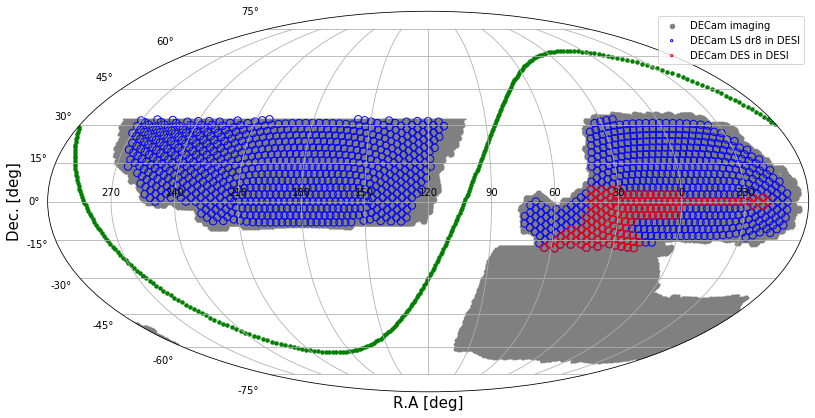

In [10]:
#
# dict without geometrical mask and whole decam+Bass+MzLS footprint (i.e., greater than DESI footprint)
hpdict2 = get_dict(cat=cat, pixmapfile=inptfiles['dr8pix'], hppix_ran=hppix_ran, hppix_cat=hppix_cat, 
                      maskrand=None, maskcat=(maskdef_cat), Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=catindesi, 
                                namesels={'any':-1, 'bright':1, 'faint':0, 'wise':2}, galb=galb, desifootprint=False)

# dict without geometrical mask and in DESI footprint
hpdict0 = get_dict(cat=cat, pixmapfile=inptfiles['dr8pix'], hppix_ran=hppix_ran, hppix_cat=hppix_cat, 
                      maskrand=None, maskcat=(maskdef_cat), Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=catindesi, 
                                namesels={'any':-1, 'bright':1, 'faint':0, 'wise':2}, galb=galb, desifootprint=True)
#
for i in ['area_all', 'bgsarea_south', 'bgsarea_north', 'bgsarea_des']:
    print(i, 'whole:',hpdict2[i], 'desifootprint:', hpdict0[i] )
    
# DECaLS area in the NGC/SGC within DESI footprint
area_decals_ngc = hpdict0['bgsfracarea'][(hpdict0['issouth']) & (hpdict0['galb'] > 0)].sum() * pixarea
area_decals_sgc = hpdict0['bgsfracarea'][(hpdict0['issouth']) & (hpdict0['galb'] < 0)].sum() * pixarea
print('NGC DECaLS:', area_decals_ngc)
print('SGC DECaLS:', area_decals_sgc)

desitiles = fitsio.read(inptfiles['desitile'])

# plotting bgsfracarea
fig = plt.figure(figsize=(14, 7))
gs = gridspec.GridSpec(1,1,wspace=0.15,hspace=0)
#cmin, cmax = xlim[0],xlim[1]
#cbarticks  = np.linspace(cmin,cmax,5)
#cbar_ylab  = ['%.2f' % x for x in cbarticks]
ax = plt.subplot(gs[0],projection=projection)
_ = set_mwd(ax,org=org)
ramw,decmw = get_radec_mw(hpdict2['ra'],hpdict2['dec'],org)
#tmp        = ~(hpdict['bgsfracarea']>0) & (hpdict2['bgsfracarea']>0) & (hpdict2['issouth'])
tmp        = (hpdict2['bgsfracarea']>0) & (hpdict2['issouth'])
SC         = ax.scatter(ramw[tmp],decmw[tmp],s=0.4, color='gray', label=r'DECam imaging')

ramw,decmw = get_radec_mw(desitiles['ra'],desitiles['dec'],org)
tmp = (desitiles['in_desi'] ==  1) & (desitiles['dec'] < dec_resol_ns)
SC         = ax.scatter(ramw[tmp],decmw[tmp], marker='.', s = 220, facecolors='none', edgecolors='blue', label=r'DECam LS dr8 in DESI')

desitilesindes = raichoorlib.get_isdes(desitiles['ra'],desitiles['dec'])
tmp = (desitiles['in_desi'] ==  1) & (desitiles['dec'] < dec_resol_ns) & (desitilesindes)
SC         = ax.scatter(ramw[tmp],decmw[tmp], marker='.', s = 220, facecolors='none', edgecolors='red', label=r'DECam DES in DESI')

gc = SkyCoord(l=np.linspace(0, 360, 300)*units.degree, b=np.full(300, 0)*units.degree, frame='galactic')
ramw,decmw = get_radec_mw(gc.icrs.ra.value, gc.icrs.dec.value,org)
SC         = ax.scatter(ramw, decmw, color='green', marker='.', lw=1.5)

lgnd = ax.legend()
[handle.set_sizes([20.0]) for handle in lgnd.legendHandles]

fig.savefig('decals_in_desi_footprint' +'.png', bbox_inches = 'tight', pad_inches = 0)


infs in stardens: 0
infs in ebv: 0
infs in galdepth_g: 0
infs in galdepth_r: 0
infs in galdepth_z: 0
infs in psfsize_g: 0
infs in psfsize_r: 0
infs in psfsize_z: 0


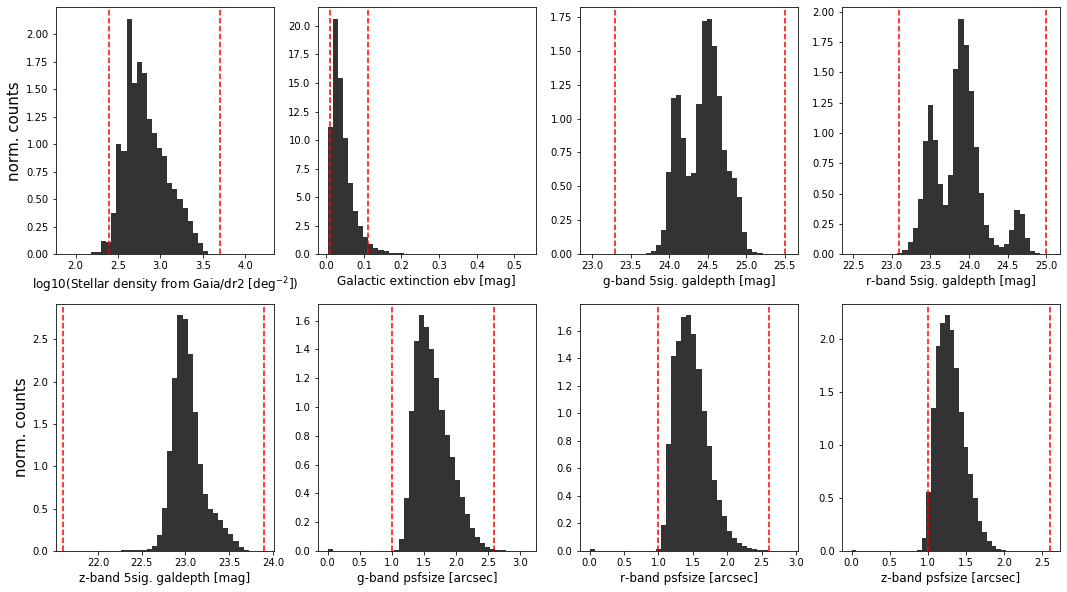

In [9]:
plt.figure(figsize=(18, 10))

for i, key in enumerate([ 'STARDENS', 'EBV', 'GALDEPTH_G', 'GALDEPTH_R', 'GALDEPTH_Z', 'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z']):
    
    key = key.lower()
    keep = (np.isfinite(hpdict[key]))
    keep &= (hpdict['isdesi']) & (hpdict['bgsfracarea'] > 0)
    tmphpdict = hpdict[key][keep] #& (hpdict[key] > 0)
    print('infs in %s: %i' %(key, np.sum(~np.isfinite(tmphpdict))))
    plt.subplot(2,4,i+1)
    xlims = tmphpdict.min(), tmphpdict.max()
    xlims2, label = get_systplot(key)
    xgrid = np.linspace(xlims[0], xlims[1], 40)
    #plt.title('min:%.5f, max:%.5f' %(xlims[0], xlims[1]))
    plt.hist(tmphpdict,bins=xgrid,histtype='stepfilled',alpha=0.8,color='k',density=True)
    plt.axvline(xlims2[0], ls='--', c='r')
    plt.axvline(xlims2[1], ls='--', c='r')
    plt.xlabel(label,fontsize=12)
    if (i==0) or (i==4): plt.ylabel('norm. counts',fontsize=15)
    

## Load BGS SV data and get target densities + sanity check

Now we move to our target catalogue `bgssvdr8` and compute the number of targets in the healpix pixels for each of the SV supersets (bright/faint/faint_ext/fibmag/lowq) and for the nort/south regions. The target density is defined as $\eta_{pix}^{bgs}(bit) = N_{pix}^{bgs}(bit)/(A_{pix} \cdot f_{A})$. Finally we get the mean density ($\bar{\eta}_{pix}^{bgs}(bit)$) and add this to the `hpdict`.

To select the sv bits we use the `SV1_BGS_TARGET` information from DESITARGET. The bits and bitvalues key is below:

    name	       bitnums	bitvals
    BGS_FAINT	    0	        1
    BGS_BRIGHT	   1	        2
    
To make sure we haven't mess things around, we run a sanity check with a random subsample of $1$%. We make colour plots of $g-r$, $r-z$ and scatter plots of $rmag$ vs $rfibmag$ plus their distributions for all the SV bits and for each of the nort/south regions.

## Results: systematics

### Defining limits in systematics

/global/homes/q/qmxp55/DESI/omarlibs/main_def.py:957: RuntimeWarning: invalid value encountered in true_divide
  hpdens = (hpdicttmp['south_n'+namesel] + hpdicttmp['north_n'+namesel] ) / (pixarea * hpdicttmp['bgsfracarea'])


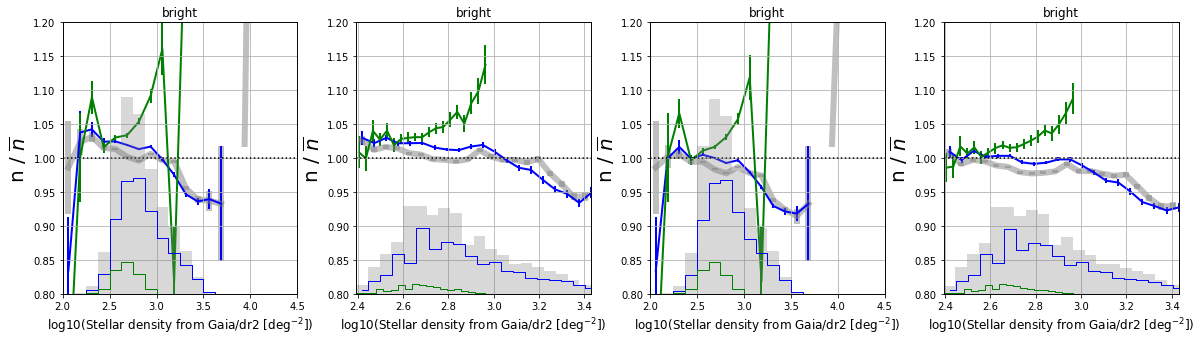

In [10]:
#
isdesi    = (hpdict['bgsfracarea']>0) & (hpdict['isdesi'])
xlims = [[2.2, 3.6],[2.4, 3.7], [2, 4.0], [2, 4.5]]
conblims = [[False, False], [True, False], [False, True], [True, True]]

fig = plt.figure(figsize=(20,5))
gs = gridspec.GridSpec(1,4,hspace=0.30,wspace=0.25)

for i,j in enumerate(conblims):
    
    plot_sysdens(hpdicttmp=hpdict, namesel='bright', syst='stardens', mainreg=isdesi, xlim=[2.0, 4.5], regs=['all', 'decals','test'], 
                 n=i, nx=20, clip=j[0], denslims=j[1], fig=fig, gs=gs)


Shall we compute $\bar{\eta}$ on the fly using the limits of the plots? At the moment it uses the stored values in hpdict and those only have the desifotprint limits and bgsfracarea > 0.

### Sky target density + systematics per BGS selection

In [11]:
def mollweide(hpdict=None, namesel=None, reg=None, nside=256, projection=None, n=None, org=None, cm=None, fig=None):
    
    pixarea = hp.nside2pixarea(nside,degrees=True)
    
    if reg == 'all': mainreg = (hpdict['isdesi']) & (hpdict['bgsfracarea']>0)
    else: mainreg = (hpdict['isdesi']) & (hpdict['bgsfracarea']>0) & (hpdict['is'+reg])
    ramw,decmw = get_radec_mw(hpdict['ra'],hpdict['dec'],org)
    hpdens = (hpdict['south_n'+namesel] + hpdict['north_n'+namesel] ) / (pixarea * hpdict['bgsfracarea'])
    hpmean = hpdict['meandens_'+namesel+'_'+reg]
    cmin,cmax = (0.1*hpmean,2*hpmean)
    cbarticks = np.linspace(cmin,cmax,5)
    cbar_ylab = ['%.0f' % x for x in cbarticks]
    clab      = 'LS dr8/'+namesel+r' density [deg$^{-2}$]'

    # density skymap + hist
    # mollweide
    ax     = plt.subplot(gs[n],projection=projection)
    _      = set_mwd(ax,org=org)
    SC  = ax.scatter(ramw[mainreg],decmw[mainreg],s=1,
        c=hpdens[mainreg],
        cmap=cm,vmin=cmin,vmax=cmax,rasterized=True)
    p  = ax.get_position().get_points().flatten()
    cax= fig.add_axes([p[0]+0.2*(p[2]-p[0]),p[1]+0.2*(p[3]-p[1]),0.3*(p[2]-p[0]),0.025])
    cbar = plt.colorbar(SC, cax=cax, orientation='horizontal', ticklocation='top', extend='both', ticks=cbarticks)
    cbar.set_label(clab,fontweight='bold')
    cbar.ax.set_yticklabels(cbar_ylab)
    
def pixhistregs(hpdict=None, namesel=None, regs=None, cols=None, nside=256, n=None, fig=None, primary=None):
    
    pixarea = hp.nside2pixarea(nside,degrees=True)
    
    hpdens = (hpdict['south_n'+namesel] + hpdict['north_n'+namesel] ) / (pixarea * hpdict['bgsfracarea'])
    ax     = plt.subplot(gs[n])
    
    clab      = 'LS dr8/'+namesel+r' density [deg$^{-2}$]'
    hpmean = hpdict['meandens_'+namesel+'_'+'all']
    cmin,cmax = (0.1*hpmean,2*hpmean)
    xgrid  = np.linspace(cmin,cmax,51)
    
    # hist
    if len(regs) < 2:
        mainreg = (hpdict['isdesi']) & (hpdict['bgsfracarea']>0) & (hpdict['is'+regs[0]])
        ax.hist(hpdens[mainreg],bins=xgrid,histtype='stepfilled',alpha=0.3,color='k',density=True, 
                label='dr8/'+reg+' ('+'%.0f'%hpdict['meandens_'+namesel+'_'+reg]+')')
    else:
        for reg, col in zip(regs, cols):
            if reg == 'all': mainreg = (hpdict['isdesi']) & (hpdict['bgsfracarea']>0)
            else: mainreg = (hpdict['isdesi']) & (hpdict['bgsfracarea']>0) & (hpdict['is'+reg])
            if reg == primary:
                ax.hist(hpdens[mainreg], bins=xgrid,histtype='stepfilled',alpha=0.3,color='k',lw=2,density=True,
                    label='dr8/'+reg+' ('+'%.0f'%hpdict['meandens_'+namesel+'_'+reg]+')')
            else:
                ax.hist(hpdens[mainreg], bins=xgrid,histtype='step',alpha=0.8,color=col,lw=2,density=True,
                    label='dr8/'+reg+' ('+'%.0f'%hpdict['meandens_'+namesel+'_'+reg]+')')
            
    ax.set_xlabel(clab,fontsize=15)
    ax.set_ylabel('norm. counts',fontsize=15)
    ax.set_xlim(cmin,cmax)
    ax.grid(True)
    ax.legend(loc='upper right')
    
def pixhistnamesels(hpdict=None, namesels=None, reg=None, cols=None, nside=256, n=None, fig=None, primary=None, xlab=None):
    
    pixarea = hp.nside2pixarea(nside,degrees=True)
    
    if reg == 'all': mainreg = (hpdict['isdesi']) & (hpdict['bgsfracarea']>0)
    else: mainreg = (hpdict['isdesi']) & (hpdict['bgsfracarea']>0) & (hpdict['is'+reg])
    ax     = plt.subplot(gs[n])
    
    if xlab is not None: clab = 'LS dr8 '+xlab+r' density [deg$^{-2}$]'
    else: clab = 'LS dr8 '+reg+r' density [deg$^{-2}$]'
    hpmean = hpdict['meandens_'+'any'+'_'+reg]
    cmin,cmax = (0.1*hpmean,2*hpmean)
    xgrid  = np.linspace(cmin,cmax,51)
    
    # hist
    if len(namesels) < 2:
        hpdens = (hpdict['south_n'+namesel[0]] + hpdict['north_n'+namesel[0]] ) / (pixarea * hpdict['bgsfracarea'])
        ax.hist(hpdens[mainreg],bins=xgrid,histtype='stepfilled',alpha=0.3,color='k',density=True, 
                label='dr8/'+namesels[0]+' ('+'%.0f'%hpdict['meandens_'+namesel[0]+'_'+reg]+')')
    else:
        for namesel, col in zip(namesels, cols):
            hpdens = (hpdict['south_n'+namesel] + hpdict['north_n'+namesel] ) / (pixarea * hpdict['bgsfracarea'])
            if namesel == primary:
                ax.hist(hpdens[mainreg], bins=xgrid,histtype='stepfilled',alpha=0.3,color='k',lw=2,density=True,
                    label='dr8/'+namesel+' ('+'%.0f'%hpdict['meandens_'+namesel+'_'+reg]+')')
            else:
                ax.hist(hpdens[mainreg], bins=xgrid,histtype='step',alpha=0.8,color=col,lw=2,density=True,
                    label='dr8/'+namesel+' ('+'%.0f'%hpdict['meandens_'+namesel+'_'+reg]+')')
            
    ax.set_xlabel(clab,fontsize=15)
    ax.set_ylabel('norm. counts',fontsize=15)
    ax.set_xlim(cmin,cmax)
    ax.grid(True)
    ax.legend(loc='upper right')
    

/global/homes/q/qmxp55/.conda/envs/DESI_BGS_omar/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/global/homes/q/qmxp55/.conda/envs/DESI_BGS_omar/lib/python3.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in true_divide


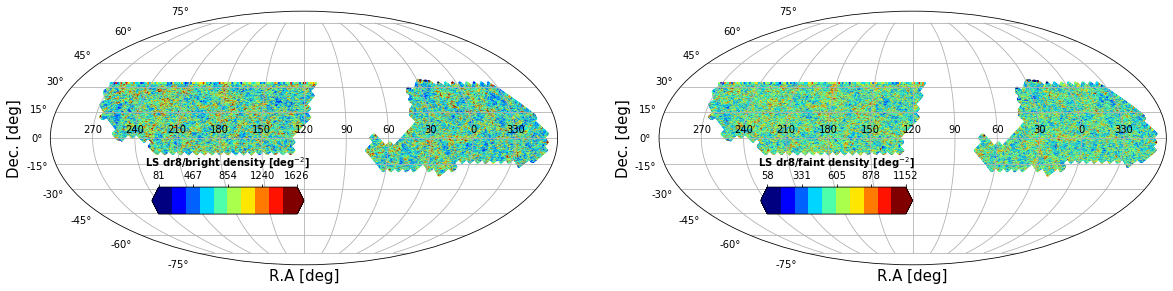

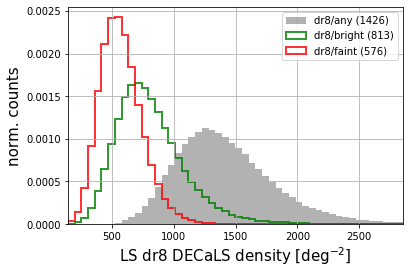

In [12]:
#
fig = plt.figure(figsize=(20, 15))
gs = gridspec.GridSpec(1,2)
    
mollweide(hpdict=hpdict, namesel='bright', reg='south', projection=projection, n=0, org=org, cm=cm, fig=fig)
mollweide(hpdict=hpdict, namesel='faint', reg='south', projection=projection, n=1, org=org, cm=cm, fig=fig)
# save fig
fig.savefig('skymaps_bright_faint.png', bbox_inches = 'tight', pad_inches = 0)

fig = plt.figure(figsize=(6, 4))
gs = gridspec.GridSpec(1,1)

namesels = ['any', 'bright', 'faint']
cols       = ['b','g','r'] 
pixhistnamesels(hpdict=hpdict, namesels=namesels, reg='south', cols=cols, n=0, fig=fig, primary='any', xlab='DECaLS')
# save fig
fig.savefig('pixhist_bright_faint.png', bbox_inches = 'tight', pad_inches = 0)


plotting density distributions + systematics for the  bright selection


/global/homes/q/qmxp55/.conda/envs/DESI_BGS_omar/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/global/homes/q/qmxp55/.conda/envs/DESI_BGS_omar/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/global/homes/q/qmxp55/DESI/omarlibs/main_def.py:966: RuntimeWarning: invalid value encountered in greater
  mask = (tmpsyst0>xlim[0]) & (tmpsyst0<xlim[1])
/global/homes/q/qmxp55/DESI/omarlibs/main_def.py:966: RuntimeWarning: invalid value encountered in less
  mask = (tmpsyst0>xlim[0]) & (tmpsyst0<xlim[1])


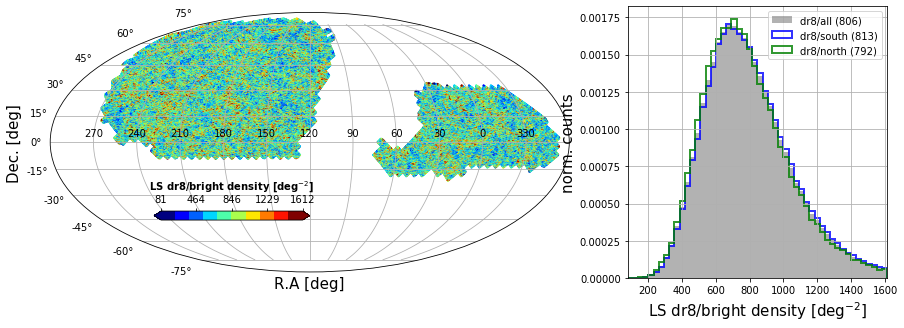

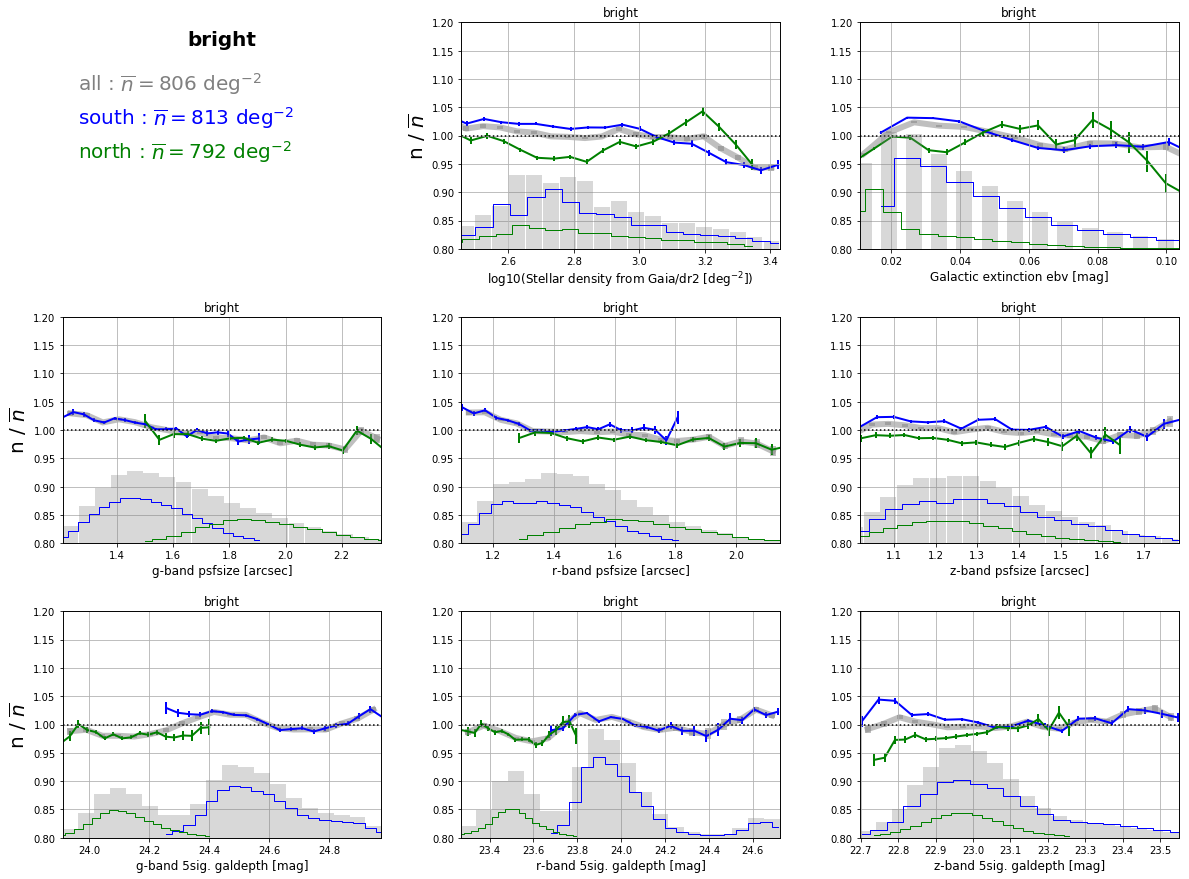

In [13]:
# dr8_south+north : density distributions + systematics

# subsamples (BGS)
namesels = ['bright']

# settings
isdesi     = (hpdict['isdesi']) & (hpdict['bgsfracarea']>0) #this should be rename as "mainreg"
systs      = ['stardens','ebv','psfsize_g', 'psfsize_r', 'psfsize_z','galdepth_g', 'galdepth_r', 'galdepth_z']
nx         = 20
#densmin,densmax = 0,2
#regs       = ['south', 'decals']
regs = ['all','south','north']
#regs = ['all', 'decals','test']
cols       = ['0.5','b','g','r']    

# looping on subselections
for namesel in namesels:
    
    print('plotting density distributions + systematics for the ', namesel, 'selection')
    fig        = plt.figure(figsize=(15,5))
    gs         = gridspec.GridSpec(1,2,wspace=0.15,hspace=0.3,width_ratios=[2,1])
    
    mollweide(hpdict=hpdict, namesel=namesel, reg='all', projection=projection, n=0, org=org, cm=cm, fig=fig)
    pixhistregs(hpdict=hpdict, namesel=namesel, regs=regs, cols=cols, n=1, fig=fig, primary='all')
    
    # save fig
    fig.savefig('skymap+denshist_main_%s.png' %(namesel), bbox_inches = 'tight', pad_inches = 0)
            
    # systematics
    fig    = plt.figure(figsize=(20,15))
    gs     = gridspec.GridSpec(3,3,hspace=0.30,wspace=0.25)
        
    for i in range(len(systs)+1):
        
        if i == 0:
            axinfo = fig.add_subplot(gs[i])
            # infos
            axinfo.axis('off')
            axinfo.text(0.5,0.9,namesel,fontsize=20,fontweight='bold',ha='center',transform=axinfo.transAxes)
            tmpy = 0.7
            for reg,col in zip(regs,cols):
                tmpstr = reg+' : '+r'$\overline{n}=$'+'%.0f'%hpdict['meandens_'+namesel+'_'+reg]+r' deg$^{-2}$'
                axinfo.text(0.05,tmpy,tmpstr,color=col,fontsize=20,transform=axinfo.transAxes)
                tmpy  -= 0.15
        else:
            syst = systs[i-1]
            if (i%3==0) or (i==1): ylab=True
            else: ylab = False
            plot_sysdens(hpdicttmp=hpdict, namesel=namesel, regs=regs, syst=syst, mainreg=isdesi, xlim=None, n=i, nx=nx, clip=True, 
                         denslims=False, ylab=ylab, weights=False, fig=fig, gs=gs)
    
    # save fig
    fig.savefig('systematics_main_%s.png' %(namesel), bbox_inches = 'tight', pad_inches = 0)
    print('')
    print('')

### comparing systematics in bright and faint

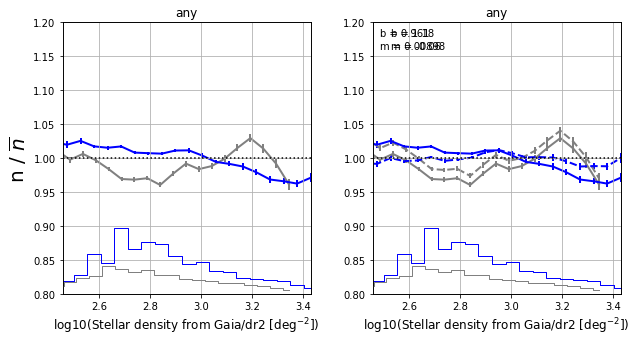

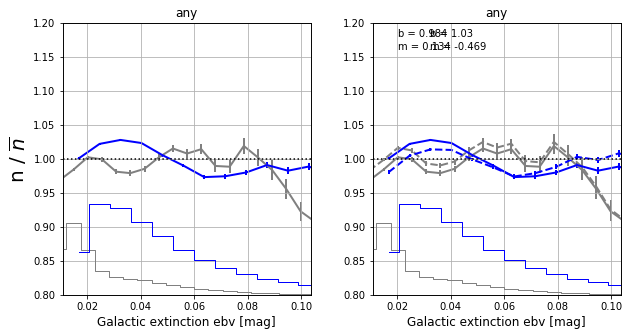

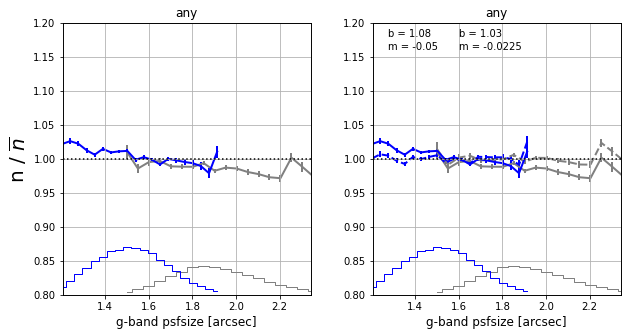

In [14]:
# systematics
#systs      = ['stardens','ebv','psfsize_g', 'psfsize_r', 'psfsize_z','galdepth_g', 'galdepth_r', 'galdepth_z']
systs      = ['stardens','ebv','psfsize_g']
nx         = 20
#namesels = ['any', 'bright', 'faint', 'wise']
namesels = [False, True]
#regs = ['all', 'des','decals','north']
regs = ['north','decals']
isdesi     = (hpdict['isdesi']) & (hpdict['bgsfracarea']>0)
#isbgsfield    = (hpdict['bgsfracarea']>0) & (hpdict['isbgsfield'])

for j in range(len(systs)):
    
    fig    = plt.figure(figsize=(5*len(namesels),5))
    gs     = gridspec.GridSpec(1,len(namesels),hspace=0.30,wspace=0.25)
    syst = systs[j]
    
    for i, namesel in enumerate(namesels):
        
        if (i%len(namesels)==0): ylab=True
        else: ylab = False
        plot_sysdens(hpdicttmp=hpdict, namesel='any', regs=regs, syst=syst, mainreg=isdesi, xlim=None, n=i, nx=nx, clip=True, denslims=False, ylab=ylab, 
                         weights=namesel, fig=fig, gs=gs)
        

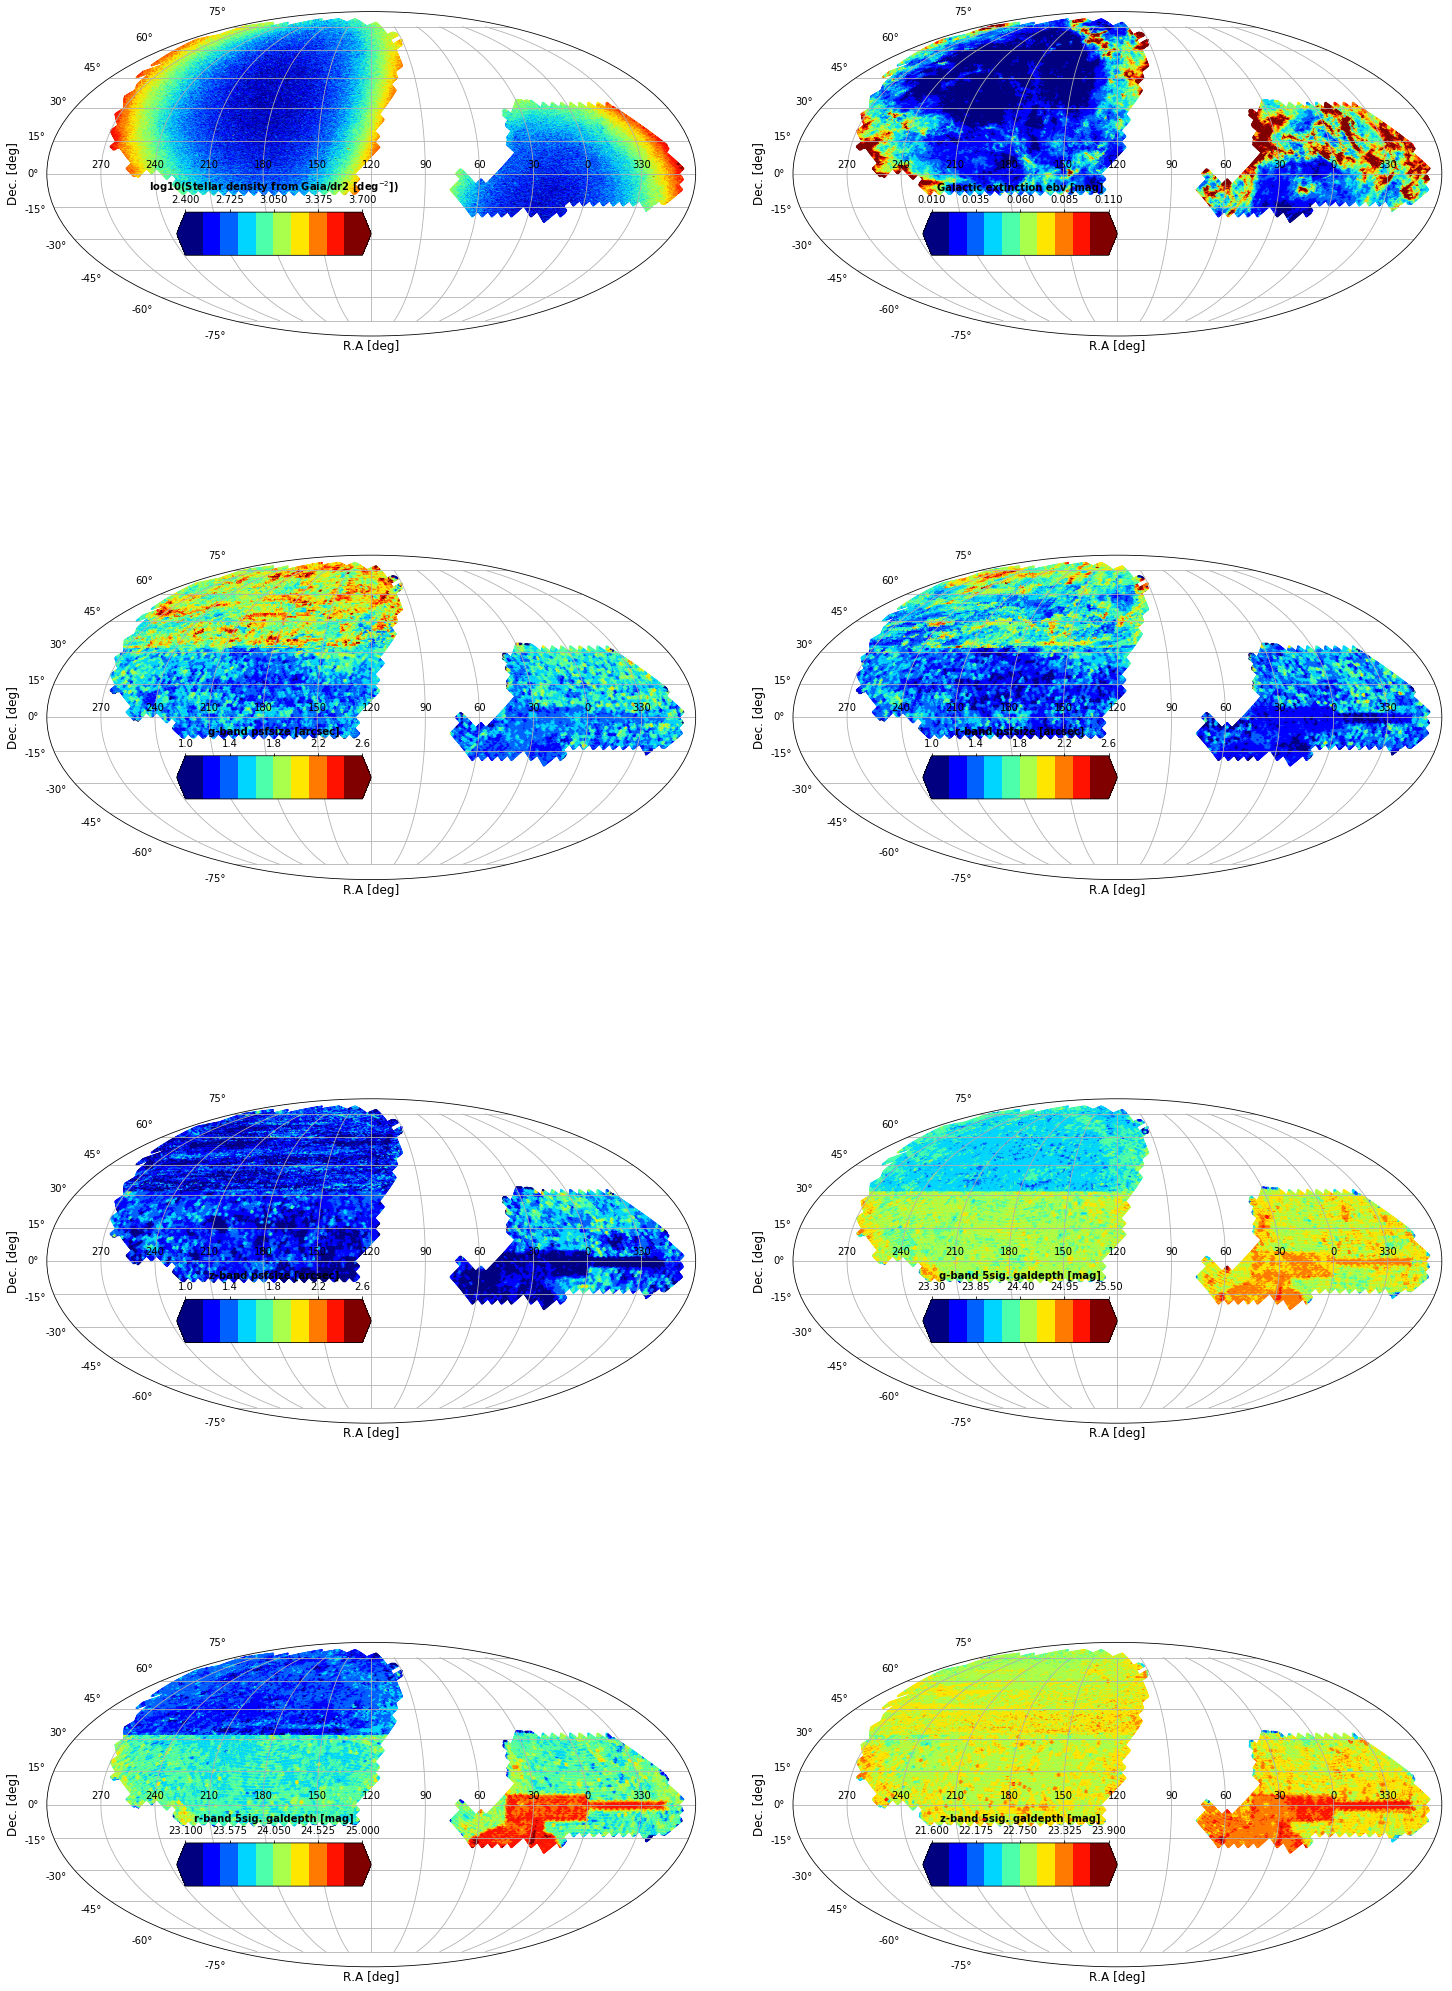

In [92]:

systs      = ['stardens','ebv', 'psfsize_g', 'psfsize_r', 'psfsize_z','galdepth_g', 'galdepth_r', 'galdepth_z']
#systs      = ['NOBS_G']

fig    = plt.figure(figsize=(25,5*len(systs)))
gs     = gridspec.GridSpec(np.int(np.ceil(len(systs)/2)),2,wspace=0.15,hspace=0)

for i, syst in enumerate(systs):
    
    #if i == 1: continue

    # plotting bgsfracarea
    xlim,lab  = get_systplot(syst)
    cmin, cmax = xlim[0],xlim[1]
    cbarticks  = np.linspace(cmin,cmax,5)
    cbar_ylab  = ['%.2f' % x for x in cbarticks]
    ax = plt.subplot(gs[i],projection=projection)
    _ = set_mwd(ax,org=org)
    ramw,decmw = get_radec_mw(hpdict['ra'],hpdict['dec'],org)
    tmp        = (hpdict['bgsfracarea']>0)
    SC         = ax.scatter(ramw[tmp],decmw[tmp],s=1,
    c=hpdict[syst][tmp],
    cmap=cm,vmin=cmin,vmax=cmax,rasterized=True)
    # https://stackoverflow.com/questions/41428442/horizontal-colorbar-over-2-of-3-subplots
    p    = ax.get_position().get_points().flatten()
    cax  = fig.add_axes([p[0]+0.2*(p[2]-p[0]),p[1]+0.35*(p[3]-p[1]),0.3*(p[2]-p[0]),0.015])
    cbar = plt.colorbar(SC, cax=cax, orientation='horizontal', ticklocation='top', extend='both', ticks=cbarticks)
    cbar.set_label('%s' %(lab),fontweight='bold')
    cbar.ax.set_yticklabels(cbar_ylab)
    

# Underdensity at high stellar density systematics

Here we're going to try to address the issue we got at high stellar density systematics where experience a lack of BGS targets.


## mitigating systematics effect with linear weights on BGS density field

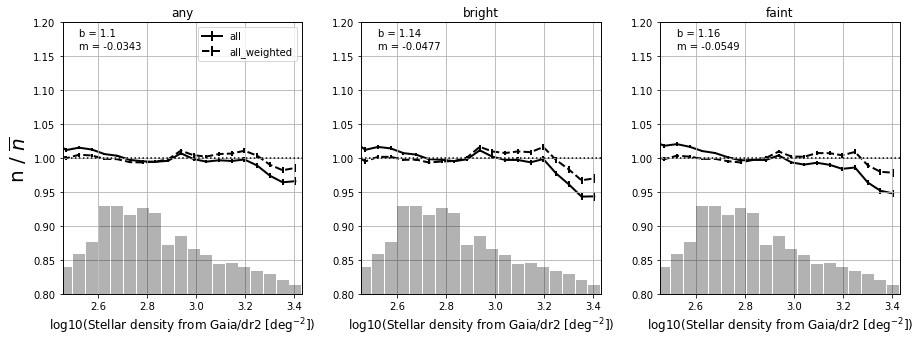

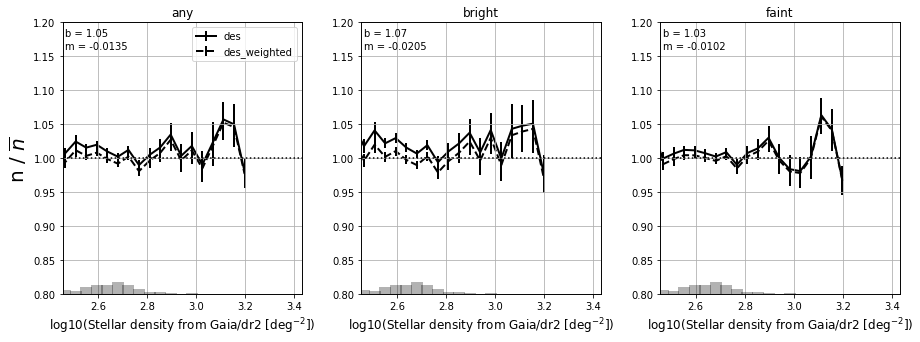

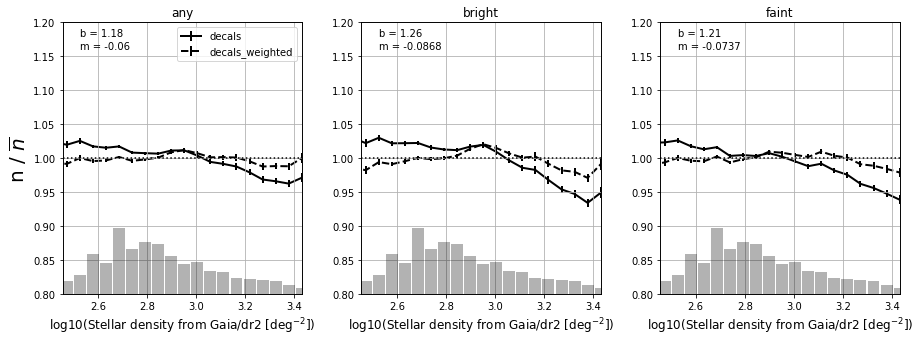

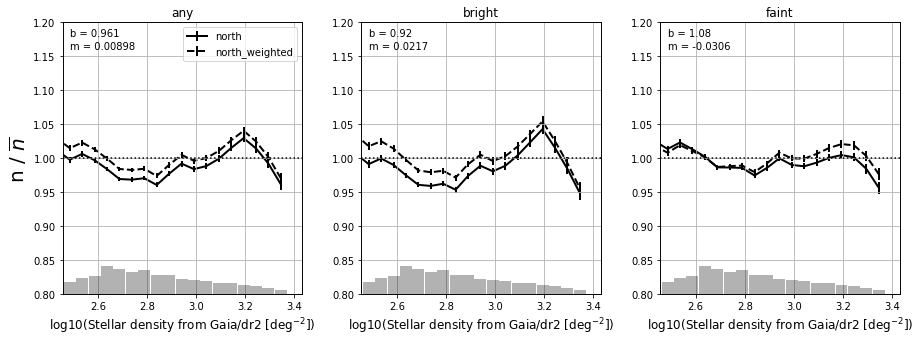

In [15]:
# systematics
nx         = 20
namesels = ['any', 'bright', 'faint']
regs = ['all', 'des','decals','north']
isdesi = (hpdict['isdesi']) & (hpdict['bgsfracarea']>0)

for num, j in enumerate(regs):
    
    fig    = plt.figure(figsize=(5*len(namesels),5))
    gs     = gridspec.GridSpec(1,len(namesels),hspace=0.30,wspace=0.25)
    
    for i, namesel in enumerate(namesels):
        
        if (i%len(namesels)==0): ylab=True
        else: ylab = False
        
        plot_sysdens(hpdicttmp=hpdict, namesel=namesel, regs=[j], syst='stardens', mainreg=isdesi, xlim=None, n=i, nx=nx, clip=True, denslims=False, ylab=ylab, 
                         weights=True, fig=fig, gs=gs, label=ylab)
        

## mitigating systematics effect by applying the MS geometric mask

In [16]:
hpdictall = get_dict(cat=cat, pixmapfile=inptfiles['dr8pix'], hppix_ran=hppix_ran, hppix_cat=hppix_cat, 
                      maskrand=((maskdef_ran) & (BS_ran) & (MS_ran) & (LG_ran) & (GC_ran) & (allmask_ran)),
                          maskcat=((maskdef_cat) & (BS_cat) & (MS_cat) & (LG_cat) & (GC_cat) & (allmask_cat)), 
                             Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=catindesi, 
                                namesels={'any':-1, 'bright':1, 'faint':0, 'wise':2}, galb=galb)

1207 nearby objects


with default BGS selection
with default BGS selection + MS


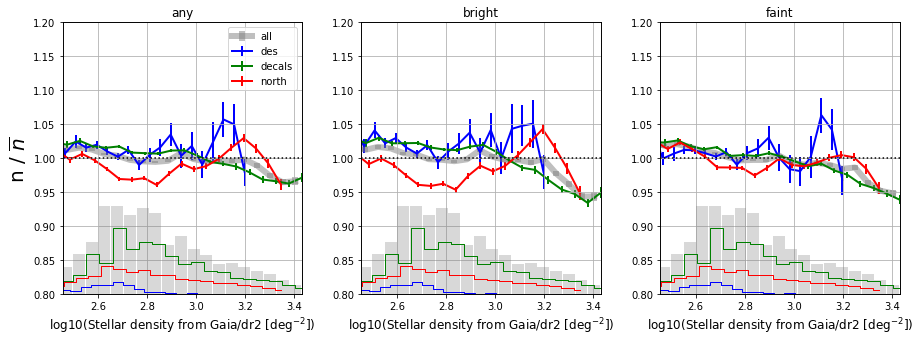

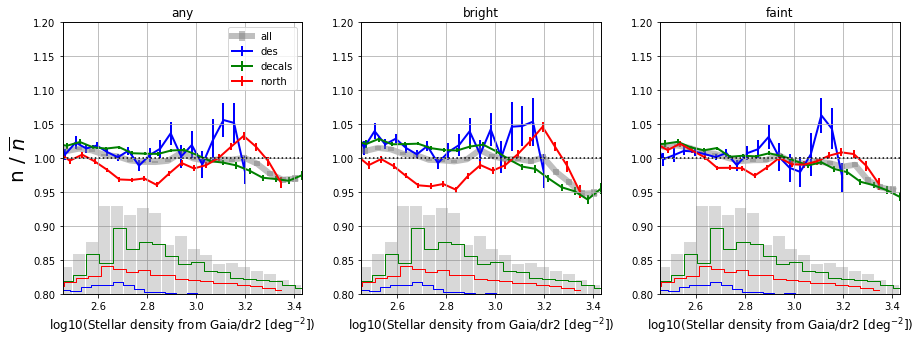

In [17]:
### systematics
nx         = 20
namesels = ['any', 'bright', 'faint']
regs = ['all', 'des','decals','north']

for num, j in enumerate([hpdict, hpdictall]):
    
    if num == 0: print('with default BGS selection')
    else: print('with default BGS selection + MS')
    
    fig    = plt.figure(figsize=(5*len(namesels),5))
    gs     = gridspec.GridSpec(1,len(namesels),hspace=0.30,wspace=0.25)
    
    for i, namesel in enumerate(namesels):
        
        if (i%len(namesels)==0): ylab=True
        else: ylab = False
            
        isdesi = (j['isdesi']) & (j['bgsfracarea']>0)
        
        plot_sysdens(hpdicttmp=j, namesel=namesel, regs=regs, syst='stardens', mainreg=isdesi, xlim=None, n=i, nx=nx, clip=True, denslims=False, ylab=ylab, 
                         weights=False, fig=fig, gs=gs, label=ylab)
        

## mitigating systematics effect by applying various BS geometric masks

The `dr8maskbitsource` catalogue includes the stars from GAIA DR2 and Tycho2 (for the tycho sources not in gaia down to MAG_VT 13). It also include the large galaxies from the LSLGA catalogue and the Globular Clusters. These catalogue was extracted from the sweeps using the `REF_CAT` information. The aim of taking the maskbit sources (i.e., the stars/galaxies/gc used in tractor to mask around) directly from the sweeps is to avoid the extraction and callibration tractor implements (here: https://github.com/legacysurvey/legacypipe/blob/master/py/legacypipe/reference.py) of the different stars, galaxies and gc catalogues. 

In file `/global/homes/q/qmxp55/DESI/BGS_paper/desi_bgs_main_dr8_general/bs_mask.py` we extract the sources responsibles of the Bright Star masking (BS mask) that comprises GAIA and Tycho stars down to their respectives mags of 13. From the GAIA side, `dr8maskbitsource` already include the GAIA G-mag but for the small quantity of Tycho stars we will need to match them to the tycho cat to extrac their MAG_VT. Once we have the BS sources, we compute the their masking radius and apply the veto around the BGS catalogue and the randoms. The result is a boolean array that has lenght of the BGS catalogue and randoms cata in the desifootprint (i.e., len(cat[catindesi]) and len(randoms[ranindesi]) and where True means masked.

For the corresponding output arrays we have choosen $n$ times the default tractor masking radii (Tradii), with $n$ being ${1.2, 1.4, 1.6, 1.8, 2.0}$. This files are stored at `/global/cscratch1/sd/qmxp55/BS_mask`. Since these output arrays doesn't have the same lenght as the BGS catalogue and the random catalogue but it does have the lenght of the desi footprint, in code below we load files with the different masking radii's and recover them to have the same lenght of the BGS cat and the randoms, this to avoid issues at the time of computing the healpix values needed with the `get_dict` function.

In [21]:
# masking arrays
bsmaskdir = '/global/cscratch1/sd/qmxp55/BS_mask/'
BSdict = {}

if os.path.isfile(bsmaskdir+'bs_main_cat'+'.npy') & os.path.isfile(bsmaskdir+'bs_main_ran'+'.npy'):
    
    tabcat = np.load(bsmaskdir+'bs_main_cat'+'.npy')
    tabran = np.load(bsmaskdir+'bs_main_ran'+'.npy')

else:
    for rad in [1.2, 1.4, 1.5, 1.6, 1.8, 2.0, 5.0, 10.0]:
    #for rad in [1.6, 2.0, 5.0, 10.0]:
    
        # create false array with same lenght as BGS cat and randoms
        bscattmp = np.zeros_like(cat['RA'], dtype='?')
        bsrantmp = np.zeros_like(randoms['RA'], dtype='?')
    
        # load the veto boolean array's of desi footprint lenght
        bscatfile = np.load(bsmaskdir+'bs_main_%sxdustinradii_cat.npy' %(str(rad)))
        bsranfile = np.load(bsmaskdir+'bs_main_%sxdustinradii_ran.npy' %(str(rad)))
    
        # recover cat/randoms size format for veto boolean array's
        bscattmp[list(np.where(catindesi)[0])] = bscatfile
        bsrantmp[list(np.where(ranindesi)[0])] = bsranfile
    
        # save new veto arrays in dict format
        BSdict['cat_%s' %(str(rad))] = bscattmp
        BSdict['ran_%s' %(str(rad))] = bsrantmp
    
    # save veto arrays dict
    tabcat = Table()
    tabran = Table()

    for col in BSdict.keys():
    
        if col[:3] == 'cat': tabcat[col] = BSdict[col]
        elif col[:3] == 'ran': tabran[col] = BSdict[col]
    
    np.save(bsmaskdir+'bs_main_cat', tabcat)
    np.save(bsmaskdir+'bs_main_ran', tabran)
    

KeyboardInterrupt: 

In [267]:
# 
hpdict_bs12 = get_dict(maskrand=((maskdef_ran) & (~BSdict['ran_1.2']) & (LG_ran) & (GC_ran)), 
                       maskcat=((maskdef_cat) & (~BSdict['cat_1.2']) & (LG_cat) & (GC_cat)))

hpdict_bs14 = get_dict(maskrand=((maskdef_ran) & (~BSdict['ran_1.4']) & (LG_ran) & (GC_ran)), 
                       maskcat=((maskdef_cat) & (~BSdict['cat_1.4']) & (LG_cat) & (GC_cat)))

#hpdict_bs16 = get_dict(maskrand=((maskdef_ran) & (~BSdict['ran_1.6']) & (LG_ran) & (GC_ran)), 
#                       maskcat=((maskdef_cat) & (~BSdict['cat_1.6']) & (LG_cat) & (GC_cat)))

hpdict_bs18 = get_dict(maskrand=((maskdef_ran) & (~BSdict['ran_1.8']) & (LG_ran) & (GC_ran)), 
                       maskcat=((maskdef_cat) & (~BSdict['cat_1.8']) & (LG_cat) & (GC_cat)))

#hpdict_bs20 = get_dict(maskrand=((maskdef_ran) & (~BSdict['ran_2.0']) & (LG_ran) & (GC_ran)), 
#                       maskcat=((maskdef_cat) & (~BSdict['cat_2.0']) & (LG_cat) & (GC_cat)))

#hpdict_bs50 = get_dict(maskrand=((maskdef_ran) & (~BSdict['ran_5.0']) & (LG_ran) & (GC_ran)), 
#                       maskcat=((maskdef_cat) & (~BSdict['cat_5.0']) & (LG_cat) & (GC_cat)))

#hpdict_bs100 = get_dict(maskrand=((maskdef_ran) & (~BSdict['ran_10.0']) & (LG_ran) & (GC_ran)), 
#                       maskcat=((maskdef_cat) & (~BSdict['cat_10.0']) & (LG_cat) & (GC_cat)))

1207 nearby objects
positions and desifotprint DONE...


/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in sqrt


systematics DONE...
randdens =  15000  ; len randoms =  304987125
bgsfracarea DONE...
regions DONE...
areas DONE...
computing for  north / any
computing for  north / bright
computing for  north / faint
target densities in north DONE...
computing for  south / any
computing for  south / bright
computing for  south / faint
target densities in south DONE...
meandens_any_all = 1415 /deg2
meandens_any_des = 1432 /deg2
meandens_any_decals = 1423 /deg2
meandens_any_north = 1395 /deg2
meandens_any_south = 1424 /deg2
meandens_bright_all = 805 /deg2
meandens_bright_des = 820 /deg2
meandens_bright_decals = 811 /deg2
meandens_bright_north = 790 /deg2
meandens_bright_south = 812 /deg2
meandens_faint_all = 574 /deg2
meandens_faint_des = 579 /deg2
meandens_faint_decals = 575 /deg2
meandens_faint_north = 571 /deg2
meandens_faint_south = 575 /deg2
start: 2019-10-31 09:45:42
end: 2019-10-31 09:47:05


/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:94: RuntimeWarning: invalid value encountered in true_divide


1207 nearby objects
positions and desifotprint DONE...
systematics DONE...
randdens =  15000  ; len randoms =  304987125
bgsfracarea DONE...
regions DONE...
areas DONE...
computing for  north / any
computing for  north / bright
computing for  north / faint
target densities in north DONE...
computing for  south / any
computing for  south / bright
computing for  south / faint
target densities in south DONE...
meandens_any_all = 1414 /deg2
meandens_any_des = 1432 /deg2
meandens_any_decals = 1422 /deg2
meandens_any_north = 1395 /deg2
meandens_any_south = 1423 /deg2
meandens_bright_all = 805 /deg2
meandens_bright_des = 820 /deg2
meandens_bright_decals = 811 /deg2
meandens_bright_north = 790 /deg2
meandens_bright_south = 812 /deg2
meandens_faint_all = 574 /deg2
meandens_faint_des = 579 /deg2
meandens_faint_decals = 575 /deg2
meandens_faint_north = 571 /deg2
meandens_faint_south = 575 /deg2
start: 2019-10-31 09:47:06
end: 2019-10-31 09:47:33
1207 nearby objects
positions and desifotprint DONE

/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide


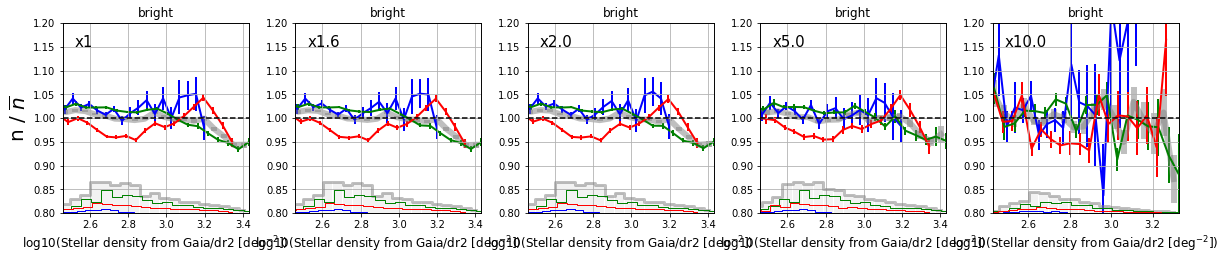

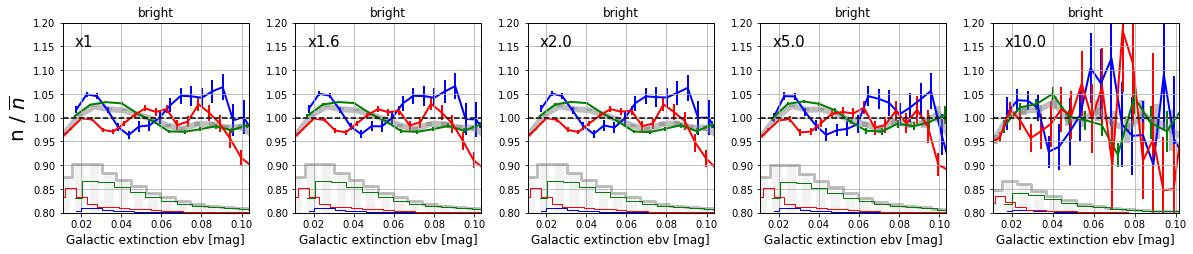

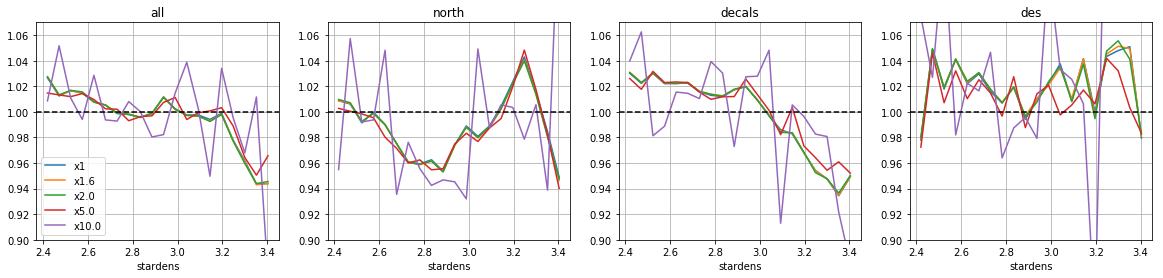

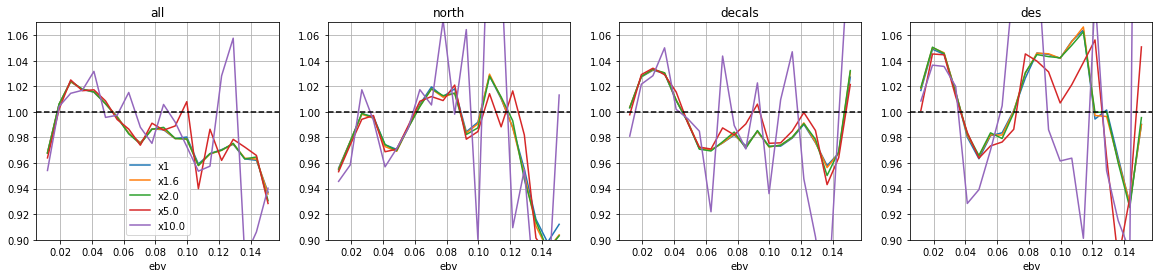

In [268]:
# systematics
systs = ['stardens','ebv']
#dicts = {'x1':hpdict, 'x1.2':hpdict_bs12, 'x1.4':hpdict_bs14, 'x1.6':hpdict_bs16, 'x2.0':hpdict_bs20}
dicts = {'x1':hpdict, 'x1.6':hpdict_bs16, 'x2.0':hpdict_bs20, 'x5.0':hpdict_bs50, 'x10.0':hpdict_bs100}
nx         = 20
#namesels = ['bright', 'faint']
varall = {}

for j in range(len(systs)):
    
    fig    = plt.figure(figsize=(4*len(dicts),3.5))
    gs     = gridspec.GridSpec(1,len(dicts),hspace=0.30,wspace=0.25)
    syst = systs[j]

    #for i, namesel in enumerate(namesels):
    for k, key in enumerate(dicts.keys()):
        
        if (k == 0): ylab=True
        else: ylab = False
                
        isdesi = (dicts[key]['isdesi']) & (dicts[key]['bgsfracarea']>0)
            
        x, yall, ynorth, ydecals, ydes = plot_sysdens(hpdicttmp=dicts[key], namesel='bright', syst=syst, mainreg=isdesi, xlim=None, n=k, 
                             nx=nx, clip=True, denslims=False, ylab=ylab, text=key)
        
        varall[syst+'_'+key+'_all'] = yall
        varall[syst+'_'+key+'_north'] = ynorth
        varall[syst+'_'+key+'_decals'] = ydecals
        varall[syst+'_'+key+'_des'] = ydes
        if k == 0: varall['x_'+syst] = x
          

        
regs = ['all', 'north', 'decals', 'des']
for i, syst in enumerate(systs):
    fig = plt.figure(figsize=(5*4, 4))
    for num, reg in enumerate(regs):
        plt.subplot(1, len(regs), num+1)
        plt.title(reg)
        for j in dicts.keys():
            plt.plot(varall['x_'+syst], varall[syst+'_'+j+'_'+reg], label=j)
        plt.axhline(1, ls='--', c='k')
        if reg == 'all': plt.legend()
        plt.xlabel(syst)
        plt.ylim(0.90, 1.07)
        plt.grid()


## 2D stacks around Bright Stars

In [36]:
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.gridspec as gridspec
from geometric_def import circular_mask_radii_func

def overdensity(cat, star, radii_1, nameMag, slitw, density=False, magbins=(8,14,4), radii_2=None, 
                grid=None, SR=[2, 240.], scaling=False, nbins=101, SR_scaling=4, logDenRat=[-3, 3], 
                    radii_bestfit=True, annulus=None, bintype='2', filename=None):
    '''
    Get scatter and density plots of objects of cat1 around objects of cat2 within a search radius in arcsec.

    Inputs
    ------
    cat: (array) catalogue 1;
    star: (array) catalogue 2;
    nameMag: (string) label of magnitude in catalogue 2;
    slitw: (float, integer) slit widht;
    density: (boolean) True to get the density as function of distance (arcsec) within shells;
    magbins: (integers) format to separate the magnitude bins in cat2 (min, max, number bins);

    Output
    ------
    (distance (arcsec), density) if density=True
    '''
    
    # define the slit width for estimating the overdensity off diffraction spikes
    slit_width = slitw
    search_radius = SR[1]

    # Paramater for estimating the overdensities
    annulus_min = SR[0]
    annulus_max = SR[1]

    ra2 = star['RA']
    dec2 = star['DEC']
    
    ra1 = cat['RA']
    dec1 = cat['DEC']

    if density:

        idx2, idx1, d2d, d_ra, d_dec = search_around(ra2, dec2, ra1, dec1,
                                                 search_radius=search_radius)
        density = []
        shells = np.linspace(1, search_radius, search_radius)
        for i in range(len(shells)-1):

            ntot_annulus = np.sum((d2d>shells[i]) & (d2d<shells[i+1]))
            density_annulus = ntot_annulus/(np.pi*(shells[i+1]**2 - shells[i]**2))
            bincenter = (shells[i]+shells[i+1])/2

            density.append([bincenter, density_annulus])

        density = np.array(density).transpose()
        plt.figure(figsize=(12, 8))
        plt.semilogy(density[0], density[1])
        plt.xlabel(r'r(arcsec)')
        plt.ylabel(r'N/($\pi r^2$)')
        plt.grid()
        plt.show()

        return density


    if bintype == '2':
        mag_bins = np.linspace(magbins[0], magbins[1], magbins[2]+1)
        mag_bins_len = len(mag_bins)-1
    elif bintype == '1':
        mag_bins = np.linspace(magbins[0], magbins[1], magbins[2])
        mag_bins_len = len(mag_bins)
    elif bintype == '0':
        mag_bins = np.array(magbins)
        mag_bins_len = len(mag_bins)-1
    else:
        raise ValueError('Invaid bintype. Choose bintype = 0, 1, 2')
    
    
    if grid is not None:
        rows, cols = grid[0], grid[1]
    else:
        rows, cols = len(mag_bins), 1
    figsize = (8*cols, 8*rows)
    gs = gridspec.GridSpec(rows, cols)
    gs.update(wspace=0.3, hspace=0.2)
    fig = plt.figure(num=1, figsize=figsize)
    ax = []
        
    for index in range(mag_bins_len):
        if (bintype == '2') or (bintype == '0'):
            mask_star = (star[nameMag]>mag_bins[index]) & (star[nameMag]<mag_bins[index+1])
            title = '{:.2f} < {} < {:.2f}'.format(mag_bins[index], nameMag, mag_bins[index+1], np.sum(mask_star))    
        elif bintype == '1':
            if index==0:
                mask_star = (star[nameMag]<mag_bins[index])
                title = '{} < {:.2f}'.format(nameMag,mag_bins[0], np.sum(mask_star))
            else:
                mask_star = (star[nameMag]>mag_bins[index-1]) & (star[nameMag]<mag_bins[index])
                title = '{:.2f} < {} < {:.2f}'.format(mag_bins[index-1], nameMag, mag_bins[index], np.sum(mask_star))
        else:
            raise ValueError('Invaid bintype. Choose bintype = 0, 1, 2')

        print(title)
        magminrad = circular_mask_radii_func([mag_bins[index+1]], radii_1, bestfit=radii_bestfit)[0]
        magmaxrad = circular_mask_radii_func([mag_bins[index]], radii_1, bestfit=radii_bestfit)[0]

        if not scaling:
            #get the mask radii from the mean magnitude
            mag_mean = np.mean(star[nameMag][mask_star])
            print('mag_mean', mag_mean)
            mask_radius = circular_mask_radii_func([mag_mean], radii_1, bestfit=radii_bestfit)[0]
            if radii_2:
                mask_radius2 = circular_mask_radii_func([mag_mean], radii_2)[0]

        idx2, idx1, d2d, d_ra, d_dec = search_around(ra2[mask_star], dec2[mask_star], ra1, dec1,
                                                 search_radius=annulus_max)

        Nsources = len(ra2[mask_star])
        perc_sources = 100*len(ra2[mask_star])/len(ra2)
        
        #print('%d sources ~%g %% ' %(Nsources, perc_sources))
        
        mag_radii = circular_mask_radii_func(star[nameMag][mask_star][idx2], radii_1, bestfit=radii_bestfit)
        #print(len(d_ra), len(mag_radii))
        print('mag_radii MAX:',mag_radii.max(), 'mag_radii MIN:',mag_radii.min())
        print('mag MAX:',star[nameMag][mask_star][idx2].max(), 'mag MIN:',star[nameMag][mask_star][idx2].min())

        #markersize = np.max([0.01, np.min([10, 0.3*100000/len(idx2)])])
        #axis = [-search_radius*1.05, search_radius*1.05, -search_radius*1.05, search_radius*1.05]
        #axScatter = scatter_plot(d_ra, d_dec, markersize=markersize, alpha=0.4, figsize=6.5, axis=axis, title=title)
        
        row = (index // cols)
        col = index % cols
        ax.append(fig.add_subplot(gs[row, col]))
        
        if scaling:
            d2d_arcsec = d2d
            d_ra, d_dec, d2d = d_ra/mag_radii, d_dec/mag_radii, d2d_arcsec/mag_radii
            search_radius = SR_scaling #d2d.max() - d2d.max()*0.3
            #ntot_annulus = np.sum((d2d_arcsec>annulus_min) & (d2d<search_radius))
            ntot_annulus = np.sum(d2d<search_radius)
            #density_annulus = ntot_annulus/(np.pi*(search_radius**2 - d2d[d2d_arcsec > 2].min()**2))
            density_annulus = ntot_annulus/(np.pi*(search_radius**2))
            #print('ntot_annulus:', ntot_annulus, 'density_annulus:', density_annulus)
            print('d2d min=%2.3g, d2d max=%2.3g' %(d2d.min(), d2d.max()))
        else:
            d2d_arcsec = None
            ntot_annulus = np.sum((d2d>annulus_min) & (d2d<annulus_max))
            density_annulus = ntot_annulus/(np.pi*(annulus_max**2 - annulus_min**2))
        
        if annulus is not None:
            annMask = np.ones(len(cat), dtype='?')
            d_ra2 = np.zeros(len(cat))
            d_dec2 = np.zeros(len(cat))
            d_ra2[idx1] = d_ra
            d_dec2[idx1] = d_dec
            print(len(cat), len(d_ra2), len(d_dec2))
            #print(len(set(idx1)), len(set(idx2)))
            #print(idx1.max(), idx2.max())
            #angle_array = np.linspace(0, 2*np.pi, 240)
            annMask &= np.logical_and((d_ra2**2 + d_dec2**2) < annulus[1]**2, (d_ra2**2 + d_dec2**2) > annulus[0]**2)
            
            #annMask &= np.logical_and(d_dec < annulus[1] * np.cos(angle_array), d_dec > annulus[0] * np.cos(angle_array))
        
        if scaling:
            mask_radius = None
        
        bins, mesh_d2d, density_ratio = relative_density_plot(d_ra, d_dec, d2d, search_radius,
                        ref_density=density_annulus, return_res=True, show=False, nbins=nbins, 
                            ax=ax[-1], d2d_arcsec=d2d_arcsec, annulus_min=annulus_min, 
                                logDenRat=logDenRat, mask_radius=magmaxrad)
   
        if not scaling:
            angle_array = np.linspace(0, 2*np.pi, 240)
            for i in [magminrad, magmaxrad]:
                x = i * np.sin(angle_array)
                y = i * np.cos(angle_array)
                ax[-1].plot(x, y, 'k', lw=2)
            
            ax[-1].text(-annulus_max+annulus_max*0.02, annulus_max-annulus_max*0.05, '%d sources ~%2.3g %% ' %(Nsources, perc_sources), fontsize=8,color='k')
            ax[-1].text(-annulus_max+annulus_max*0.02, annulus_max-annulus_max*0.11, '%d objects ~%2.3g %% ' %(ntot_annulus, 100*ntot_annulus/len(ra1)), fontsize=8,color='k')
            #ax[-1].text(-annulus_max+annulus_max*0.02, annulus_max-annulus_max*0.17, '$\eta$=%2.3g arcsec$^{-2}$' %(density_annulus), fontsize=8,color='k')

            ax[-1].set_xlabel(r'$\Delta$RA (arcsec)')
            ax[-1].set_ylabel(r'$\Delta$DEC (arcsec)')
        
            if radii_2:
                x2 = mask_radius2 * np.sin(angle_array)
                y2 = mask_radius2 * np.cos(angle_array)
                ax[-1].plot(x2, y2, 'k', lw=1.5, linestyle='--')
        else:
            angle_array = np.linspace(0, 2*np.pi, 100)
            x = 1 * np.sin(angle_array)
            y = 1 * np.cos(angle_array)
            ax[-1].plot(x, y, 'k', lw=4)
            
            ax[-1].text(-SR_scaling+0.1, SR_scaling-0.2, '%d sources ~%2.3g %% ' %(Nsources, perc_sources), fontsize=10,color='k')
            ax[-1].text(-SR_scaling+0.1, -SR_scaling+0.1, '%d objects ~%2.3g %% ' %(ntot_annulus, 100*ntot_annulus/len(ra1)), fontsize=10,color='k')
            #ax[-1].text(-SR_scaling+0.1, SR_scaling-0.9, '$\eta$=%2.3g deg$^{-2}$' %(density_annulus), fontsize=8,color='k')

            ax[-1].set_xlabel(r'$\Delta$RA/radii$_{i}$')
            ax[-1].set_ylabel(r'$\Delta$DEC/radii$_{i}$')
            
        ax[-1].set_title(title)
        ax[-1].axvline(0, ls='--', c='k')
        ax[-1].axhline(0, ls='--', c='k')
        if annulus is not None:
            for i in annulus:
                x = i * np.sin(angle_array)
                y = i * np.cos(angle_array)
                ax[-1].plot(x, y, 'yellow', lw=3, ls='-')
                
    if filename is not None:
            fig.savefig(filename+'.png', bbox_inches = 'tight', pad_inches = 0)
    
    if annulus is not None:
        return d_ra2, d_dec2, annMask
        
        
def search_around(ra1, dec1, ra2, dec2, search_radius=1., verbose=True):
    '''
    Using the astropy.coordinates.search_around_sky module to find all pairs within
    some search radius.
    Inputs:
    RA and Dec of two catalogs;
    search_radius (arcsec);
    Outputs:
        idx1, idx2: indices of matched objects in the two catalogs;
        d2d: angular distances (arcsec);
        d_ra, d_dec: the differences in RA and Dec (arcsec);
    '''

    # protect the global variables from being changed by np.sort
    ra1, dec1, ra2, dec2 = map(np.copy, [ra1, dec1, ra2, dec2])

    # Matching catalogs
    sky1 = SkyCoord(ra1*u.degree,dec1*u.degree, frame='icrs')
    sky2 = SkyCoord(ra2*u.degree,dec2*u.degree, frame='icrs')
    idx1, idx2, d2d, d3d = sky2.search_around_sky(sky1, seplimit=search_radius*u.arcsec)
    if verbose:
        print('%d nearby objects ~ %g %%'%(len(idx1), 100*len(idx1)/len(ra2)))

    # convert distances to numpy array in arcsec
    d2d = np.array(d2d.to(u.arcsec))


    d_ra = (ra2[idx2]-ra1[idx1])*3600.    # in arcsec
    d_dec = (dec2[idx2]-dec1[idx1])*3600. # in arcsec
    ##### Convert d_ra to actual arcsecs #####
    mask = d_ra > 180*3600
    d_ra[mask] = d_ra[mask] - 360.*3600
    mask = d_ra < -180*3600
    d_ra[mask] = d_ra[mask] + 360.*3600
    d_ra = d_ra * np.cos(dec1[idx1]/180*np.pi)
    ##########################################

    return idx1, idx2, d2d, d_ra, d_dec

def relative_density_plot(d_ra, d_dec, d2d, search_radius, ref_density, nbins=101, return_res=False, 
                          show=True, ax=plt, d2d_arcsec=None, annulus_min=2, logDenRat=[-3,3], mask_radius=None):

    bins = np.linspace(-search_radius, search_radius, nbins)
    bin_spacing = bins[1] - bins[0]
    bincenter = (bins[1:]+bins[:-1])/2
    mesh_ra, mesh_dec = np.meshgrid(bincenter, bincenter)
    mesh_d2d = np.sqrt(mesh_ra**2 + mesh_dec**2)
    if d2d_arcsec is not None:
        mask = (d2d_arcsec>annulus_min) #to avoid self match with stars
    else:
        mask = (d2d>annulus_min) #to avoid self match with stars
    #taking the 2d histogram and divide by the area of each bin to get the density
    density, _, _ = np.histogram2d(d_ra[mask], d_dec[mask], bins=bins)/(bin_spacing**2)
    #ignoring data outside the circle with radius='search radius'
    #print('Nbins:',len(bins), 'binArea:', bin_spacing**2, 'Nobjects:', len(d_ra[mask]))
    #pix_density = len(d_ra[mask])/((len(bins)**2)*(bin_spacing**2))
    #print('tot_density_pix:', pix_density)
    
    #mean density at search radius
    if search_radius < 10:
        meanmask = np.logical_and(mesh_d2d <= search_radius, mesh_d2d > 1.2)
    else:
        meanmask = np.logical_and(mesh_d2d <= search_radius, mesh_d2d > 100.)
    ref_density = np.mean(density[meanmask])
    
    #density profile
    dist = np.linspace(0., search_radius, nbins)
    dist2 = np.linspace(0.008, search_radius, nbins/2.)
    dist_spacing = dist[1] - dist[0]
    dist_spacing2 = dist2[1] - dist2[0]
    dpx, dpy, dpx2, dpy2 = [], [], [], []
    for i, j in enumerate(dist):
        #for the cumulative radia profile
        dmask = mesh_d2d <= j
        drcumu = np.log2(np.mean(density[dmask]/ref_density))
        if drcumu is np.nan:
            dpy.append(-1)
        else:
            dpy.append(drcumu)
        dpx.append(j)
    for i, j in enumerate(dist2[:-1]):
        #for the no cumulative radia profile
        dmask2 = np.logical_and(mesh_d2d < dist2[i+1], mesh_d2d >= dist2[i])
        drnocumu = np.log2(np.mean(density[dmask2]/ref_density))
        #drnocumu = np.mean(density[dmask2]/ref_density) -1.
        if drnocumu is np.nan:
            dpy2.append(-1)
        else:
            dpy2.append(drnocumu)
        dpx2.append(dist2[i] + dist_spacing2/2.)
    
    if search_radius < 10:
        dpy = np.array(dpy)
        dpy2 = np.array(dpy2)
        dmax = dpy2[np.array(dpx2) > 1].max()
        dmin = dpy2[np.array(dpx2) > 1].min()
        maglimrad = 1
    else:
        dpy20 = np.array(dpy2)
        dpy = np.array(dpy)*search_radius/logDenRat[1]
        dpy2 = np.array(dpy2)*search_radius/logDenRat[1]
        dmax = dpy20[np.array(dpx2) > mask_radius].max()
        dmin = dpy20[np.array(dpx2) > mask_radius].min()
        maglimrad = mask_radius
    
    print('density cumu (min, max): (%2.3g, %2.3g)' %(np.array(dpy).min(), np.array(dpy).max()))
    print('density non-cumu (min, max): (%2.3g, %2.3g)' %(np.array(dpy2).min(), np.array(dpy2).max()))
    
    mask = mesh_d2d >= bins.max()-bin_spacing
    density[mask] = np.nan
    #density_ratio = density/ref_density
    density_ratio = np.log2(density/ref_density)
    
    idxinf = np.where(np.isinf(density_ratio))
    #print('inf values:',density_ratio[idxinf])
    print('%d of inf in density ratio out of a total of %d' %(len(density_ratio[idxinf]), len(density_ratio[~np.isnan(density_ratio)])))
    density_ratio[idxinf] = logDenRat[0]
    #print('inf values AFTER:',density_ratio[idxinf])
    
    den_rat = density_ratio[~np.isnan(density_ratio)]
    denmin = den_rat.min()
    denmax = den_rat.max()
    print('Minimum density ratio = %g, Maximum density ratio = %g' %(denmin, denmax))
    print('----------------')
    fig = plt.figure(1)
    #img = ax.imshow(density_ratio.transpose()-1, origin='lower', aspect='equal',
    img = ax.imshow(density_ratio.transpose(), origin='lower', aspect='equal',
               cmap='seismic', extent=bins.max()*np.array([-1, 1, -1, 1]), vmin=logDenRat[0], vmax=logDenRat[1])
    #ax.colorbar(fraction=0.046, pad=0.04)
    fig.colorbar(img, fraction=0.046, pad=0.04, label=r'$\log_{2}(\eta_{pix}/\eta_{tot})$')
    #ax.plot(np.array(dpx), dpy, lw=2.5, color='green')
    ax.plot(np.array(dpx2), dpy2, lw=2.5, color='red')
    
    # find the max, min of density ratio profile for distances > 1
    ax.text(1*search_radius/10., search_radius - 2*search_radius/30, '$max(\eta(\Delta r)/\eta, r>%i)=%2.3g$' %(maglimrad, 2**(dmax)), fontsize=10,color='k')
    #ax.text(4*search_radius/10., search_radius - 4*search_radius/30, '$min(\eta(\delta r)/\eta)=%2.3g$' %(2**(dmin)), fontsize=10,color='k')
    
    ax.set_ylim(-search_radius, search_radius)
    if show:
        ax.show()

    if return_res:
        return bins, mesh_d2d, density_ratio

In [9]:
masksources = np.load(inptfiles['dr8maskbitsource']) #load dr8 masksource catalogue containing GAIA, TYCHO and LSLGA objects

In [10]:
# get hppix map of masksources to extract info of regions
hppixmasksourcesfile = '/global/cscratch1/sd/qmxp55/BS_mask/hppix_dr8_masksources.npy'
is_hppixmasksourcesfile = os.path.isfile(hppixmasksourcesfile)
if is_hppixmasksourcesfile: 
    hppix_masksources = np.load(hppixmasksourcesfile)
else: 
    hppix_masksources = hp.ang2pix(nside,(90.-np.array(masksources['DEC']))*np.pi/180.,np.array(masksources['RA'])*np.pi/180.,nest=nest) # randoms hp pixels array
    np.save(hppixmasksourcesfile, hppix_masksources)


In [11]:
masksources_south = get_reg(reg='south', hppix=hppix_masksources)

# get regions for masksources

ismasksourcesregfile = '/global/cscratch1/sd/qmxp55/BS_mask/inREGIONS_dr8_masksources.npy'
is_ismasksourcesregfile = os.path.isfile(ismasksourcesregfile)
if is_ismasksourcesregfile:
    ismasksourcesreg = np.load(ismasksourcesregfile)
else:
    ismasksourcesreg = {}
    regs = ['des', 'decals', 'north', 'desi', 'south']
    for i in regs:
        reg = get_reg(reg=i, hpdict=hpdict, hppix=hppix_masksources)
        ismasksourcesreg[i] = reg

    # save region info as npy file
    from astropy.table import Table
    tabreg = Table()

    for key in ismasksourcesreg.keys():
        tabreg[key] = ismasksourcesreg[key]
    
    # save astropy table as npy file
    np.save(ismasksourcesregfile, tabreg)
    

In [41]:
#
from raichoorlib import search_around
from astropy.table import Table

def get_bsmask():
    
    mag = np.zeros_like(masksources['RA'])
    ingaia = (masksources['REF_CAT'] == b'G2') & (masksources['G'] <= 13)
    intycho = (masksources['REF_CAT'] == b'T2')
    print('N of GAIA objects in BS mask (SOUTH): %i' %(np.sum((ingaia) & (masksources_south))))
    print('N of Tycho objects in BS mask (SOUTH): %i' %(np.sum((intycho) & (masksources_south))))
    
    # get MAG_VT mag from Tycho
    path = '/global/homes/q/qmxp55/DESI/matches/'
    tycho = fitsio.read(path+'tycho2.fits')
    idx2, idx1, d2d, d_ra, d_dec = search_around(masksources['RA'][intycho], masksources['DEC'][intycho], tycho['RA'], tycho['DEC'], search_radius=0.2)
    mag[intycho] = tycho['MAG_VT'][idx1]
    
    mag[np.where(ingaia)] = masksources['G'][ingaia]
    keep = (ingaia) | (intycho)
    
    tab = Table()
    for col in ['RA', 'DEC', 'MAG', 'REF_CAT']:
        if col == 'MAG': tab[col] = mag[keep]
        else: tab[col] = masksources[col][keep]
    print('%i Bright Stars' %(np.sum(keep)))
    
    return tab
    

In [42]:
bscat = get_bsmask()

N of GAIA objects in BS mask (SOUTH): 773673
N of Tycho objects in BS mask (SOUTH): 3349
6584 nearby objects
1724364 Bright Stars


In [44]:
3349/hpdict['bgsarea_south']

0.35623644461292353

### varying BS masking radius

In [16]:
bsmaskdir = '/global/cscratch1/sd/qmxp55/BS_mask/'
BSdict2 = np.load(bsmaskdir+'bs_main_cat.npy')
BSdict2.dtype.names

('cat_1.2', 'cat_1.4', 'cat_1.5', 'cat_1.6', 'cat_1.8', 'cat_2.0')

10.00 < MAG < 13.00
28783969 nearby objects ~ 435.503 %
mag_radii MAX: 53.4415704744 mag_radii MIN: 21.3571124679
mag MAX: 12.999997139 mag MIN: 10.0000238419
d2d min=1.6, d2d max=23.4


/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:271: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-1, 0.0582)
732 of inf in density ratio out of a total of 7556
Minimum density ratio = -8.37342, Maximum density ratio = 0.344261
----------------
10.00 < MAG < 13.00
28094124 nearby objects ~ 433.077 %
mag_radii MAX: 53.4415704744 mag_radii MIN: 21.3571124679
mag MAX: 12.999997139 mag MIN: 10.0000238419
d2d min=1.8, d2d max=23.4
density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-1, 0.0914)
950 of inf in density ratio out of a total of 7556
Minimum density ratio = -8.297, Maximum density ratio = 0.399972
----------------


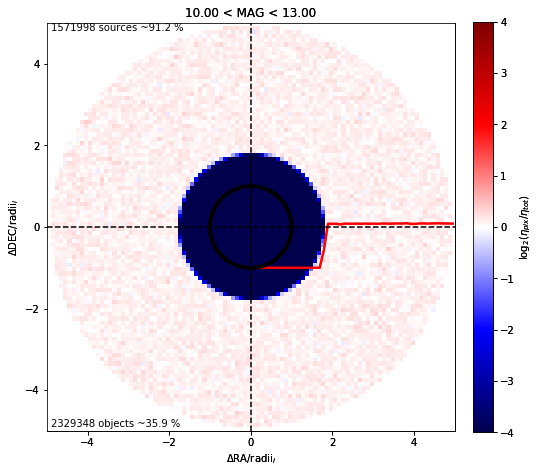

In [276]:
#Dustin_radii's
mag = np.linspace(0, 20, 50)
Dustin_MS_radii = []
for i,j in enumerate(mag):
    Dustin_MS_radii.append([j, np.minimum(1800., 150. * 2.5**((11. - j)/3.)) * 0.262/1])
    
#for col in ['cat_1.0', 'cat_1.2',  'cat_1.6', 'cat_1.8']:
for col in ['cat_1.6', 'cat_1.8']:
    
    if col == 'cat_1.0': keep = BS_cat
    else: keep = ~BSdict2[col]
        
    mask = (maskdef_cat) & (LG_cat) & (GC_cat) & (catisdecals) & (cat['RMAG'] < 19.5) & (keep)
 
    _ = overdensity(cat[mask], bscat, Dustin_MS_radii, 'MAG', 35, density=False, 
                        magbins=(10,13,1), radii_2=None, grid=[1,1], SR=[1., 500.], scaling=True, nbins=101, 
                               SR_scaling=5,logDenRat=[-4, 4], radii_bestfit=False, annulus=None, eqbined=True, 
                                   filename='2d_stack_BS_isdecals_bright_8_13_%s' %(col))
    

### per region without default BS mask

8.00 < MAG < 13.00
11137156 nearby objects ~ 159.873 %
mag_radii MAX: 98.43467880720439 mag_radii MIN: 21.357164435467904
mag MAX: 12.99998950958252 mag MIN: 8.000004768371582
d2d min=0.0395, d2d max=14


/global/homes/q/qmxp55/.conda/envs/DESI_BGS_omar/lib/python3.7/site-packages/ipykernel_launcher.py:271: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-1.35, 1.07)
0 of inf in density ratio out of a total of 7556
Minimum density ratio = -2.89268, Maximum density ratio = 2.6085
----------------
8.00 < MAG < 13.00
20855004 nearby objects ~ 172.992 %
mag_radii MAX: 98.4341858730033 mag_radii MIN: 21.357112467941665
mag MAX: 12.99999713897705 mag MIN: 8.000020980834961
d2d min= 0, d2d max=14
density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-1.23, 1.05)
0 of inf in density ratio out of a total of 7556
Minimum density ratio = -3.9731, Maximum density ratio = 2.79949
----------------
8.00 < MAG < 13.00
10726925 nearby objects ~ 171.569 %
mag_radii MAX: 98.42342830896749 mag_radii MIN: 21.357112467941665
mag MAX: 12.99999713897705 mag MIN: 8.000374794006348
d2d min=0.0463, d2d max=14
density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-7.1, 0.492)
10 of inf in density ratio out of a total of 7556
Minimum density ratio = -7.4257, Maximum density r

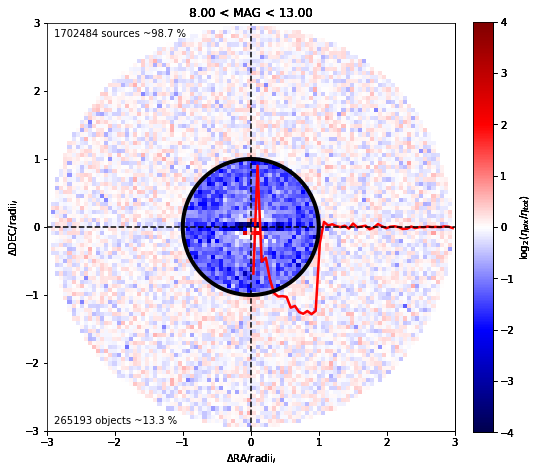

In [66]:
# Make d2 stacks per region
#Dustin_radii's
mag = np.linspace(0, 20, 50)
Dustin_MS_radii = []
for i,j in enumerate(mag):
    Dustin_MS_radii.append([j, np.minimum(1800., 150. * 2.5**((11. - j)/3.)) * 0.262/1])
    
for key, val in zip(iscatreg.keys(), iscatreg.values()):
    
    maskB = (maskdef_cat) & (LG_cat) & (GC_cat) & (val) & (cat['RMAG'] < 19.5)
    maskF = (maskdef_cat) & (LG_cat) & (GC_cat) & (val) & (cat['RMAG'] < 20.0) & (cat['RMAG'] > 19.5)
    maskall = (maskdef_cat) & (LG_cat) & (GC_cat) & (val)
    
    if (True):
        _ = overdensity(cat[maskall], bscat, Dustin_MS_radii, 'MAG', 35, density=False, 
                        magbins=(8,13,1), radii_2=None, grid=[1,1], SR=[1., 300.], scaling=True, nbins=101, 
                               SR_scaling=3,logDenRat=[-4, 4], radii_bestfit=False, annulus=None, eqbined=True, 
                                   filename='2d_stack_BS_%s_all_8_13' %(key))
 
    if False:
        _ = overdensity(cat[maskB], bscat, Dustin_MS_radii, 'MAG', 35, density=False, 
                        magbins=(10,13,1), radii_2=None, grid=[1,1], SR=[1., 300.], scaling=True, nbins=101, 
                               SR_scaling=2,logDenRat=[-4, 4], radii_bestfit=False, annulus=None, eqbined=True, 
                                   filename='2d_stack_BS_%s_bright_10_13' %(key))
    if False:
        _ = overdensity(cat[maskF], bscat, Dustin_MS_radii, 'MAG', 35, density=False, 
                        magbins=(10,13,1), radii_2=None, grid=[1,1], SR=[1., 300.], scaling=True, nbins=101, 
                               SR_scaling=2,logDenRat=[-4, 4], radii_bestfit=False, annulus=None, eqbined=True, 
                                   filename='2d_stack_BS_%s_faint_10_13' %(key))


### in DECaLS after default BS mask and with/without GAIA in BGS

fraction of BGS in gaia: 2553316 / 26739667
7.00 < MAG < 9.00
mag_mean 8.301285292202802
600744 nearby objects ~ 5.07736 %
mag_radii MAX: 133.45724869510386 mag_radii MIN: 72.4170487046112
mag MAX: 8.999996185302734 mag MIN: 7.000432968139648
density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-inf, 7.22)
440 of inf in density ratio out of a total of 7556
Minimum density ratio = -6.37691, Maximum density ratio = 0.517909
----------------
9.00 < MAG < 11.00
mag_mean 10.260868006532178


/global/homes/q/qmxp55/.conda/envs/DESI_BGS_omar/lib/python3.7/site-packages/ipykernel_launcher.py:278: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


3527307 nearby objects ~ 29.812 %
mag_radii MAX: 72.41497403533126 mag_radii MIN: 39.31540427228979
mag MAX: 10.99997329711914 mag MIN: 9.00009536743164
density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-inf, 1.72)
119 of inf in density ratio out of a total of 7556
Minimum density ratio = -8.84382, Maximum density ratio = 0.254214
----------------
11.00 < MAG < 13.00
mag_mean 12.23097600484702
16227940 nearby objects ~ 137.155 %
mag_radii MAX: 39.31479848584641 mag_radii MIN: 21.357112467941665
mag MAX: 12.99999713897705 mag MIN: 11.000020980834961
density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-inf, 0.994)
29 of inf in density ratio out of a total of 7556
Minimum density ratio = -11.0174, Maximum density ratio = 0.120275
----------------


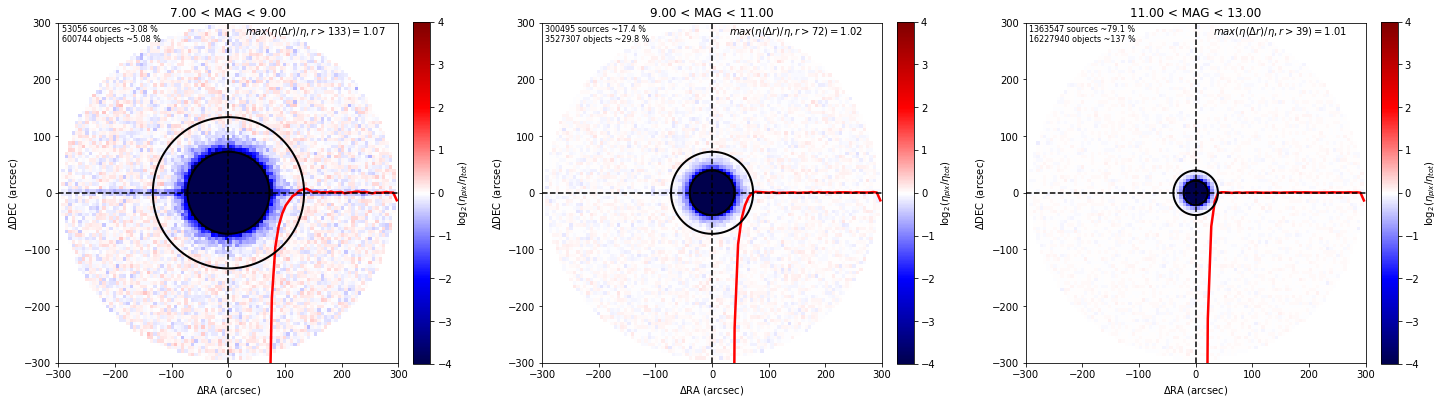

In [112]:
ingaia = (cat['GAIA_PHOT_G_MEAN_MAG'] != 0)
inbgs = (maskdef_cat) & (LG_cat) & (GC_cat) & (BS_cat) #(~BSdict2['cat_1.2'])
maskall = (inbgs) & (iscatreg['isdecals']) #& (~ingaia)
print('fraction of BGS in gaia: %i / %i' %(np.sum((ingaia) & (inbgs)), np.sum((inbgs))))

_ = overdensity(cat[maskall], bscat, Dustin_MS_radii, 'MAG', 35, density=False, 
                        magbins=(7,13,3), radii_2=None, grid=[1,3], SR=[2., 300.], scaling=False, nbins=101, 
                               SR_scaling=3,logDenRat=[-4, 4], radii_bestfit=False, annulus=None, eqbined=True, 
                                   filename='2d_stack_BS_%s_all_test' %(key))

### in DECaLS after default BS mask and with Grr star classification in stellar catalogue

In [33]:
# match BGS with BS stellar catalogue to get rid of galaxies in stellar catalogue

inbgs = (maskdef_cat) & (LG_cat) & (GC_cat) & (BS_cat)
maskall = (inbgs) & (iscatreg['isdecals'])

idx2, idx1, d2d, d_ra, d_dec = search_around(cat['RA'][maskall], cat['DEC'][maskall], 
                                             bscat['RA'], bscat['DEC'], search_radius=3.)


1 nearby objects


In [17]:
iscatsouth = get_reg(reg='south', hppix=hppix_cat)

### in SOUTH before default BS mask

In [46]:
from main_def import overdensity

8.00 < MAG < 12.00
19094569 nearby objects ~ 140.105 %
mag_radii MAX: 98.43467880720439 mag_radii MIN: 29.01009464736186
mag MAX: 11.999996185302734 mag MIN: 8.000004768371582
d2d min=0.0322, d2d max=13.8
density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-1.14, 1.4)
0 of inf in density ratio out of a total of 7556
Minimum density ratio = -3.43648, Maximum density ratio = 3.14547
----------------
12.00 < MAG < 13.00
22259435 nearby objects ~ 163.326 %
mag_radii MAX: 29.010044635122284 mag_radii MIN: 21.357112467941665
mag MAX: 12.99999713897705 mag MIN: 12.000001907348633
d2d min= 0, d2d max=18.7
density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-inf, 0.0642)
6 of inf in density ratio out of a total of 7556
Minimum density ratio = -6.60092, Maximum density ratio = 0.497114
----------------


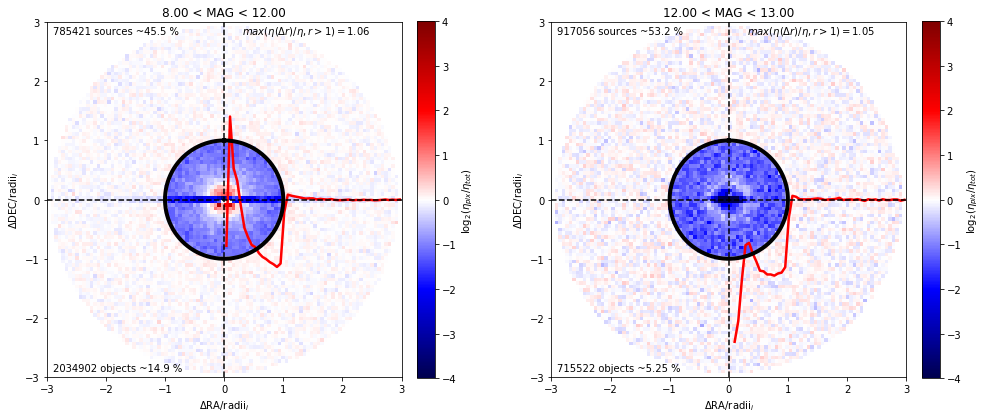

In [50]:
#Dustin_radii's
mag = np.linspace(0, 20, 50)
Dustin_MS_radii = []
for i,j in enumerate(mag):
    Dustin_MS_radii.append([j, np.minimum(1800., 150. * 2.5**((11. - j)/3.)) * 0.262/1])
    
inbgs = (maskdef_cat) & (LG_cat) & (GC_cat)# & (BS_cat)
maskall = (inbgs) & (iscatsouth)

_ = overdensity(cat[maskall], bscat, Dustin_MS_radii, 'MAG', 35, density=False, 
                        magbins=[8,12,13], radii_2=None, grid=[1,2], SR=[2., 400.], scaling=True, nbins=101, 
                               SR_scaling=3,logDenRat=[-4, 4], radii_bestfit=False, annulus=None, bintype='0', 
                                   filename='2d_stack_BS_%s' %('south'))

### in SOUTH after default BS mask

8.00 < MAG < 12.00
18529001 nearby objects ~ 138.397 %
mag_radii MAX: 98.43467880720439 mag_radii MIN: 29.01009464736186
mag MAX: 11.999996185302734 mag MIN: 8.000004768371582
d2d min=0.606, d2d max=13.8
density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-inf, 0.0757)
806 of inf in density ratio out of a total of 7556
Minimum density ratio = -8.04598, Maximum density ratio = 0.324709
----------------
12.00 < MAG < 13.00
21711419 nearby objects ~ 162.167 %
mag_radii MAX: 29.010044635122284 mag_radii MIN: 21.357112467941665
mag MAX: 12.99999713897705 mag MIN: 12.000001907348633
d2d min=0.121, d2d max=18.7
density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-inf, 0.055)
810 of inf in density ratio out of a total of 7556
Minimum density ratio = -6.56503, Maximum density ratio = 0.522429
----------------


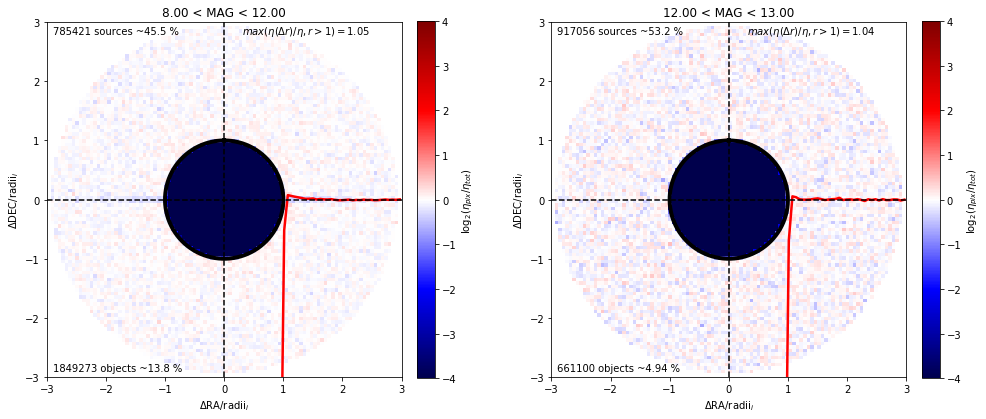

In [51]:
#Dustin_radii's
mag = np.linspace(0, 20, 50)
Dustin_MS_radii = []
for i,j in enumerate(mag):
    Dustin_MS_radii.append([j, np.minimum(1800., 150. * 2.5**((11. - j)/3.)) * 0.262/1])
    
inbgs = (maskdef_cat) & (LG_cat) & (GC_cat) & (BS_cat)
maskall = (inbgs) & (iscatsouth)

_ = overdensity(cat[maskall], bscat, Dustin_MS_radii, 'MAG', 35, density=False, 
                        magbins=[8,12,13], radii_2=None, grid=[1,2], SR=[2., 400.], scaling=True, nbins=101, 
                               SR_scaling=3,logDenRat=[-4, 4], radii_bestfit=False, annulus=None, bintype='0', 
                                   filename='2d_stack_BS_%s_2' %('south'))

## 2D stacks around Medium Stars

Medium-bright stars are also defined starting with all sources in the Tycho-2 catalog cut to MAG_VT < 13. All such Tycho-2 stars have the MEDIUM bit set. In addition, Gaia DR2 sources with phot_g_mean_mag < 16 have the MEDIUM bit set, provided they do not already match a Tycho-2 source (where the match accounts for proper motion). Note that this means that all BRIGHT stars also have the MEDIUM bit set. The specific (Gaia G) magnitude-radius relationship is hardcoded in legacypipe.

In [12]:
#
from raichoorlib import search_around
from astropy.table import Table

def get_msmask():
    
    mag = np.zeros_like(masksources['RA'])
    ingaia = (masksources['REF_CAT'] == b'G2') & (masksources['G'] <= 16)
    intycho = (masksources['REF_CAT'] == b'T2')
    
    # get MAG_VT mag from Tycho
    path = '/global/homes/q/qmxp55/DESI/matches/'
    tycho = fitsio.read(path+'tycho2.fits')
    idx2, idx1, d2d, d_ra, d_dec = search_around(masksources['RA'][intycho], masksources['DEC'][intycho], tycho['RA'], tycho['DEC'], search_radius=0.2)
    mag[intycho] = tycho['MAG_VT'][idx1]
    
    mag[np.where(ingaia)] = masksources['G'][ingaia]
    keep = (ingaia) | (intycho)
    
    tab = Table()
    for col in ['RA', 'DEC', 'MAG', 'REF_CAT']:
        if col == 'MAG': tab[col] = mag[keep]
        else: tab[col] = masksources[col][keep]
    print('%i Bright Stars' %(np.sum(keep)))
    
    return tab
    

In [13]:
mscat = get_msmask()

6584 nearby objects
12378075 Bright Stars


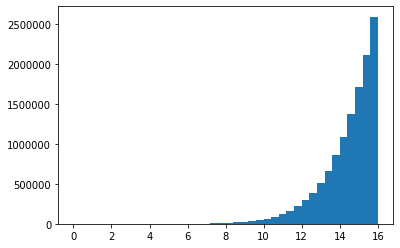

In [14]:
plt.hist(mscat['MAG'], 40)
plt.show()

### per region with default BS mask

In [ ]:
# Make d2 stacks per region
#Dustin_radii's
mag = np.linspace(0, 20, 50)
Dustin_MS_radii = []
for i,j in enumerate(mag):
    Dustin_MS_radii.append([j, np.minimum(1800., 150. * 2.5**((11. - j)/3.)) * 0.262/1])
    
for key, val in zip(iscatreg.keys(), iscatreg.values()):
    
    maskB = (maskdef_cat) & (LG_cat) & (GC_cat) & (BS_cat) & (val) & (cat['RMAG'] < 19.5)
    maskF = (maskdef_cat) & (LG_cat) & (GC_cat) & (BS_cat) & (val) & (cat['RMAG'] < 20.0) & (cat['RMAG'] > 19.5)
    maskall = (maskdef_cat) & (LG_cat) & (GC_cat) & (BS_cat) & (val)
    
    if (True):
        _ = overdensity(cat[maskall], mscat, Dustin_MS_radii, 'MAG', 35, density=False, 
                        magbins=(8,16,1), radii_2=None, grid=[1,1], SR=[1., 300.], scaling=True, nbins=101, 
                               SR_scaling=3,logDenRat=[-4, 4], radii_bestfit=False, annulus=None, eqbined=True, 
                                   filename='2d_stack_MS_%s_all_8_13' %(key))
 
    if False:
        _ = overdensity(cat[maskB], mscat, Dustin_MS_radii, 'MAG', 35, density=False, 
                        magbins=(10,16,1), radii_2=None, grid=[1,1], SR=[1., 300.], scaling=True, nbins=101, 
                               SR_scaling=3,logDenRat=[-4, 4], radii_bestfit=False, annulus=None, eqbined=True, 
                                   filename='2d_stack_MS_%s_bright_10_13' %(key))
    if False:
        _ = overdensity(cat[maskF], mscat, Dustin_MS_radii, 'MAG', 35, density=False, 
                        magbins=(10,16,1), radii_2=None, grid=[1,1], SR=[1., 300.], scaling=True, nbins=101, 
                               SR_scaling=3,logDenRat=[-4, 4], radii_bestfit=False, annulus=None, eqbined=True, 
                                   filename='2d_stack_MS_%s_faint_10_13' %(key))


8.00 < MAG < 16.00
72720261 nearby objects
mag_radii MAX: 98.43467880720439 mag_radii MIN: 8.544484463674413
mag MAX: 15.999999046325684 mag MIN: 8.000004768371582
d2d min= 0, d2d max=35.1


/global/homes/q/qmxp55/.conda/envs/DESI_BGS_omar/lib/python3.7/site-packages/ipykernel_launcher.py:278: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/global/homes/q/qmxp55/.conda/envs/DESI_BGS_omar/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/global/homes/q/qmxp55/.conda/envs/DESI_BGS_omar/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-inf, 0.0422)
8 of inf in density ratio out of a total of 7556
Minimum density ratio = -8.25443, Maximum density ratio = 0.30781
----------------
8.00 < MAG < 16.00
147195726 nearby objects
mag_radii MAX: 98.4341858730033 mag_radii MIN: 8.544484463674413
mag MAX: 15.999999046325684 mag MIN: 8.000020980834961
d2d min= 0, d2d max=35.1
density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-inf, 0.0558)
7 of inf in density ratio out of a total of 7556
Minimum density ratio = -9.1918, Maximum density ratio = 0.255285
----------------
8.00 < MAG < 16.00
74433574 nearby objects
mag_radii MAX: 98.42342830896749 mag_radii MIN: 8.544484463674413
mag MAX: 15.999999046325684 mag MIN: 8.000374794006348
d2d min= 0, d2d max=35.1
density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-inf, 0.109)
25 of inf in density ratio out of a total of 7556
Minimum density ratio = -8.23877, Maximum density ratio = 0.342433
--

### in DECaLS after default BS mask and with/without GAIA in BGS

In [26]:
circular_mask_radii_func([14], Dustin_MS_radii, bestfit=False)[0]

NameError: name 'circular_mask_radii_func' is not defined

fraction of BGS in gaia: 2553316 / 26739667
7.00 < MAG < 13.00
36420953 nearby objects ~ 307.822 %
mag_radii MAX: 133.45724869510386 mag_radii MIN: 21.357112467941665
mag MAX: 12.99999713897705 mag MIN: 7.000432968139648
d2d min=0.121, d2d max=18.7


/global/homes/q/qmxp55/.conda/envs/DESI_BGS_omar/lib/python3.7/site-packages/ipykernel_launcher.py:285: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-inf, 0.0868)
798 of inf in density ratio out of a total of 7556
Minimum density ratio = -8.45882, Maximum density ratio = 0.27589
----------------
13.00 < MAG < 14.00
38205637 nearby objects ~ 322.906 %
mag_radii MAX: 21.35708648417855 mag_radii MIN: 15.745247379763304
mag MAX: 13.999998092651367 mag MIN: 13.000000953674316
d2d min= 0, d2d max=25.4
density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-inf, 0.0361)
16 of inf in density ratio out of a total of 7556
Minimum density ratio = -6.49862, Maximum density ratio = 0.512602
----------------
14.00 < MAG < 14.50
29913362 nearby objects ~ 252.821 %
mag_radii MAX: 15.745225034392389 mag_radii MIN: 13.519857883470031
mag MAX: 14.499999046325684 mag MIN: 14.00000286102295
d2d min= 0, d2d max=29.6
density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-inf, 0.0483)
21 of inf in density ratio out of a total of 7556
Minimum density ratio = -5.50397, 

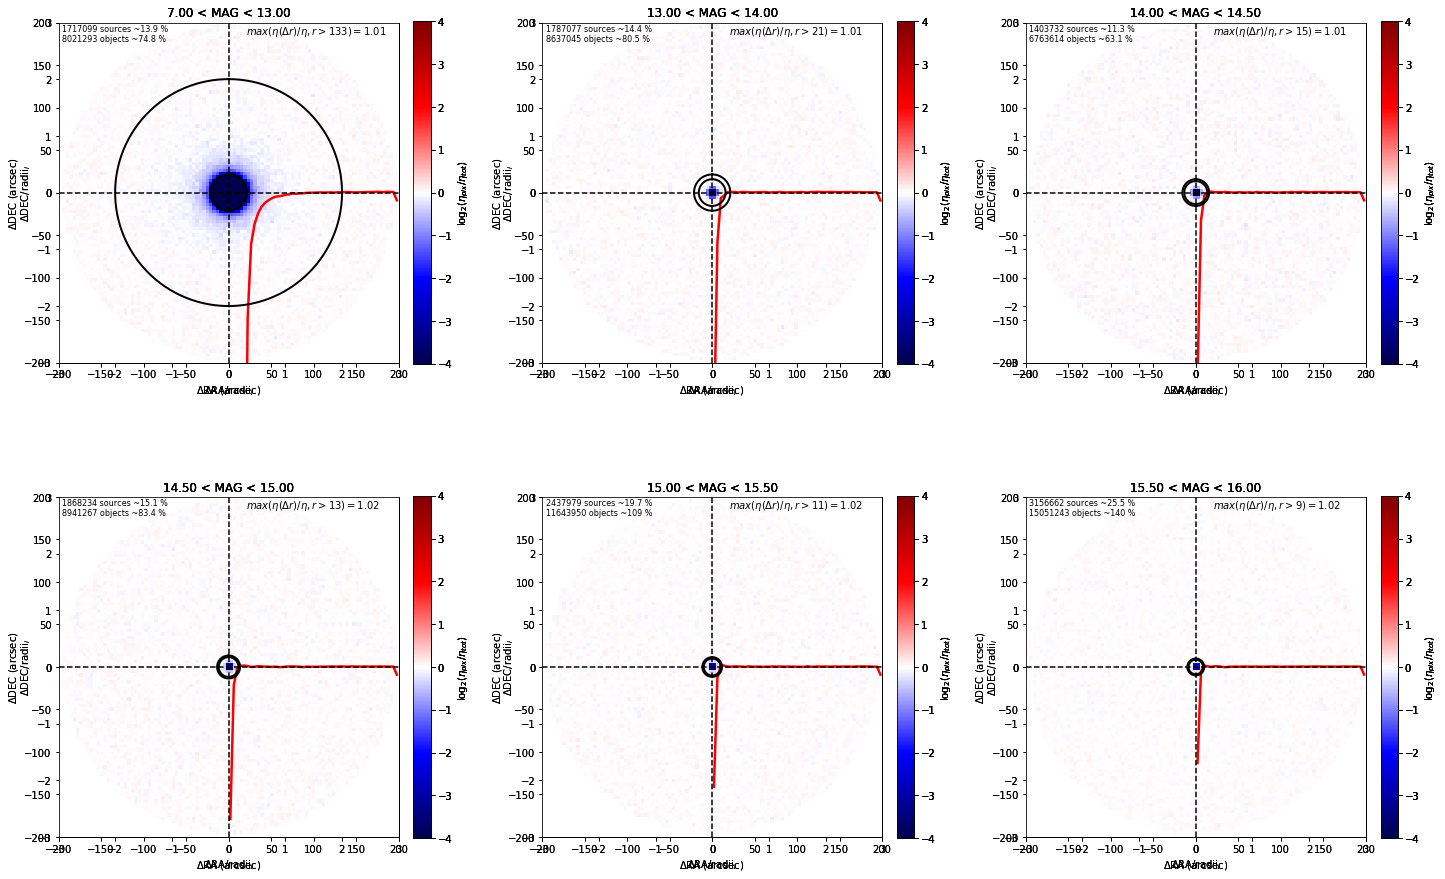

In [30]:
#Dustin_radii's
mag = np.linspace(0, 20, 50)
Dustin_MS_radii = []
for i,j in enumerate(mag):
    Dustin_MS_radii.append([j, np.minimum(1800., 150. * 2.5**((11. - j)/3.)) * 0.262/1])
    
ingaia = (cat['GAIA_PHOT_G_MEAN_MAG'] != 0)
inbgs = (maskdef_cat) & (LG_cat) & (GC_cat) & (BS_cat)
maskall = (inbgs) & (iscatreg['isdecals'])
maskallnogaia = (inbgs) & (iscatreg['isdecals']) & (~ingaia)
print('fraction of BGS in gaia: %i / %i' %(np.sum((ingaia) & (inbgs)), np.sum((inbgs))))

for scal in [True, False]:
    if scal: scalname, srmax = 'scaled', 400
    else: scalname, srmax = 'normal', 200
    
    _ = overdensity(cat[maskall], mscat, Dustin_MS_radii, 'MAG', 35, density=False, 
                        magbins=[7, 13, 14, 14.5, 15, 15.5, 16], radii_2=None, grid=[2,3], SR=[2., srmax], scaling=scal, nbins=101, 
                               SR_scaling=3,logDenRat=[-4, 4], radii_bestfit=False, annulus=None, bintype='0', 
                                   filename='2d_stack_MS_%s_all_test_%s' %(key, scalname))
    

    _ = overdensity(cat[maskallnogaia], mscat, Dustin_MS_radii, 'MAG', 35, density=False, 
                        magbins=[7, 13, 14, 14.5, 15, 15.5, 16], radii_2=None, grid=[2,3], SR=[2., srmax], scaling=scal, nbins=101, 
                               SR_scaling=3,logDenRat=[-4, 4], radii_bestfit=False, annulus=None, bintype='0', 
                                   filename='2d_stack_MS_%s_all_test_noGaia_%s' %(key, scalname))
    

### in SOUTH before default BS mask

In [27]:
from main_def import overdensity, circular_mask_radii_func

### in SOUTH after default BS mask

In [29]:
circular_mask_radii_func([], Dustin_MS_radii, bestfit=False)[0]

53.441959136868675

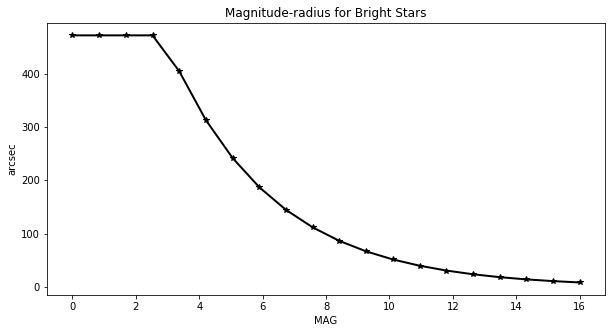

In [32]:
plt.figure(figsize=(10,5))
x = np.linspace(0, 16, 20)
plt.plot(x, np.minimum(1800., 150. * 2.5**((11. - x)/3.)) * 0.262/1, marker='*', lw=2, c='k')
plt.title(r'Magnitude-radius for Bright Stars')
plt.xlabel(r'MAG', size=18)
plt.ylabel(r'arcsec')
plt.show()


13.00 < MAG < 14.00
10546253 nearby objects ~ 78.7721 %
mag_radii MAX: 21.35708648417855 mag_radii MIN: 15.745247379763304
mag MAX: 13.999998092651367 mag MIN: 13.000000953674316
d2d min= 0, d2d max=12.7


/global/homes/q/qmxp55/.conda/envs/DESI_BGS_omar/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/global/homes/q/qmxp55/.conda/envs/DESI_BGS_omar/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-inf, 0.0295)
13 of inf in density ratio out of a total of 7556
Minimum density ratio = -6.6433, Maximum density ratio = 0.526622
----------------
14.00 < MAG < 15.00
19064940 nearby objects ~ 142.4 %
mag_radii MAX: 15.745225034392389 mag_radii MIN: 11.599834873836398
mag MAX: 14.999999046325684 mag MIN: 14.00000286102295
d2d min= 0, d2d max=17.2
density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-7.04, 0.0459)
9 of inf in density ratio out of a total of 7556
Minimum density ratio = -6.62424, Maximum density ratio = 0.473788
----------------
15.00 < MAG < 16.00
32237537 nearby objects ~ 240.789 %
mag_radii MAX: 11.599827908139646 mag_radii MIN: 8.544484463674413
mag MAX: 15.999999046325684 mag MIN: 15.000000953674316
d2d min= 0, d2d max=23.4
density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-6.77, 0.0547)
8 of inf in density ratio out of a total of 7556
Minimum density ratio = -6.50324, Max

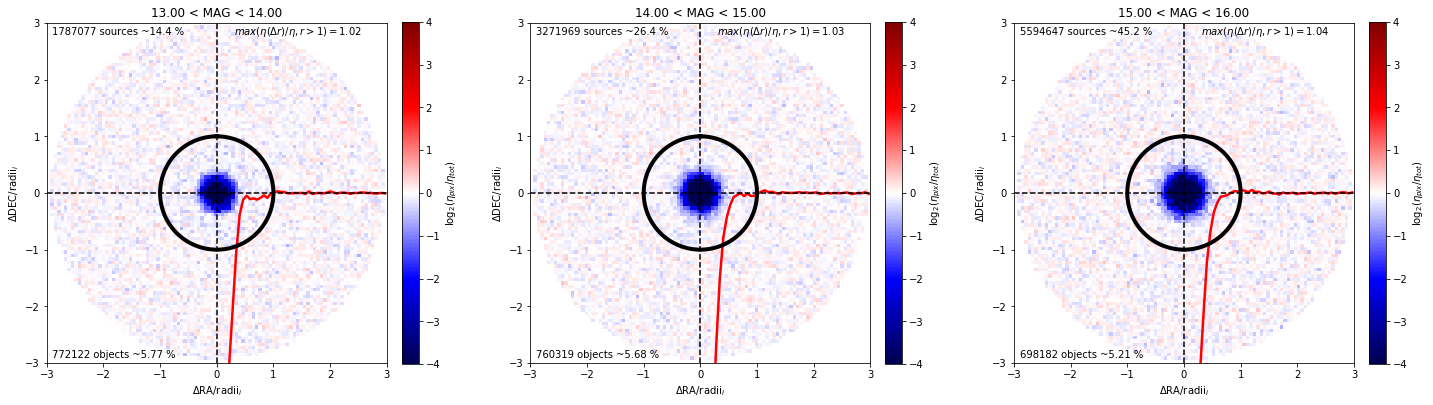

In [18]:
#Dustin_radii's
mag = np.linspace(0, 20, 50)
Dustin_MS_radii = []
for i,j in enumerate(mag):
    Dustin_MS_radii.append([j, np.minimum(1800., 150. * 2.5**((11. - j)/3.)) * 0.262/1])
    
inbgs = (maskdef_cat) & (LG_cat) & (GC_cat) & (BS_cat)
maskall = (inbgs) & (iscatsouth)

_ = overdensity(cat[maskall], mscat, Dustin_MS_radii, 'MAG', 35, density=False, 
                        magbins=[13,14,15,16], radii_2=None, grid=[1,3], SR=[0., 200.], scaling=True, nbins=101, 
                               SR_scaling=3,logDenRat=[-4, 4], radii_bestfit=False, annulus=None, bintype='0', 
                                   filename='2d_stack_MS_%s' %('south'))


## Bynary stars in GAIA (DECaLS)

In [17]:
# LS DR8 south BGS target catalogue from desitarget
# we use this catalogue because wee need information of WISE fluxes
# which have not been passed out to any of the npy target catalogues.
cat2 = fitsio.read('/global/cscratch1/sd/qmxp55/desitarget_output/targets-BGS-main-dr8.0-1-south.fits')
# get BGS Bright and Faint
bgsbright = (cat2['BGS_TARGET'] & 2**(1)) != 0
bgsfaint = (cat2['BGS_TARGET'] & 2**(0)) != 0
# get latest BGS selection
isbgs = get_bgs(cat2)
#
hppix_cat2 = hp.ang2pix(nside,(90.-np.array(cat2['DEC']))*np.pi/180.,np.array(cat2['RA'])*np.pi/180.,nest=nest) # randoms hp pixels array
#
cat2indecals = get_reg(reg='decals', hpdict=hpdict, hppix=hppix_cat2)


In [14]:
# get hppix map of masksources to extract info of regions
hppixmasksourcesfile = '/global/cscratch1/sd/qmxp55/BS_mask/hppix_dr8_masksources.npy'
is_hppixmasksourcesfile = os.path.isfile(hppixmasksourcesfile)
if is_hppixmasksourcesfile: 
    hppix_masksources = np.load(hppixmasksourcesfile)
else: 
    hppix_masksources = hp.ang2pix(nside,(90.-np.array(masksources['DEC']))*np.pi/180.,np.array(masksources['RA'])*np.pi/180.,nest=nest) # randoms hp pixels array
    np.save(hppixmasksourcesfile, hppix_masksources)


In [15]:
# get regions for masksources

ismasksourcesregfile = '/global/cscratch1/sd/qmxp55/BS_mask/inREGIONS_dr8_masksources.npy'
is_ismasksourcesregfile = os.path.isfile(ismasksourcesregfile)
if is_ismasksourcesregfile:
    ismasksourcesreg = np.load(ismasksourcesregfile)
else:
    ismasksourcesreg = {}
    regs = ['des', 'decals', 'north', 'desi', 'south']
    for i in regs:
        reg = get_reg(reg=i, hpdict=hpdict, hppix=hppix_masksources)
        ismasksourcesreg[i] = reg

    # save region info as npy file
    from astropy.table import Table
    tabreg = Table()

    for key in ismasksourcesreg.keys():
        tabreg[key] = ismasksourcesreg[key]
    
    # save astropy table as npy file
    np.save(ismasksourcesregfile, tabreg)
    

In [16]:
# get gaia catalgue in reg
masksources = np.load(inptfiles['dr8maskbitsource']) #load dr8 masksource catalogue containing GAIA, TYCHO and LSLGA objects
reg = 'decals'
gaiamask = (masksources['REF_CAT'] == b'G2') & (ismasksourcesreg[reg])
gaia = masksources[gaiamask]
print('fraction of gaia in masksources cat: %i / %i' %(np.sum(gaiamask),len(masksources)))

fraction of gaia in masksources cat: 51358119 / 125768058


In [19]:
#
idx2, idx1, d2d, d_ra, d_dec = search_around(gaia['RA'], gaia['DEC'], 
                                             gaia['RA'], gaia['DEC'], search_radius=4.)


58173561 nearby objects ~ 113.27 %


fraction of inf values in rmag: 398135 / 402093


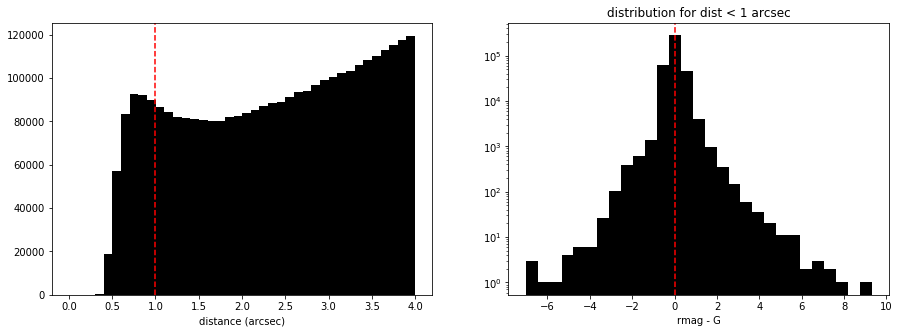

In [20]:
#
plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
plt.hist(d2d[d2d > 0], 40, color='k')
plt.axvline(1.0, ls='--', c='r')
plt.xlabel(r'distance (arcsec)')

plt.subplot(1,2,2)
dist2 = (d2d > 0) & (d2d < 1.0)
dist2idx = np.unique(idx2[dist2])

xr = (gaia['RMAG']-gaia['G'])[dist2idx]
#xr = (gaia['RMAG'])[dist2idx]
xrmask = np.isfinite(xr)
bins = np.linspace(xr[xrmask].min(), xr[xrmask].max(), 30)
plt.hist(xr[xrmask], bins=bins, color='k', log=True)
plt.axvline(0, ls='--', c='r')
plt.title(r'distribution for dist < 1 arcsec')
plt.xlabel(r'rmag - G')

print('fraction of inf values in rmag: %i / %i' %(np.sum(xrmask), len(xr)))


In [165]:
#
def find_nearest(array, value, delta):
    
    import random
    
    array = np.asarray(array)
    #idx = (np.abs(array - value)).argmin()
    #idx = (np.abs(array - value))
    a = np.logical_and(array < value + delta, array > value - delta)
    a &= (array != value)
    idx = list(np.where(a))[0]
    return array[random.choice(idx)], idx


In [224]:
def get_catbgspairs(minl=0, maxl=1):
    
    #
    dist2idx = np.unique(idx2[(d2d > minl) & (d2d < maxl)])

    inbgs = ((bgsbright) | (bgsfaint)) & (isbgs)
    maskall = (inbgs) & (cat2indecals)

    idx2_1, idx1_1, d2d_1, d_ra_1, d_dec_1 = search_around(cat2['RA'][maskall], cat2['DEC'][maskall], 
                                             gaia['RA'][dist2idx], gaia['DEC'][dist2idx], search_radius=maxl)
    
    print('BGS close to GAIA pairs... DONE...')
    
    #
    if False:
        plt.hist(d2d_1[d2d_1 > 0], 40, color='k')
        plt.axvline(1.0, ls='--', c='r')
        plt.xlabel(r'distance (arcsec)')
        plt.show()
    
    #
    print('GAIA binary max, min distance: %i,%i arcsec' %(minl, maxl))
    print('BGS maximum distance to a GAIA binary: %i arcsec' %(maxl))
    print('\t total bgs close to a GAIA binary: %i' %(len(np.unique(idx2_1))))
    print('\t total bgs close to a GAIA binary with d == 0: %i' %(len(np.unique(idx2_1[d2d_1 == 0]))))
    print('\t total bgs close to a GAIA binary with d > 0: %i' %(len(np.unique(idx2_1[d2d_1 > 0]))))

    # creating new catalogue with BGS close to GAIA pairs
    from astropy.table import Table, vstack
    import time
    import progressbar

    bgsinpairs = cat2[maskall][idx2_1[d2d_1 > 0]]
    gaiapairs = gaia[dist2idx]
    
    widgets = ['\x1b[32mProgress...\x1b[39m', progressbar.Percentage(),progressbar.Bar(markers='\x1b[32m$\x1b[39m')]
    bar = progressbar.ProgressBar(widgets=widgets, max_value=len(bgsinpairs['RA'])).start()
    
    #
    rmag = flux_to_mag(cat2['FLUX_R'][maskall]/cat2['MW_TRANSMISSION_R'][maskall])
    rmaginpairs = flux_to_mag(bgsinpairs['FLUX_R']/bgsinpairs['MW_TRANSMISSION_R'])
    
    nums = 10
    control = np.zeros((nums, len(rmag)),dtype='?')
    for num, i in enumerate(rmaginpairs):
        _, idx = find_nearest(rmag, i, 0.01)
        if len(idx) < 1:
            time.sleep(0.1)
            bar.update(num + 1)
            continue
        elif (len(idx) < nums): ransamp = list(np.full(nums, idx[0]))
        else: ransamp = random.sample(list(idx), nums)
        control[np.arange(0, nums, 1),ransamp] = True
        
        time.sleep(0.1)
        bar.update(num + 1)
        
    cols = ['RA', 'DEC', 'RMAG', 'G', 'REF_CAT', 'isBGS', 'isGAIA']
    tabbgs, tabgaia, tab = Table(), Table(), Table()
    
    #print('Creating tab...')
        
    for col in cols:
        isBGS = np.ones_like(bgsinpairs['RA'], dtype='?')
        if col == 'isBGS': tabbgs[col] = isBGS
        elif col == 'isGAIA': tabbgs[col] = ~isBGS
        elif col == 'G': tabbgs[col] = bgsinpairs['GAIA_PHOT_G_MEAN_MAG']
        elif col == 'RMAG': tabbgs[col] = flux_to_mag(bgsinpairs['FLUX_R']/bgsinpairs['MW_TRANSMISSION_R'])
        else: tabbgs[col] = bgsinpairs[col]
        
    for col in cols:
        isGAIA = np.ones_like(gaiapairs['RA'], dtype='?')
        if col == 'isBGS': tabgaia[col] = ~isGAIA
        elif col == 'isGAIA': tabgaia[col] = isGAIA
        else: tabgaia[col] = gaiapairs[col]
    
    tab = vstack([tabbgs, tabgaia])
    
    print('TAB created...')
    
    return tab, control, maskall, bgsinpairs, gaiapairs


In [225]:
#
results = {}
a = np.linspace(0, 4, 9)
for i, j in enumerate(a[:-1]):
    
    print('min=%f, max=%f' %(j, a[i+1]))
    tab, control, maskall, bgsinpairs, gaiapairs = get_catbgspairs(minl=j, maxl=a[i+1])
    
    results['tab_%s_%s' %(str(j), str(a[i+1]))] = tab
    results['control_%s_%s' %(str(j), str(a[i+1]))] = control
    results['maskall_%s_%s' %(str(j), str(a[i+1]))] = maskall
    results['bgsinpairs_%s_%s' %(str(j), str(a[i+1]))] = bgsinpairs
    results['gaiapairs_%s_%s' %(str(j), str(a[i+1]))] = gaiapairs
    

min=0.000000, max=0.500000
70 nearby objects ~ 0.425403 %
BGS close to GAIA pairs... DONE...
GAIA binary max, min distance: 0,0 arcsec
BGS maximum distance to a GAIA binary: 0 arcsec
	 total bgs close to a GAIA binary: 33
	 total bgs close to a GAIA binary with d == 0: 33
	 total bgs close to a GAIA binary with d > 0: 33


Progress...100%|####################################################|

TAB created...
min=0.500000, max=1.000000
1914 nearby objects ~ 0.496273 %
BGS close to GAIA pairs... DONE...
GAIA binary max, min distance: 0,1 arcsec
BGS maximum distance to a GAIA binary: 1 arcsec
	 total bgs close to a GAIA binary: 904
	 total bgs close to a GAIA binary with d == 0: 902
	 total bgs close to a GAIA binary with d > 0: 904


Progress...100%|####################################################|

TAB created...
min=1.000000, max=1.500000
3420 nearby objects ~ 0.882396 %
BGS close to GAIA pairs... DONE...
GAIA binary max, min distance: 1,1 arcsec
BGS maximum distance to a GAIA binary: 1 arcsec
	 total bgs close to a GAIA binary: 1625
	 total bgs close to a GAIA binary with d == 0: 1610
	 total bgs close to a GAIA binary with d > 0: 1625


Progress... 98%|################################################### |

TAB created...
min=1.500000, max=2.000000
4691 nearby objects ~ 1.246 %
BGS close to GAIA pairs... DONE...
GAIA binary max, min distance: 1,2 arcsec
BGS maximum distance to a GAIA binary: 2 arcsec
	 total bgs close to a GAIA binary: 2269
	 total bgs close to a GAIA binary with d == 0: 2224
	 total bgs close to a GAIA binary with d > 0: 2269


Progress...100%|####################################################|

TAB created...
min=2.000000, max=2.500000
5970 nearby objects ~ 1.49687 %
BGS close to GAIA pairs... DONE...
GAIA binary max, min distance: 2,2 arcsec
BGS maximum distance to a GAIA binary: 2 arcsec
	 total bgs close to a GAIA binary: 2922
	 total bgs close to a GAIA binary with d == 0: 2790
	 total bgs close to a GAIA binary with d > 0: 2922


Progress...100%|####################################################|

TAB created...
min=2.500000, max=3.000000
7187 nearby objects ~ 1.65853 %
BGS close to GAIA pairs... DONE...
GAIA binary max, min distance: 2,3 arcsec
BGS maximum distance to a GAIA binary: 3 arcsec
	 total bgs close to a GAIA binary: 3586
	 total bgs close to a GAIA binary with d == 0: 3267
	 total bgs close to a GAIA binary with d > 0: 3586


Progress...100%|####################################################|

TAB created...
min=3.000000, max=3.500000
8746 nearby objects ~ 1.85075 %
BGS close to GAIA pairs... DONE...
GAIA binary max, min distance: 3,3 arcsec
BGS maximum distance to a GAIA binary: 3 arcsec
	 total bgs close to a GAIA binary: 4446
	 total bgs close to a GAIA binary with d == 0: 3871
	 total bgs close to a GAIA binary with d > 0: 4446


Progress... 98%|################################################### |

TAB created...
min=3.500000, max=4.000000
10434 nearby objects ~ 2.00891 %
BGS close to GAIA pairs... DONE...
GAIA binary max, min distance: 3,4 arcsec
BGS maximum distance to a GAIA binary: 4 arcsec
	 total bgs close to a GAIA binary: 5403
	 total bgs close to a GAIA binary with d == 0: 4421
	 total bgs close to a GAIA binary with d > 0: 5403


Progress...100%|####################################################|

TAB created...


In [95]:
#
def plot_results(bgsinpairs=None, control=None, maskall=None, gaiapairs=None, n=1, plottype='rmag', title=None, lab=True):
    
    # initializing plots
    ax = fig.add_subplot(gs[n])
    
    from main_def import get_mag_decals
    g, r, z, w1, G, rr, AEN, galb, finite = get_mag_decals(cat2[maskall])
    g2, r2, z2, w12, G2, rr2, AEN2, galb2, finite2 = get_mag_decals(bgsinpairs)
    wise_color = z - w1 - (g - r)
    wise_color2 = z2 - w12 - (g2 - r2)
    wz = w1 - z
    wz2 = w12 - z2
    gr = (g - r)
    rz = (r - z)
    gr2 = (g2 - r2)
    rz2 = (r2 - z2)
    Grr = G - rr
    Grr2 = G2 - rr2
    gz = g - z
    gz2 = g2 - z2
    
    Nbgsinpairs = len(bgsinpairs)
    Ngaiapairs = len(gaiapairs)
    f = Nbgsinpairs / Ngaiapairs
    
    #settings
    colour_control = 'k'
    s_control = 2
    colour_bgsinpairs = 'r'
    alpha_bgsinpairs = 0.2
    s_bgsinpairs = 2
    
    if title is not None: ax.set_title(r'%s, Nbgs=%i, f=%2.3g' %(title, Nbgsinpairs, f), size=10)
    if lab: label1, label2 = r'bgs control', r'bgs in pairs'
    else: label1, label2 = None, None
        
    if plottype == 'rmag':
        bins = np.linspace(14, 20, 25)
        for i in range(len(control)):
            if (i == 0) & (lab):label1 = r'bgs control'
            else: label1 = None
            ax.hist(r[(control[i]) & (finite)], bins=bins, histtype='step', color=colour_control, alpha=0.8, label=label1)
        ax.hist(r2[finite2], bins=bins, histtype='step', color=colour_bgsinpairs , lw=1.5, label=label2)
    
        ax.set_xlabel(r'rmag', size=15)
    #-------------------------------------------------

    elif plottype == 'wise':
        bins = np.linspace(-4.5, 2.5, 30)

        for i in range(len(control)):
            if (i == 0) & (lab):label1 = r'bgs control'
            else: label1 = None
            ax.hist(wise_color[(control[i]) & (finite)], bins=bins, histtype='step', color=colour_control, alpha=0.8, label=label1)
        ax.hist(wise_color2[finite2], bins=bins, histtype='step', color=colour_bgsinpairs , lw=1.5, label=label2)

        ax.set_xlabel(r'z-w-(g-r)', size=15)
        
    #-------------------------------------------------

    elif plottype == 'wz':
        bins = np.linspace(-2.5, 4, 30)

        for i in range(len(control)):
            if (i == 0) & (lab):label1 = r'bgs control'
            else: label1 = None
            ax.hist(wz[(control[i]) & (finite)], bins=bins, histtype='step', color=colour_control, alpha=0.8, label=label1)
        ax.hist(wz2[finite2], bins=bins, histtype='step', color=colour_bgsinpairs , lw=1.5, label=label2)

        ax.set_xlabel(r'z-w-(g-r)', size=15)
    #-------------------------------------------------
    
    elif plottype == 'gr':
        bins = np.linspace(-1, 2.2, 30)

        for i in range(len(control)):
            if (i == 0) & (lab):label1 = r'bgs control'
            else: label1 = None
            ax.hist(gr[(control[i]) & (finite)], bins=bins, histtype='step', color=colour_control, alpha=0.8, label=label1)
        ax.hist(gr2[finite2], bins=bins, histtype='step', color=colour_bgsinpairs , lw=1.5, label=label2)

        ax.set_xlabel(r'g-r', size=15)
        
    #-------------------------------------------------
    
    elif plottype == 'galb':
        #bins = np.linspace(-1, 2.2, 30)

        for i in range(len(control)):
            if (i == 0) & (lab):label1 = r'bgs control'
            else: label1 = None
            ax.hist(galb[(control[i]) & (finite)], bins=30, histtype='step', color=colour_control, alpha=0.8, label=label1)
        ax.hist(galb2[finite2], bins=30, histtype='step', color=colour_bgsinpairs , lw=1.5, label=label2)

        ax.set_xlabel(r'gal b', size=15)
        
    #-------------------------------------------------
    
    elif plottype == 'gz':
        bins = np.linspace(-1, 4, 30)

        for i in range(len(control)):
            if (i == 0) & (lab):label1 = r'bgs control'
            else: label1 = None
            ax.hist(gz[(control[i]) & (finite)], bins=bins, histtype='step', color=colour_control, alpha=0.8, label=label1)
        ax.hist(gz2[finite2], bins=bins, histtype='step', color=colour_bgsinpairs , lw=1.5, label=label2)

        ax.set_xlabel(r'g-z', size=15)
    #-------------------------------------------------
    
    elif plottype == 'Grr':
        bins = np.linspace(-1, 4.5, 30)

        for i in range(len(control)):
            if (i == 0) & (lab):label1 = r'bgs control'
            else: label1 = None
            ax.hist(Grr[(control[i]) & (finite)], bins=bins, histtype='step', color=colour_control, alpha=0.8, label=label1)
        ax.hist(Grr2[finite2], bins=bins, histtype='step', color=colour_bgsinpairs , lw=1.5, label=label2)
        ax.axvline(0.6, ls='--', c='b')

        ax.set_xlabel(r'G-rr', size=15)
    #-------------------------------------------------
    
    elif plottype == 'rz':
        bins = np.linspace(-1, 2.2, 30)

        for i in range(len(control)):
            if (i == 0) & (lab):label1 = r'bgs control'
            else: label1 = None
            ax.hist(rz[(control[i]) & (finite)], bins=bins, histtype='step', color=colour_control, alpha=0.8, label=label1)
        ax.hist(rz2[finite2], bins=bins, histtype='step', color=colour_bgsinpairs , lw=1.5, label=label2)

        ax.set_xlabel(r'r-z', size=15)
    #-------------------------------------------------

    elif plottype == 'gr-rz':

        ax.scatter(gr[(control[1]) & (finite)], rz[(control[1]) & (finite)], s=s_control, color=colour_control, label=label1)
        ax.scatter(gr2[finite2], rz2[finite2], s=s_bgsinpairs, color=colour_bgsinpairs, alpha=alpha_bgsinpairs, label=label2)

        ax.set_xlabel(r'g-r', size=15)
        ax.set_ylabel(r'r-z', size=15)
        ax.set_xlim(-1, 2.2)
        ax.set_ylim(-1, 2.2)
    
    #-------------------------------------------------

    elif plottype == 'gr-wise':

        ax.scatter(gr[(control[1]) & (finite)], wise_color[(control[1]) & (finite)], s=s_control, color=colour_control, label=label1)
        ax.scatter(gr2[finite2], wise_color2[finite2], s=s_bgsinpairs, color=colour_bgsinpairs, alpha=alpha_bgsinpairs, label=label2)

        ax.set_xlabel(r'g-r', size=15)
        ax.set_ylabel(r'z-w-(g-r)', size=15)
        ax.set_xlim(-1, 2.2)
        ax.set_ylim(-4.5, 2.5)
        
    #-------------------------------------------------

    elif plottype == 'gr-wz':

        ax.scatter(gr[(control[1]) & (finite)], wz[(control[1]) & (finite)], s=s_control, color=colour_control, label=label1)
        ax.scatter(gr2[finite2], wz2[finite2], s=s_bgsinpairs, color=colour_bgsinpairs, alpha=alpha_bgsinpairs, label=label2)

        ax.set_xlabel(r'g-r', size=15)
        ax.set_ylabel(r'w-z', size=15)
        ax.set_xlim(-1, 2.2)
        ax.set_ylim(-2.5, 4)
        
    #-------------------------------------------------

    elif plottype == 'gz-Grr':

        ax.scatter(gz[(control[1]) & (finite)], Grr[(control[1]) & (finite)], s=s_control, color=colour_control, label=label1)
        ax.scatter(gz2[finite2], Grr2[finite2], s=s_bgsinpairs, color=colour_bgsinpairs, alpha=alpha_bgsinpairs, label=label2)

        ax.set_xlabel(r'g-z', size=15)
        ax.set_ylabel(r'G-rr', size=15)
        ax.set_xlim(-1, 4)
        ax.set_ylim(-1, 4.5)
        
    #-------------------------------------------------

    elif plottype == 'G-AEN':

        ax.scatter(G[(control[1]) & (finite)], np.log(AEN[(control[1]) & (finite)]), s=s_control, color=colour_control, label=label1)
        ax.scatter(G2[finite2], np.log(AEN2[finite2]), s=s_bgsinpairs, color=colour_bgsinpairs, alpha=alpha_bgsinpairs, label=label2)
        
        ax.axvline(19, c='gray', linestyle='--', alpha=1)
        ax.plot(np.linspace(16, 19, 3), np.full(3, 0.5), c='b', linestyle='--')
        x2 = np.linspace(19, 22, 3)
        ax.plot(x2, (0.5 + 0.2*(x2 - 19.)), c='b', linestyle='--')

        ax.set_xlabel(r'G', size=15)
        ax.set_ylabel(r'$\log(AEN)$', size=15)
        ax.set_xlim(16, 22)
        ax.set_ylim(-2, 4)
        
    if lab: ax.legend(loc='upper left')



In [34]:
#np.save('/global/homes/q/qmxp55/DESI/BGS_paper/results_decals/results_bgs_in_gaia_pairs.npy', results)
results = np.load('/global/cscratch1/sd/qmxp55/results_bgs_in_gaia_pairs.npy',allow_pickle='TRUE').item()

Progress...100%|####################################################|


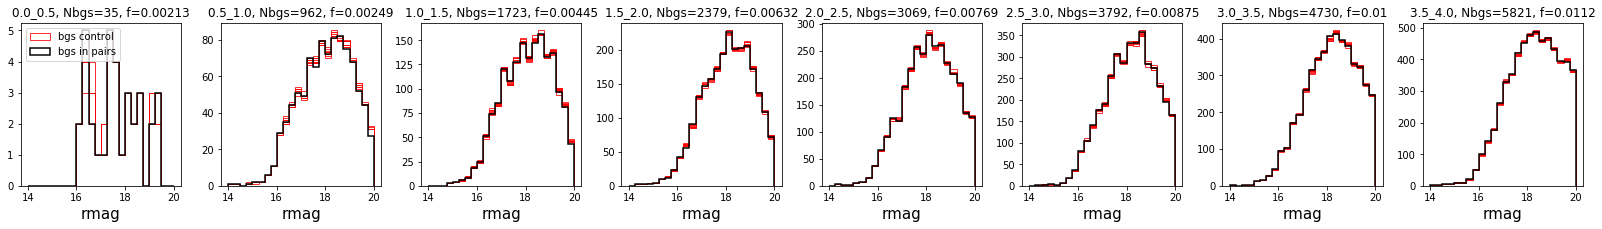

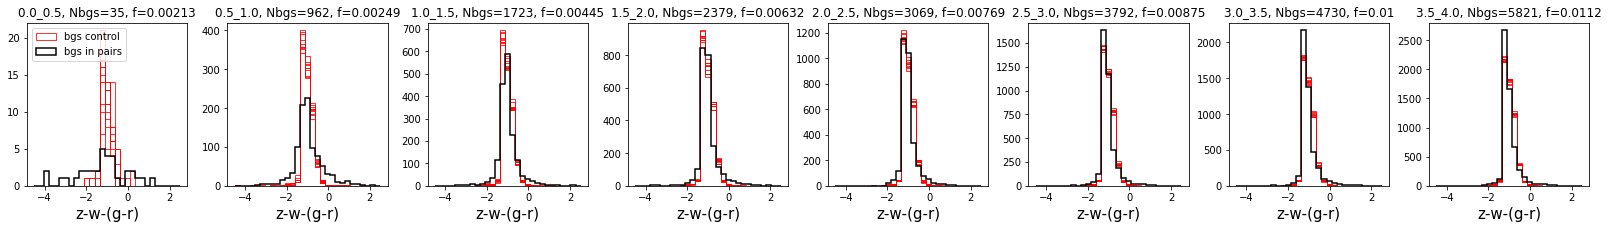

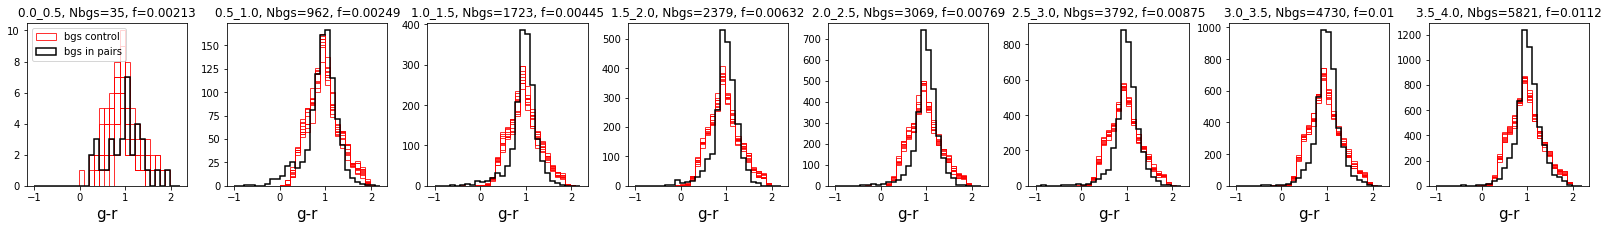

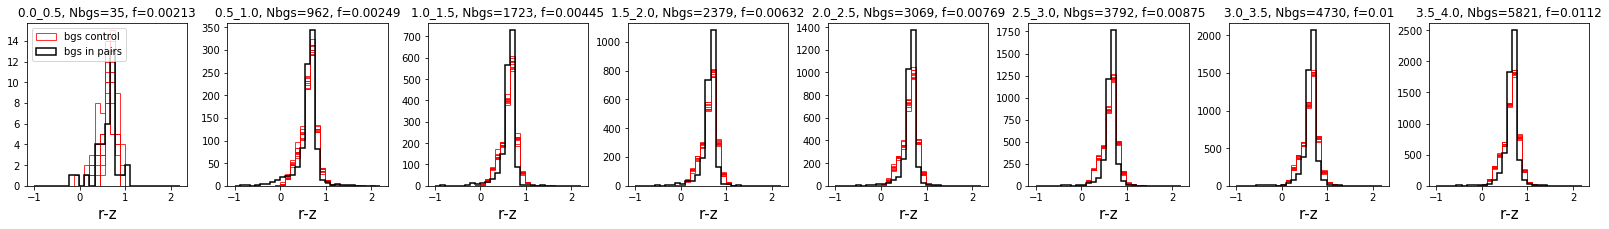

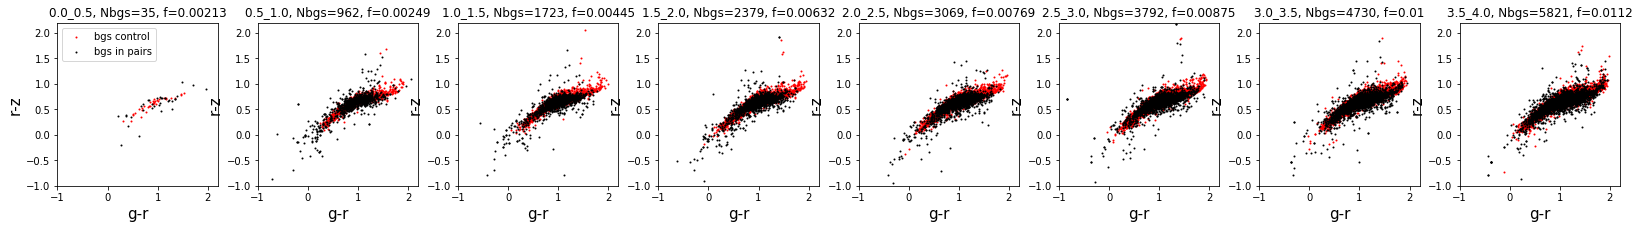

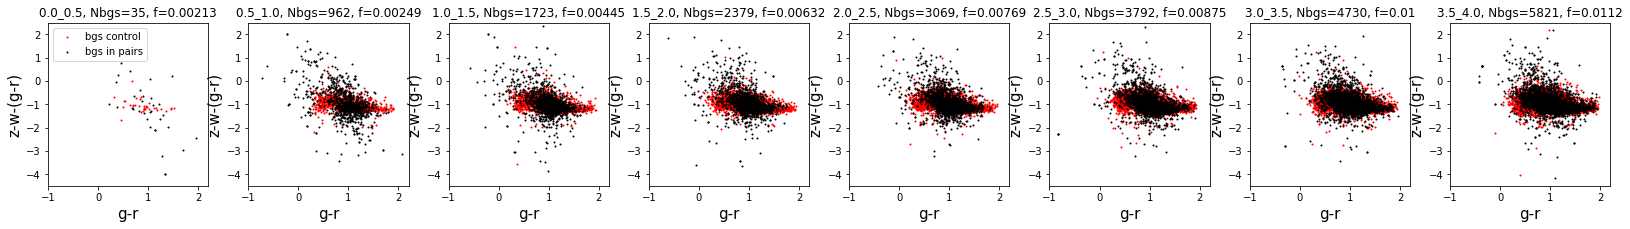

In [62]:
#    
import time
import progressbar

a, b= np.linspace(0, 4, 9), []
for i, j in enumerate(a[:-1]):
    b.append('%s_%s' %(str(j), str(a[i+1])))
    
plottypes = ['rmag', 'wise', 'gr', 'rz', 'gr-rz', 'gr-wise']
cols = 8

widgets = ['\x1b[32mProgress...\x1b[39m', progressbar.Percentage(),progressbar.Bar(markers='\x1b[32m$\x1b[39m')]
bar = progressbar.ProgressBar(widgets=widgets, max_value=cols*len(plottypes)).start()
j = 0
for plottype in plottypes:
    
    fig = plt.figure(figsize=(3.5*cols,3))
    gs = gridspec.GridSpec(1,cols,hspace=0.20,wspace=0.25)
    
    for num, key in enumerate(b[:cols]):
        #
        if num == 0: lab = True
        else: lab = False
        plot_results(bgsinpairs=results['bgsinpairs_'+key], control=results['control_'+key], 
                     maskall=results['maskall_'+key], gaiapairs=results['gaiapairs_'+key], n=num, plottype=plottype, title=key, lab=lab)
        
        time.sleep(0.1)
        bar.update(j + 1)
        j += 1
        
bar.finish()
    

Progress...100%|####################################################|


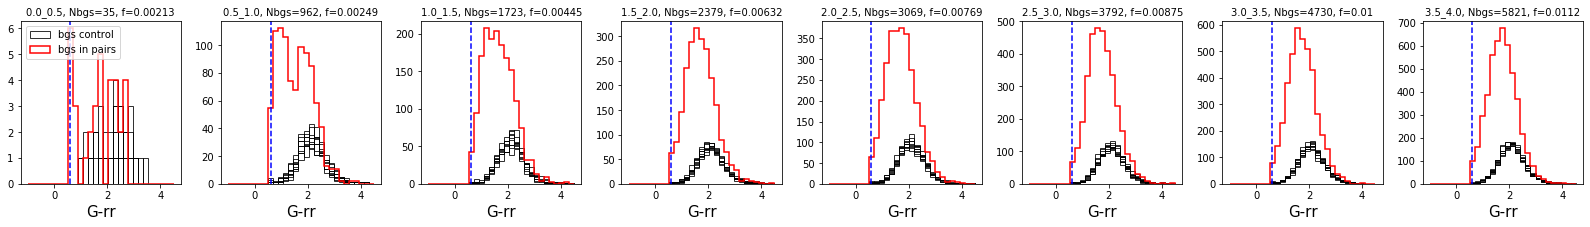

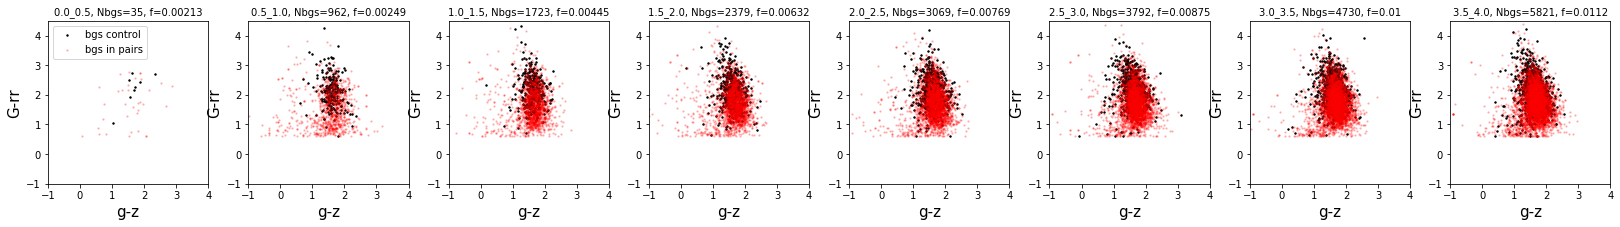

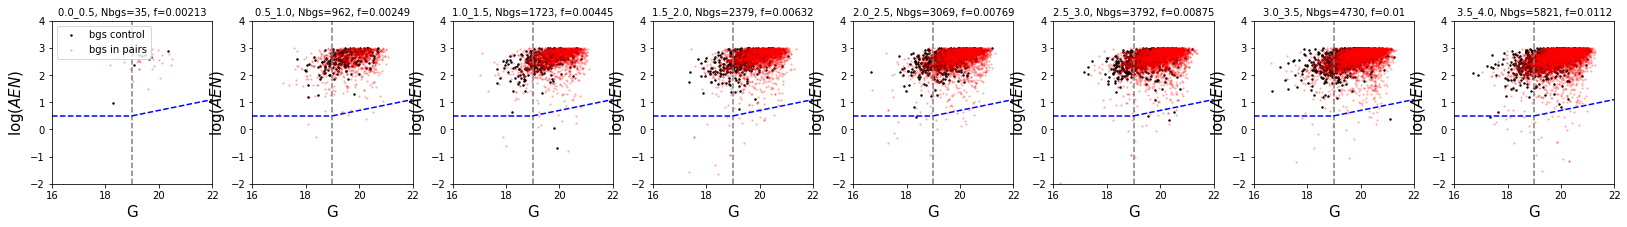

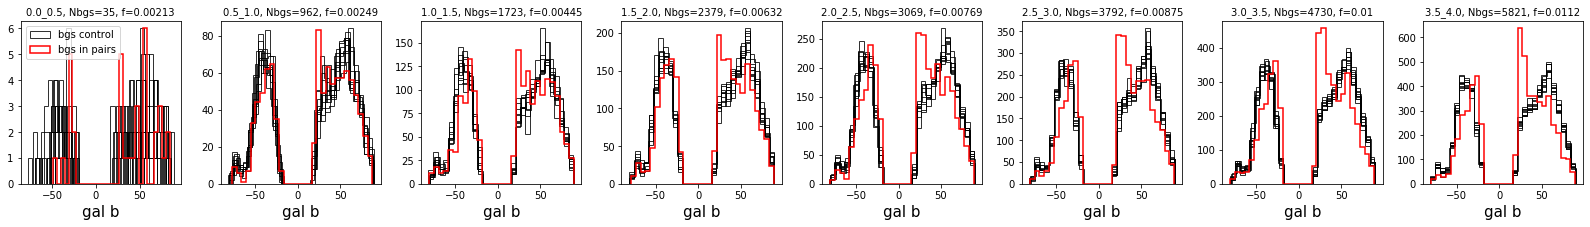

In [98]:
#    
import time
import progressbar

a, b= np.linspace(0, 4, 9), []
for i, j in enumerate(a[:-1]):
    b.append('%s_%s' %(str(j), str(a[i+1])))
    
plottypes = ['Grr', 'gz-Grr', 'G-AEN', 'galb']
#plottypes = ['galb']
cols = 8

widgets = ['\x1b[32mProgress...\x1b[39m', progressbar.Percentage(),progressbar.Bar(markers='\x1b[32m$\x1b[39m')]
bar = progressbar.ProgressBar(widgets=widgets, max_value=cols*len(plottypes)).start()
j = 0
for plottype in plottypes:
    
    fig = plt.figure(figsize=(3.5*cols,3))
    gs = gridspec.GridSpec(1,cols,hspace=0.20,wspace=0.25)
    
    for num, key in enumerate(b[:cols]):
        #
        if num == 0: lab = True
        else: lab = False
        plot_results(bgsinpairs=results['bgsinpairs_'+key], control=results['control_'+key], 
                     maskall=results['maskall_'+key], gaiapairs=results['gaiapairs_'+key], n=num, plottype=plottype, title=key, lab=lab)
        
        time.sleep(0.1)
        bar.update(j + 1)
        j += 1
        
bar.finish()
    

In [35]:
#
a, b= np.linspace(0, 4, 9), []
for i, j in enumerate(a[:-1]):
    b.append('%s_%s' %(str(j), str(a[i+1])))
    
nbgspairs = 0
for num, key in enumerate(b):
    #
    nbgspairs += len(results['bgsinpairs_'+key])

print('total BGS close to GAIA binaries with separation < 4 arcsec: %i' %(nbgspairs))
print('density of BGS pairs: %f' %(nbgspairs/hpdict['bgsarea_decals']))


total BGS close to GAIA binaries with separation < 4 arcsec: 22511
density of BGS pairs: 2.707685


Progress...100%|####################################################|
Progress...100%|####################################################|
Progress...100%|####################################################|
Progress...100%|####################################################|
Progress...100%|####################################################|
Progress...100%|####################################################|
Progress...100%|####################################################|
Progress...100%|####################################################|


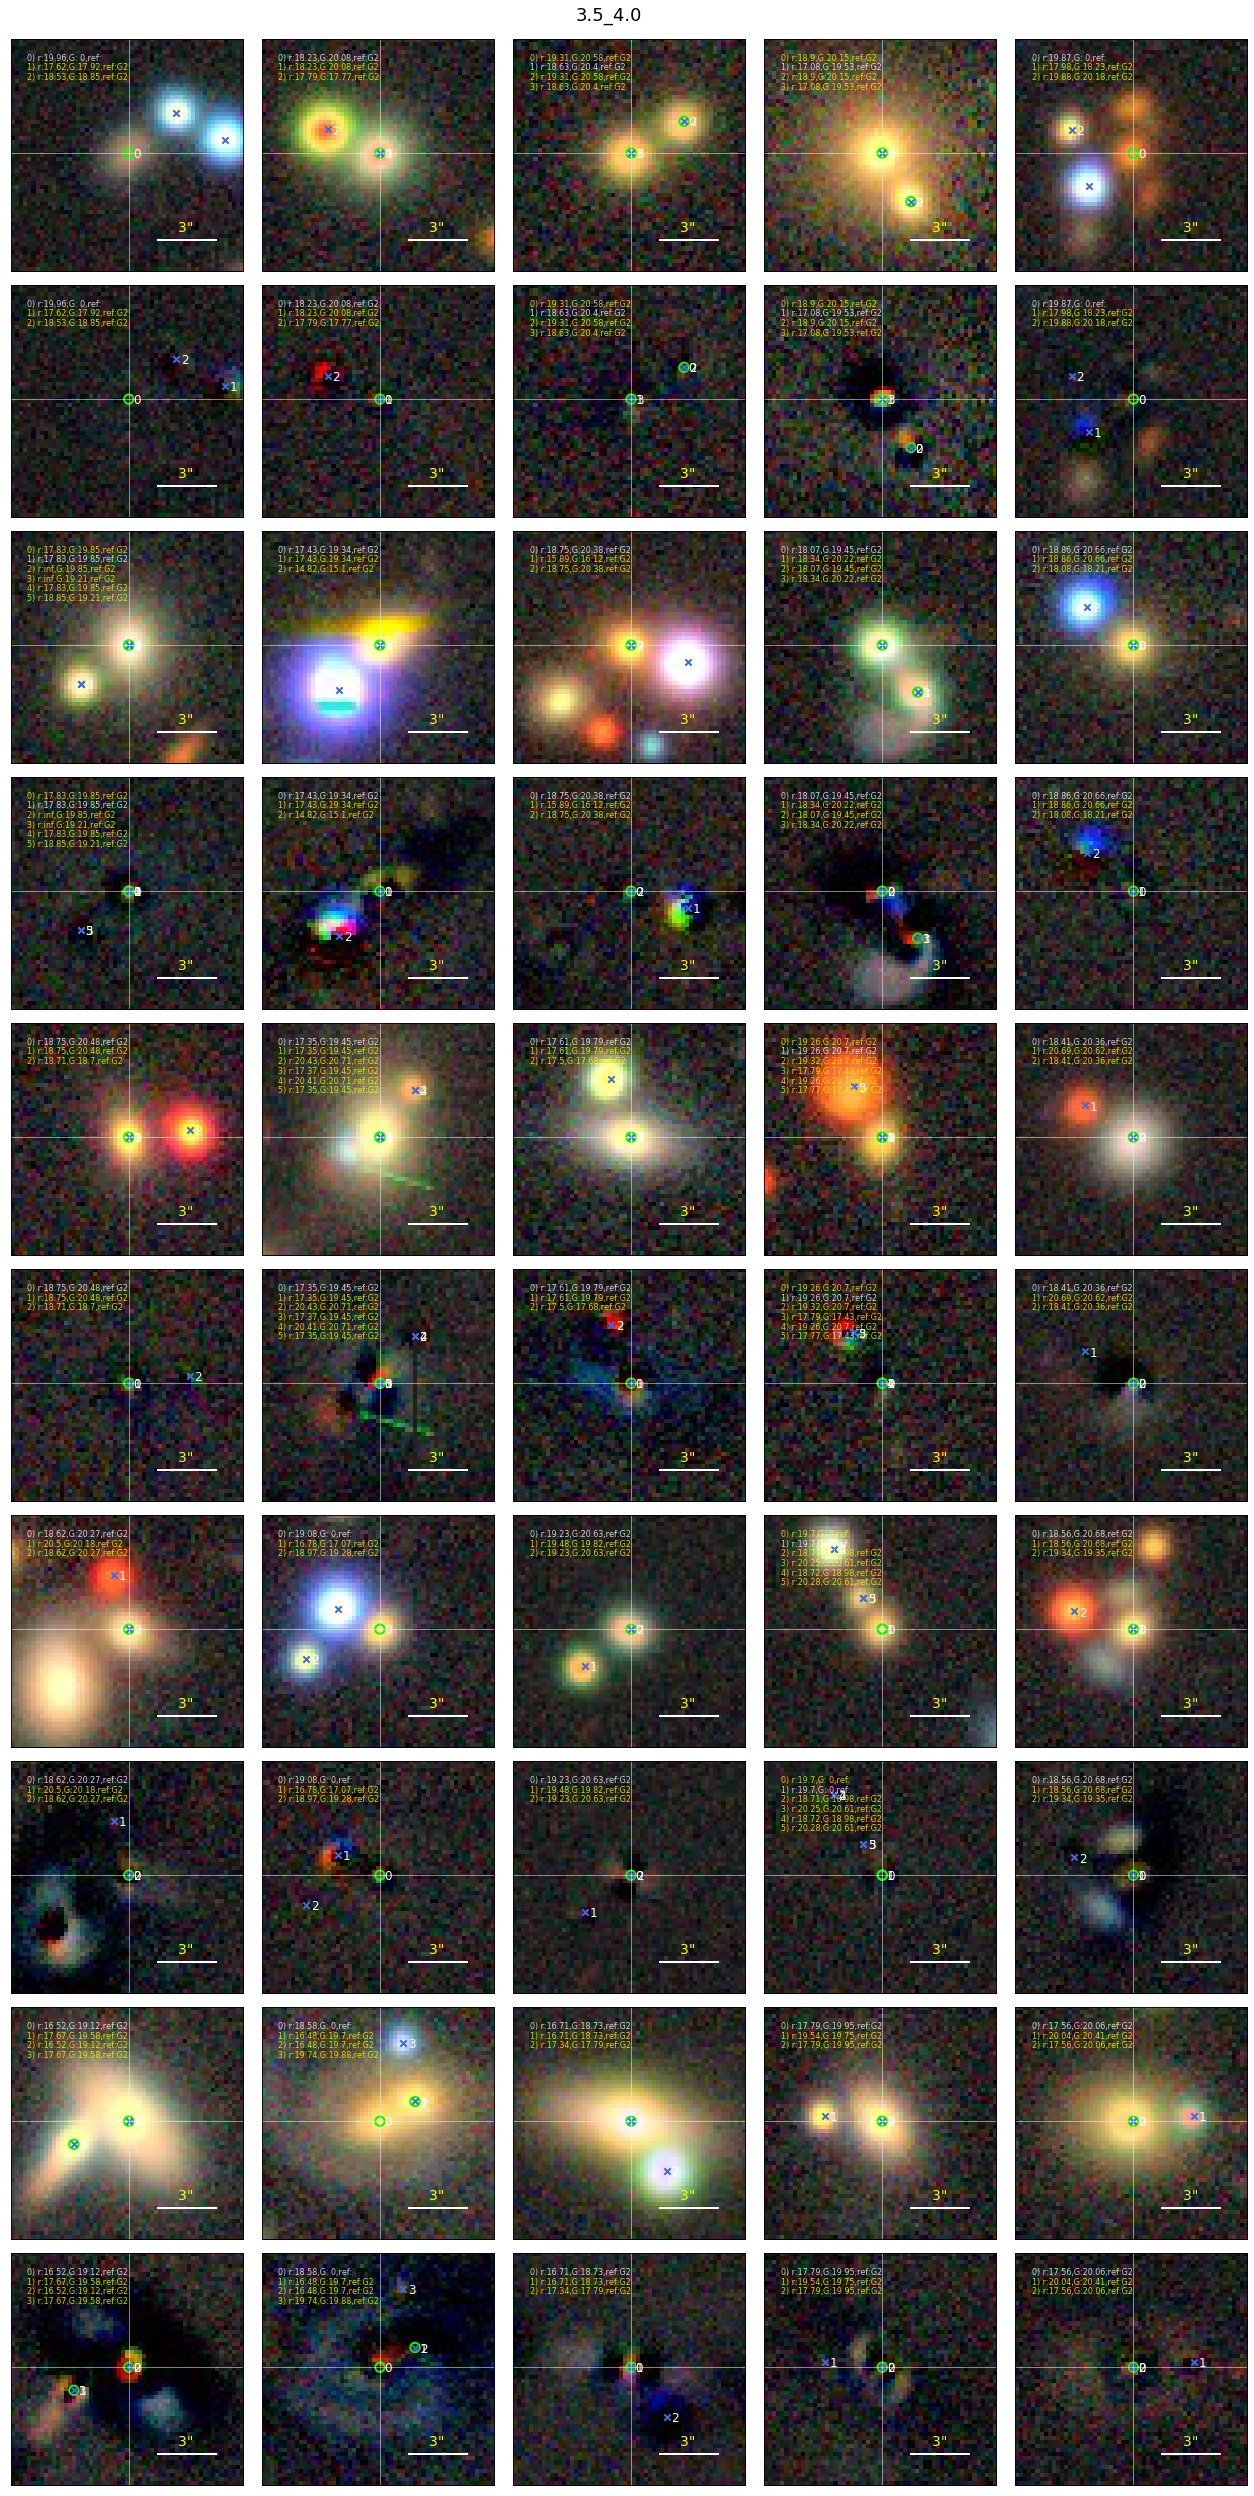

In [100]:

from postages_images import postages_circle

a, b= np.linspace(0, 4, 9), []
for i, j in enumerate(a[:-1]):
    b.append('%s_%s' %(str(j), str(a[i+1])))
    
for num, key in enumerate(b):
    
    tab = results['tab_'+key]
    #Get the postages...
    #bright, faint = (cat['RMAG'][maskall] < 19.5), np.logical_and(cat['RMAG'][maskall] < 20.0, cat['RMAG'][maskall] > 19.5)
    veto = {'isBGS':tab['isBGS'], 'isGAIA':tab['isGAIA']}
    info = {'r':tab['RMAG'], 'G':tab['G'], 'ref':tab['REF_CAT'].astype(str)}
    layer_dr7='decals-dr7'
    layer_dr8='dr8'
    #'dr8-model'
    #'dr8-resid'

    #indexes of BGS & LRG overlap
    idx = list(np.where((tab['isBGS'])))[0]

    #if we want to compare the same objects with another catalogue (i.e., DR7, DR8) select only
    #the right number of indexes as your grid to avoid the random selection in postages_circle.
    postages_circle(coord=[tab['RA'], tab['DEC']], centeridx=idx, veto=veto, info=info, scale=0.262, 
                scale_unit='pixscale', layer=layer_dr8, radius=1.5/3600., m=5, grid=[5,5], 
                    savefile='bgs_close_to_gaia_binaries_%s' %(key), layer2='dr8-resid', layer2Mode='merge', 
                        isLG=False, title=key, markers=True, colorkey=False)


Colour key:
	 bright --> lime
	 faint --> royalblue
	 other --> red


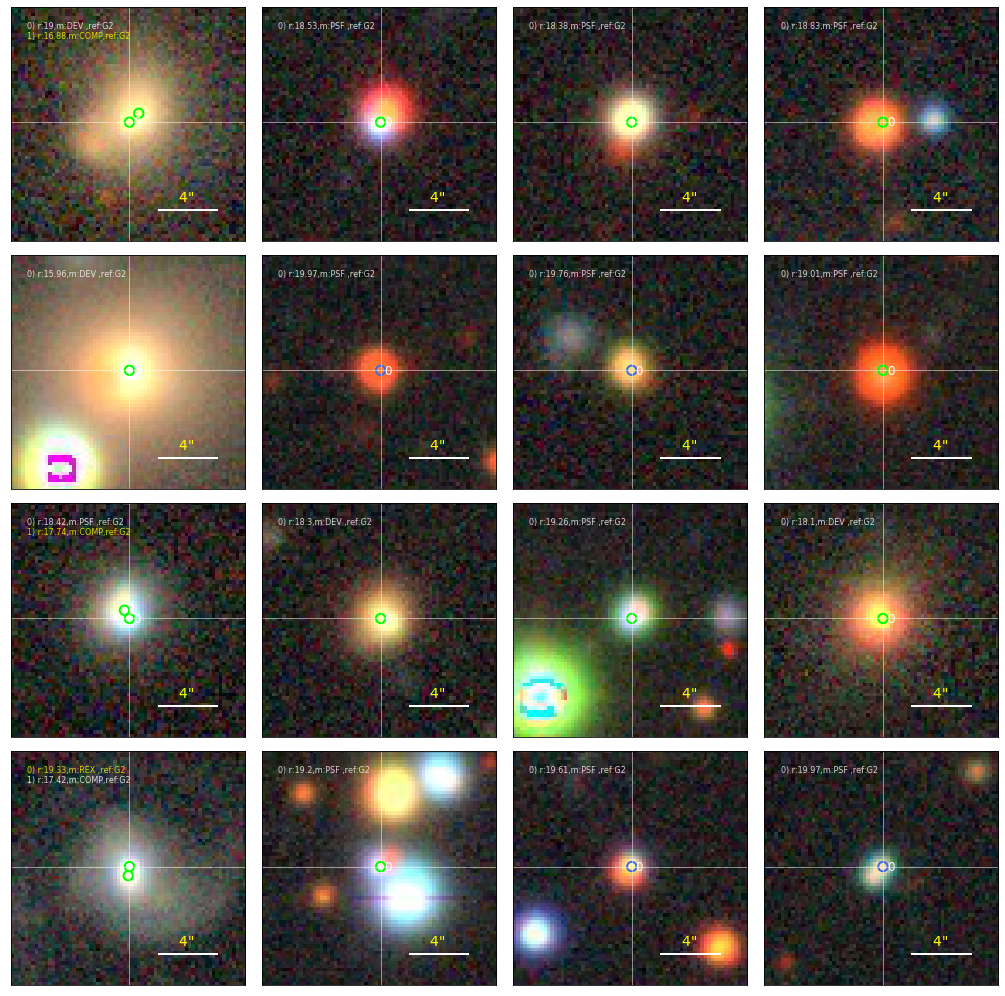

In [94]:
#Get the postages...
bright, faint = (cat['RMAG'][maskall] < 19.5), np.logical_and(cat['RMAG'][maskall] < 20.0, cat['RMAG'][maskall] > 19.5)
veto = {'bright':bright, 'faint':faint}
info = {'r':cat['RMAG'][maskall], 'm':cat['MORPHTYPE'][maskall].astype(str), 'ref':cat['REF_CAT'][maskall].astype(str)}
layer_dr7='decals-dr7'
layer_dr8='dr8'
#'dr8-model'

#indexes of BGS & LRG overlap
#idx = list(np.where((isBGS_sv1) & (isLRG_sv1)))[0]

#if we want to compare the same objects with another catalogue (i.e., DR7, DR8) select only
#the right number of indexes as your grid to avoid the random selection in postages_circle.
postages_circle(coord=[cat['RA'][maskall], cat['DEC'][maskall]], centeridx=idx2_m, veto=veto, info=info, scale=0.262, 
                scale_unit='pixscale', layer=layer_dr8, radius=1.5/3600., m=6, grid=[4,4], 
                savefile='gaia_binaries', layer2=None, layer2Mode='merge', isLG=False, title=None)


Colour key:
	 bright --> lime
	 faint --> royalblue
	 other --> red


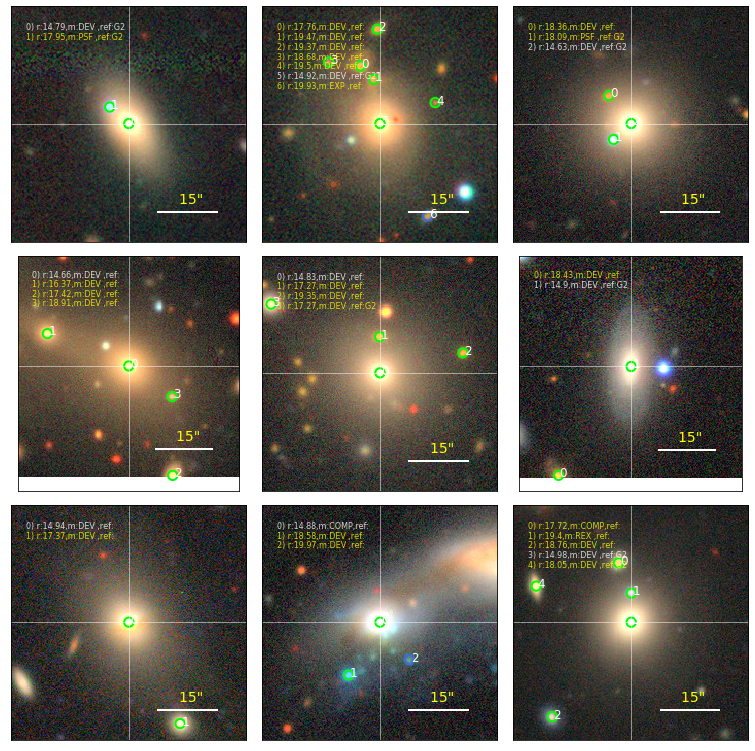

In [60]:
#Get the postages...
bright, faint = (cat['RMAG'][inbgs] < 19.5), np.logical_and(cat['RMAG'][inbgs] < 20.0, cat['RMAG'][inbgs] > 19.5)
veto = {'bright':bright, 'faint':faint}
info = {'r':cat['RMAG'][inbgs], 'm':cat['MORPHTYPE'][inbgs].astype(str), 'ref':cat['REF_CAT'][inbgs].astype(str)}
layer_dr7='decals-dr7'
layer_dr8='dr8'

#indexes of BGS & LRG overlap
#(cat['GAIA_PHOT_G_MEAN_MAG'][inbgs] == 0)
idx = list(np.where((cat['RMAG'][inbgs] < 15) & (cat['RMAG'][inbgs] > 10)))[0]

#if we want to compare the same objects with another catalogue (i.e., DR7, DR8) select only
#the right number of indexes as your grid to avoid the random selection in postages_circle.
postages_circle(coord=[cat['RA'][inbgs], cat['DEC'][inbgs]], centeridx=idx, veto=veto, info=info, scale=0.262, 
                scale_unit='pixscale', layer=layer_dr8, radius=1.5/3600., m=20, grid=[3,3], 
                savefile='bgs_zoo', layer2=None, layer2Mode='separate', isLG=False, title=None)


Create a table with matches of bgs and stellar cat...

## Dust clouds

In [22]:
# prepare cloud catalogue for 2D stacking
from astropy.table import Table
clouds0 = fitsio.read('/global/cscratch1/sd/mjwilson/BGS/SV-ASSIGN/clouds/clouds.fits')
cloudsindesi = get_isdesi(clouds0['RA'],clouds0['DEC'])
clouds1 = clouds0[cloudsindesi]
print('fraction of clouds in desi footprint %i/%i' %(len(clouds1), len(clouds0)))
clouds = Table()
clouds['RA'], clouds['DEC'], clouds['MAG'] = clouds1['RA'], clouds1['DEC'], np.ones_like(clouds1['RA']) 


1207 nearby objects
fraction of clouds in desi footprint 38/232


0.00 < MAG < 2.00
mag_mean 1.0
799444 nearby objects ~ 7.03171 %
mag_radii MAX: 0.0 mag_radii MIN: 0.0
mag MAX: 1.0 mag MIN: 1.0
density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-691, 190)
0 of inf in density ratio out of a total of 1804
Minimum density ratio = -0.454008, Maximum density ratio = 0.436043
----------------


/global/homes/q/qmxp55/.conda/envs/DESI_BGS_omar/lib/python3.7/site-packages/ipykernel_launcher.py:271: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


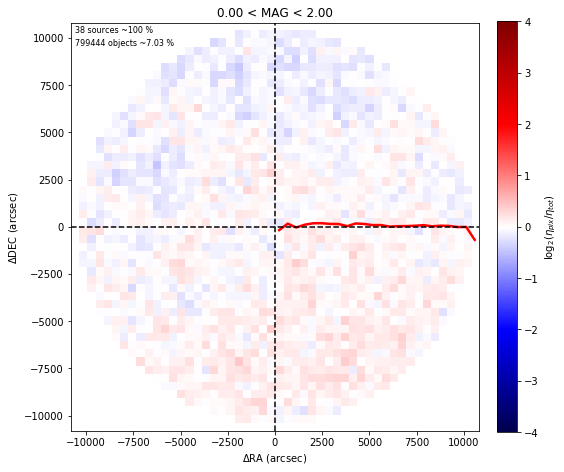

In [36]:
mag = np.linspace(0, 20, 50)
radii = []
for i,j in enumerate(mag):
    radii.append([j, 0.*j])

maskF = (maskdef_cat)& (BS_cat) & (LG_cat) & (GC_cat) & (iscatreg['isdesi']) & (cat['RMAG'] < 20.0) & (cat['RMAG'] > 19.5)
maskB = (maskdef_cat)& (BS_cat) & (LG_cat) & (GC_cat) & (iscatreg['isdesi']) & (cat['RMAG'] < 19.5)
mask2 = (iscatreg['isdesi'])
 
_ = overdensity(cat[maskB], clouds, radii, 'MAG', 35, density=False, 
                        magbins=(0,2,1), radii_2=None, grid=[1,1], SR=[1., 3*3600.], scaling=False, nbins=51, 
                               SR_scaling=5,logDenRat=[-4, 4], radii_bestfit=False, annulus=None, eqbined=True, 
                                   filename='2d_stack_clouds_bright')

# save catalogue and randoms for angular correlations

## Catalogue

In [ ]:
# extract region info from healpix pixels to BGS catalogue
isdes_pixlist = hpdict['hpxpixel'][hpdict['isdes']]
catisdes = np.in1d(hppix_cat, isdes_pixlist)

isdecals_pixlist = hpdict['hpxpixel'][hpdict['isdecals']]
catisdecals = np.in1d(hppix_cat, isdecals_pixlist)

isnorth_pixlist = hpdict['hpxpixel'][hpdict['isnorth']]
catisnorth = np.in1d(hppix_cat, isnorth_pixlist)

isdesi_pixlist = hpdict['hpxpixel'][hpdict['isdesi']]
catisdesi = np.in1d(hppix_cat, isdesi_pixlist)

istest_pixlist = hpdict['hpxpixel'][hpdict['istest']]
catistest = np.in1d(hppix_cat, istest_pixlist)

iscatreg = {'isdes': catisdes, 'isdecals': catisdecals, 'isnorth': catisnorth, 'isdesi': catisdesi, 'istest': catistest}

# save region info as npy file
from astropy.table import Table
tabreg = Table()

for key in iscatreg.keys():
    tabreg[key] = iscatreg[key]
    
# save astropy table as npy file
dest = '/global/cscratch1/sd/qmxp55/inREGIONS_bgs_dr8_0.31.1_relaxed'
np.save(dest, tabreg)

In [16]:
# match associated target density for each object
import pandas as pd

s = pd.Series(hppix_cat)
d = s.groupby(s).groups

DENS = np.zeros_like(cat['RA'])
hpdens = (hpdict['south_nany'] + hpdict['north_nany'] ) / (pixarea * hpdict['bgsfracarea'])
#
for npixid, catids in zip(d.keys(), d.values()):
    DENS[catids] = hpdens[npixid]

In [62]:
# write out catalogue
from astropy.table import Table

tab = Table()

mask = (maskdef_cat) & (LG_cat) & (GC_cat) & (catisdesi)

tab['RA'], tab['DEC'] = cat['RA'][mask], cat['DEC'][mask]
tab['RMAG'], tab['GMAG'], tab['ZMAG'] = cat['RMAG'][mask], cat['GMAG'][mask], cat['ZMAG'][mask]
for key in iscatreg.keys():
    if key != 'isdesi': tab[key] = iscatreg[key][mask]
    else: continue
tab['DENS'] = DENS[mask]

# save astropy table as npy file
dest = '/global/cscratch1/sd/qmxp55/BGS_main_dr8_pauline'
np.save(dest, tab)

## randoms

In [64]:
# extract region info from healpix pixels to BGS catalogue
isdes_pixlist = hpdict['hpxpixel'][hpdict['isdes']]
ranisdes = np.in1d(hppix_ran, isdes_pixlist)

isdecals_pixlist = hpdict['hpxpixel'][hpdict['isdecals']]
ranisdecals = np.in1d(hppix_ran, isdecals_pixlist)

isnorth_pixlist = hpdict['hpxpixel'][hpdict['isnorth']]
ranisnorth = np.in1d(hppix_ran, isnorth_pixlist)

isdesi_pixlist = hpdict['hpxpixel'][hpdict['isdesi']]
ranisdesi = np.in1d(hppix_ran, isdesi_pixlist)

istest_pixlist = hpdict['hpxpixel'][hpdict['istest']]
ranistest = np.in1d(hppix_ran, istest_pixlist)

isranreg = {'isdes': ranisdes, 'isdecals': ranisdecals, 'isnorth': ranisnorth, 'isdesi': ranisdesi, 'istest': ranistest}

# save region info as npy file
from astropy.table import Table
tabreg = Table()

for key in isranreg.keys():
    tabreg[key] = isranreg[key]
    
# save astropy table as npy file
dest = '/global/cscratch1/sd/qmxp55/inREGIONS_randoms_dr8_0.31.1_N3'
np.save(dest, tabreg)

In [68]:
# match associated target density for each object
import pandas as pd

s = pd.Series(hppix_ran)
d = s.groupby(s).groups

DENS = np.zeros_like(randoms['RA'])
hpdens = (hpdict['south_nany'] + hpdict['north_nany'] ) / (pixarea * hpdict['bgsfracarea'])
#
for npixid, catids in zip(d.keys(), d.values()):
    DENS[catids] = hpdens[npixid]

/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in true_divide


In [69]:
# write out randoms
from astropy.table import Table

tab = Table()

mask = (maskdef_ran) & (LG_ran) & (GC_ran) & (ranisdesi)

tab['RA'], tab['DEC'] = randoms['RA'][mask], randoms['DEC'][mask]
for key in isranreg.keys():
    if key != 'isdesi': tab[key] = isranreg[key][mask]
    else: continue
tab['DENS'] = DENS[mask]

# save astropy table as npy file
dest = '/global/cscratch1/sd/qmxp55/randoms_dr8_N3_pauline'
np.save(dest, tab)

# DEV ZONE...

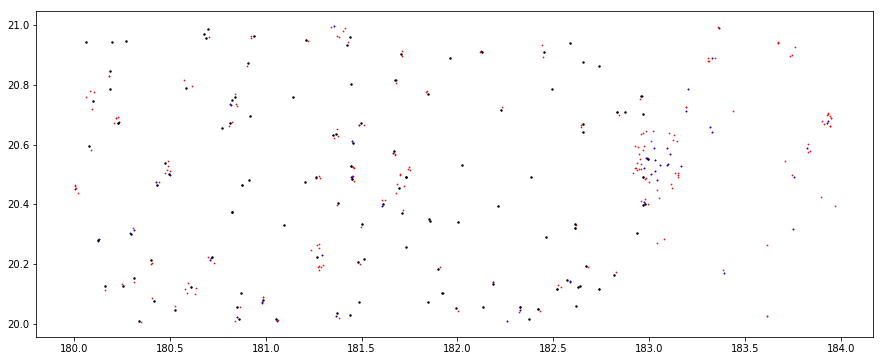

In [161]:
plt.figure(figsize=(15,6))
mask = (BSdict['cat_1.2']) & (cat['RA'] > 180) & (cat['RA'] < 184) & (cat['DEC'] > 20) & (cat['DEC'] < 21)
mask2 = (BSdict['cat_2.0']) & (cat['RA'] > 180) & (cat['RA'] < 184) & (cat['DEC'] > 20) & (cat['DEC'] < 21)
maskstars = (bscat['RA'] > 180) & (bscat['RA'] < 183) & (bscat['DEC'] > 20) & (bscat['DEC'] < 21)

plt.scatter(cat['RA'][mask2], cat['DEC'][mask2], s=0.5, c='r')
plt.scatter(cat['RA'][mask], cat['DEC'][mask], s=0.5, c='blue')
plt.scatter(bscat['RA'][maskstars], bscat['DEC'][maskstars], c='k', s=2)
plt.show()

In [107]:
# build BS catalogue from tycho2 and gaia dr2 stars
from geometric_def import query_catalog_mask, LSLGA_fit, LSLGA_veto, circular_mask_radii_func
from raichoorlib import search_around

# load tycho2 and keep objects in desi footprint
path = '/global/homes/q/qmxp55/DESI/matches/'
tycho = fitsio.read(path+'tycho2.fits')
keep = get_isdesi(tycho['RA'],tycho['DEC'])
keep &= tycho['MAG_VT'] <= 13
tycho = tycho[keep]
print('# tycho stars: %i' %(len(tycho)))

# load gaia dr2
gaia = np.load('/global/cscratch1/sd/qmxp55/gaia_G13.npy') # it's already on desi footprint
# Stars with AEN class...
stars_aen = np.zeros_like(gaia['RA'], dtype='?')
stars_aen |= ((gaia['G'] < 19) & (gaia['AEN'] < 10**(0.5))) 
stars_aen |= ((gaia['G'] >= 19) & (gaia['AEN'] < 10**(0.5 + 0.2*(gaia['G'] - 19.))))
# match with tycho and keep the ones that are not in tycho
idx2, idx1, d2d, d_ra, d_dec = search_around(gaia['RA'], gaia['DEC'], tycho['RA'], tycho['DEC'], search_radius=1)
gaiainty = np.zeros_like(gaia, dtype='?')
gaiainty[idx2] = True
print('gaia in tycho: %i/%i' %(np.sum(gaiainty), len(gaia)))
gaia = gaia[(stars_aen) & (~gaiainty)]
print('# gaia stars: %i' %(len(gaia)))


1207 nearby objects
# tycho stars: 500961
414976 nearby objects
gaia in tycho: 414601/1287775
# gaia stars: 858612


2019-10-22 06:45:57 start
1207 nearby objects
computing for  north / any
computing for  north / bright
computing for  north / faint
plotting for  north / any
plotting for  north / bright
plotting for  north / faint


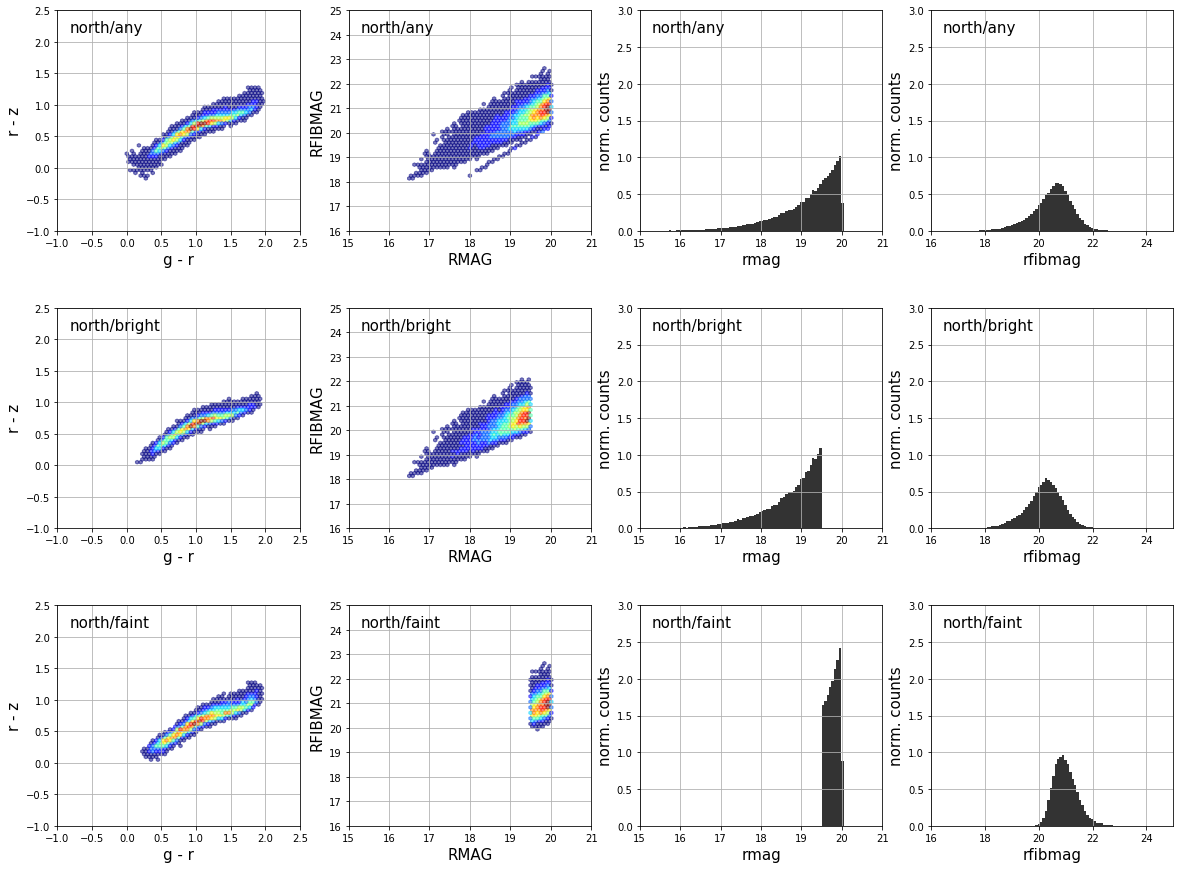

1207 nearby objects
computing for  south / any
computing for  south / bright
computing for  south / faint
plotting for  south / any
plotting for  south / bright
plotting for  south / faint


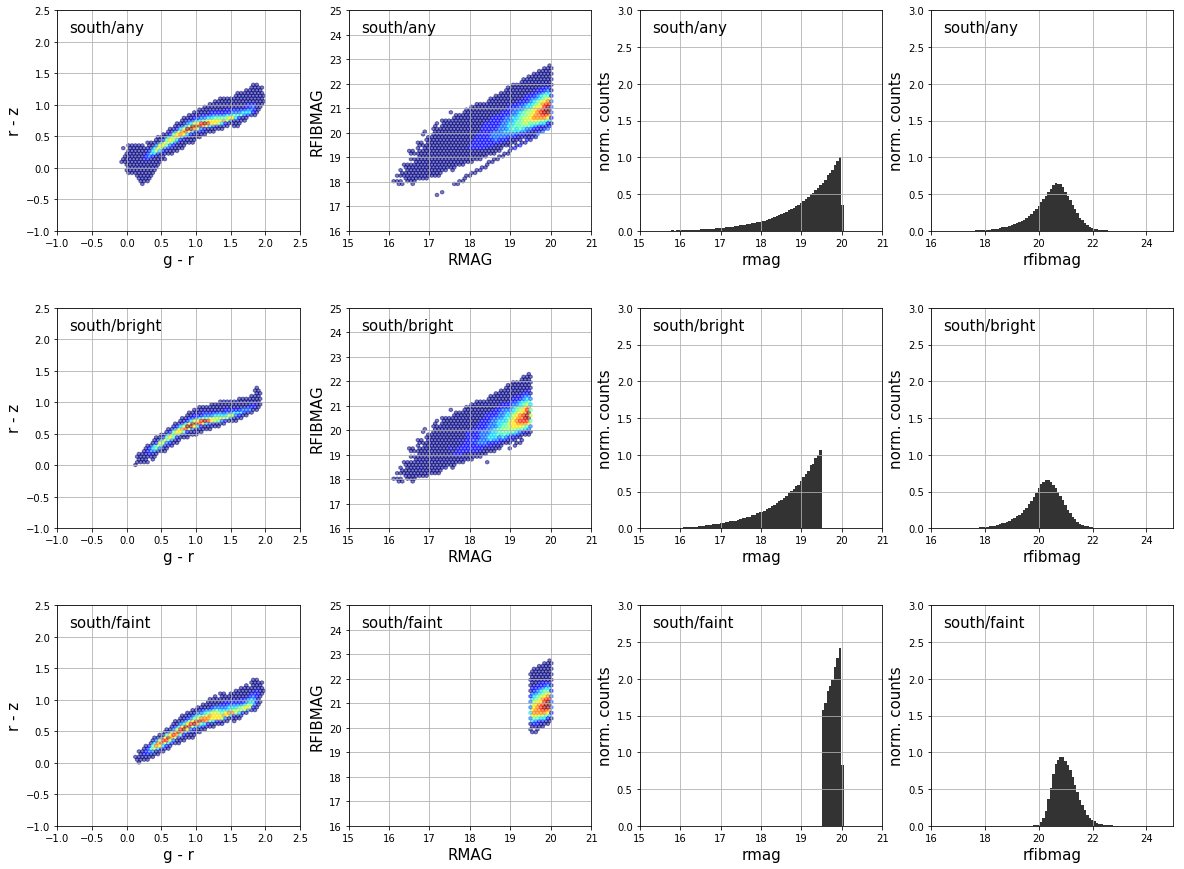

any
meandens_any_all = 1421 /deg2
meandens_any_des = 1434 /deg2
meandens_any_decals = 1431 /deg2
meandens_any_north = 1400 /deg2
meandens_any_south = 1432 /deg2
bright
meandens_bright_all = 809 /deg2
meandens_bright_des = 821 /deg2
meandens_bright_decals = 816 /deg2
meandens_bright_north = 792 /deg2
meandens_bright_south = 817 /deg2
faint
meandens_faint_all = 576 /deg2
meandens_faint_des = 579 /deg2
meandens_faint_decals = 577 /deg2
meandens_faint_north = 573 /deg2
meandens_faint_south = 578 /deg2
2019-10-22 06:46:58 end


/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:117: RuntimeWarning: invalid value encountered in true_divide


In [10]:
# dr8_south+north : read sv data + sanity check + storing mean hpdens 
print(raichoorlib.get_date(), 'start')

#target densities
data = np.load(inptfiles['bgsdr8'])

# subsamples (BGS SV supersets)
namesels = {'any':-1, 'bright':1, 'faint':0}

for foot in ['north','south']:

    ## cutting on desi footprint
    keep = get_isdesi(data['RA'],data['DEC'])
    ## cutting on dec_resol_ns in the ngc
    c    = SkyCoord(data['RA']*units.degree,data['DEC']*units.degree, frame='icrs')
    galb = c.galactic.b.value
    if (foot=='north'):
        keep&= (data['DEC']>dec_resol_ns) & (galb>0)
    if (foot=='south'):
        keep&= (data['DEC']<dec_resol_ns) | (galb<0)        
    ##
    data0 = data[keep]

    # storing density in hpdict
    hppix           = hp.ang2pix(nside,(90.-data0['DEC'])*np.pi/180.,data0['RA']*np.pi/180.,nest=nest)
    for namesel, bitnum in zip(namesels.keys(), namesels.values()):
        print('computing for ', foot, '/', namesel)
        if (namesel=='any'):             sel = np.ones(len(data0),dtype=bool)
        else:                            sel = ((data0['BGS_TARGET'] & 2**(bitnum)) != 0)
            
        ind,c           = np.unique(hppix[sel],return_counts=True)
        hpdict[foot+'_n'+namesel]      = np.zeros(npix)
        hpdict[foot+'_n'+namesel][ind] = c

    # plotting (sanity checks with 1%)
    fracplot   = 0.01
    selplot    = np.zeros(len(data0),dtype=bool)
    selplot[np.random.choice(len(data0),size=int(fracplot*len(data0)),replace=False)] = True
    fig        = plt.figure(figsize=(20,15))
    gs         = gridspec.GridSpec(len(namesels),4,wspace=0.2,hspace=0.35)
    # mollweide
    ramw,decmw = get_radec_mw(data0['RA'],data0['DEC'],org)
    ax         = plt.subplot(gs[0,:],projection=projection)
    _          = set_mwd(ax,org=org)
    SC         = ax.scatter(ramw[selplot],decmw[selplot],s=0.01,rasterized=True)
    
    for ip,namesel in enumerate(namesels.keys()):
        print('plotting for ', foot, '/', namesel)
        sellab = foot+'/'+namesel
        if (namesel=='any'):             sel = np.ones(len(data0),dtype=bool)
        else:                            sel = ((data0['BGS_TARGET'] & 2**(namesels[namesel])) != 0)
        sel &= (selplot) # subsampling
        
        # grz
        ax = plt.subplot(gs[ip,0])

        gr = data0['GMAG'] - data0['RMAG']
        rz = data0['RMAG'] - data0['ZMAG']
        ylim,ylab = (-1,2.5),'r - z'
        xlim,xlab = (-1,2.5),'g - r'
        HB = ax.hexbin(gr[sel],rz[sel],C=None,
                gridsize=70,extent=(xlim[0],xlim[1],ylim[0],ylim[1]),cmap=cm,mincnt=10,
                alpha=0.5)
        ax.set_xlabel(xlab,fontsize=15)
        ax.set_ylabel(ylab,fontsize=15)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.grid(True)
        ax.text(0.05,0.90,sellab,fontsize=15,transform=ax.transAxes)
        
        # coii-g
        ax = plt.subplot(gs[ip,1])
        xlim,xlab = (15,21),'RMAG'
        ylim,ylab = (16,25),'RFIBMAG'
        HB = ax.hexbin(data0['RMAG'][sel],data0['RFIBMAG'][sel],C=None,
                gridsize=70,extent=(xlim[0],xlim[1],ylim[0],ylim[1]),cmap=cm,mincnt=10,
                alpha=0.5)
        ax.set_xlabel(xlab,fontsize=15)
        ax.set_ylabel(ylab,fontsize=15)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.grid(True)
        ax.text(0.05,0.90,sellab,fontsize=15,transform=ax.transAxes)
        
        # gtot hist
        xlim  = (15,21)
        xgrid = np.linspace(xlim[0],xlim[1],101)
        ax = plt.subplot(gs[ip,2])
        ax.hist(data0['RMAG'][sel],bins=xgrid,histtype='stepfilled',alpha=0.8,color='k',density=True)
        ax.set_xlabel('rmag',fontsize=15)
        ax.set_ylabel('norm. counts',fontsize=15)
        ax.set_xlim(xlim)
        ax.set_ylim(0,3)
        ax.grid(True)
        ax.text(0.05,0.90,sellab,fontsize=15,transform=ax.transAxes)
        # gfib hist
        xlim  = (16,25)
        xgrid = np.linspace(xlim[0],xlim[1],101)
        ax = plt.subplot(gs[ip,3])
        ax.hist(data0['RFIBMAG'][sel],bins=xgrid,histtype='stepfilled',alpha=0.8,color='k',density=True)
        ax.set_xlabel('rfibmag',fontsize=15)
        ax.set_ylabel('norm. counts',fontsize=15)
        ax.set_xlim(xlim)
        ax.set_ylim(0,3)
        ax.grid(True)
        ax.text(0.05,0.90,sellab,fontsize=15,transform=ax.transAxes)
        #
    plt.show()
    plt.close()


# storing mean hpdens
isdesi = (hpdict['isdesi']) & (hpdict['bgsfracarea']>0)
for namesel in namesels.keys():
    print(namesel)
    ## south + north density
    hpdens = (hpdict['south_n'+namesel] + hpdict['north_n'+namesel] ) / (pixarea * hpdict['bgsfracarea'])
    ## split per region
    for reg in ['all','des','decals','north', 'south']:
        if (reg=='all'):
            hpdict['meandens_'+namesel+'_'+reg] = np.nanmean(hpdens[isdesi])
        else:
            hpdict['meandens_'+namesel+'_'+reg] = np.nanmean(hpdens[(isdesi) & (hpdict['is'+reg])])
        print('meandens_'+namesel+'_'+reg+' = '+'%.0f'%hpdict['meandens_'+namesel+'_'+reg]+' /deg2')

#print(np.sort(hpdict.keys()))

print(raichoorlib.get_date(), 'end')

In [7]:
# creating dictionary
hpdict     = {}
theta,phi  = hp.pix2ang(nside,np.arange(npix),nest=nest)
hpdict['ra'],hpdict['dec'] = 180./np.pi*phi,90.-180./np.pi*theta
c          = SkyCoord(hpdict['ra']*units.degree,hpdict['dec']*units.degree, frame='icrs')
hpdict['gall'],hpdict['galb'] = c.galactic.l.value,c.galactic.b.value

# is in desi tile?
hpdict['isdesi'] = get_isdesi(hpdict['ra'],hpdict['dec'])

# propagating some keys from ADM pixweight
hdu        = fits.open(inptfiles['dr8pix'])
data       = hdu[1].data
for key in ['HPXPIXEL', 'FRACAREA', 
            'STARDENS', 'EBV', 
            'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z',
            'GALDEPTH_G', 'GALDEPTH_R', 'GALDEPTH_Z',
            'PSFDEPTH_W1', 'PSFDEPTH_W2',
            'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z']:
    if (key=='STARDENS'):
        hpdict[key.lower()] = np.log10(data[key])
    elif (key[:8]=='GALDEPTH'):
        hpdict[key.lower()] = 22.5-2.5*np.log10(5./np.sqrt(data[key]))
    else:
        hpdict[key.lower()] = data[key]
        
# reading randoms to get bgs fraction area
# (using all rand files to minimize poisson noise in the area estimation)
# (however using only 1 rand file should also provide reasonable results; and be x10 faster)
data = get_random(N=Nranfiles, sweepsize=None, dr='dr8')
norig = len(data)
#cut in desi footprint
ranindesi = get_isdesi(data['RA'],data['DEC'])
print('fraction of randoms in desi footprint %f' %(np.sum(ranindesi)/len(data['RA'])))
# make cut in NOBS
keep = (data['NOBS_G']>0) & (data['NOBS_R']>0) & (data['NOBS_Z']>0)
print('keeping ', len(data[(keep) & (ranindesi)]), '/', norig, 'after cutting on g+r+z')
# make cuts in maskbits
for bit in veto_maskbits:
    keep &= ((data['MASKBITS'] & 2**bit)==0)
print('keeping ', len(data[(keep) & (ranindesi)]), '/', norig, 'after cutting on g+r+z and maskbits')
randdens, ra, dec = 5000*Nranfiles, data['RA'][(keep) & (ranindesi)], data['DEC'][(keep) & (ranindesi)]
print('randdens = ', randdens, ' ; len randoms = ', len(ra))

# computing areas
hppix           = hp.ang2pix(nside,(90.-np.array(dec))*np.pi/180.,np.array(ra)*np.pi/180.,nest=nest)
ind,c           = np.unique(hppix,return_counts=True)
hpdict['bgsfracarea']      = np.zeros(npix)
hpdict['bgsfracarea'][ind] = c / randdens / pixarea

# north/south/des/decals
hpdict['issouth'] = np.zeros(npix,dtype=bool)
tmp               = (hpdict['bgsfracarea']>0) & ((hpdict['galb']<0) | ((hpdict['galb']>0) & (hpdict['dec']<dec_resol_ns)))
hpdict['issouth'][tmp] = True
hpdict['isnorth'] = np.zeros(npix,dtype=bool)
tmp               = (hpdict['bgsfracarea']>0) & (hpdict['dec']>dec_resol_ns) & (hpdict['galb']>0)
hpdict['isnorth'][tmp] = True
hpdict['isdes']   = raichoorlib.get_isdes(hpdict['ra'],hpdict['dec'])
hpdict['isdecals']= (hpdict['issouth']) & (~hpdict['isdes'])

# areas
hpdict['area_all']   = hpdict['bgsfracarea'].sum() * pixarea
for reg in ['south','decals','des','north']:
    hpdict['bgsarea_'+reg]   = hpdict['bgsfracarea'][hpdict['is'+reg]].sum() * pixarea 

1207 nearby objects


/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in sqrt


RANDOM file already exist at:/global/cscratch1/sd/qmxp55/dr8_random_N3.npy
Total run time: 0.000593 sec
Weight of /global/cscratch1/sd/qmxp55/dr8_random_N3.npy catalogue: 6.82 GB
1207 nearby objects
